<a href="https://colab.research.google.com/github/szdziedzic/interval-hyper-maml/blob/main/IntervalBayessianHyperMAML_2D_vizualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Dict, cast
from collections import defaultdict
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from torch import Tensor


In [56]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

# Uczymy na logistycznej regresji
1. chcemy MAML i nasze nauczyć na logistycznej regresji (sieć z jadną wastwą i aktywacją sigmoid)
2. Ucze w setingu few shot
3. taski idą losowo z dwóch zadań: pionowe bloby i poziome bloby
# MAML (jako pierwszy task)
1. jako pierwsze zadanie robimy MAML i tu jest prosto bo tylko robimy mniejszą sieć
# Nasze (jako drugi task)
1. dokładnie taka sama architektura, tylko bez feature extraktor.
- dane z suporta odrazu concatenuję i wrzucam do hypernetwork (w przypadku kerneli poprostu od razu licze kernele)
- od target networku odrazu wchodzą punkty bez feature extraktora


# Pierwsze zadania

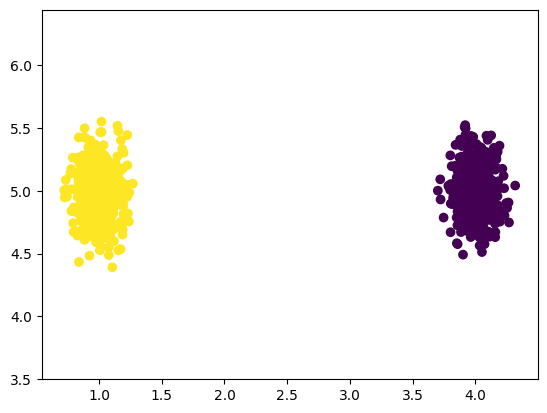

In [57]:
from scipy import stats
n = 500
def sample_task_I(n, swap_labels=None):
  m1 = [1,5]
  m2 = [4,5]
  s1 = [0.1,0.2]
  s2 = [0.1,0.2]
  X =  np.vstack(( np.vstack( (stats.norm(m1[0],s1[0]).rvs(n), stats.norm(m1[1], s1[1]).rvs(n)) ).T,
                   np.vstack( (stats.norm(m2[0],s2[0]).rvs(n), stats.norm(m2[1], s2[1]).rvs(n)) ).T ))
  y = np.repeat([0,1],n)

  if swap_labels is True:
    y = np.repeat([1,0],n)
  # czasami zamieniam kolejnoscią labele
  if np.mean(X[:,1]) < m1[1] and swap_labels is None:
    y = np.repeat([1,0],n)
  return X.astype(np.float32), y

X1, y1 = sample_task_I(n)
plt.scatter(X1[:,0], X1[:,1], c=y1)
plt.axis("equal")
plt.show()

# Drugie zadania

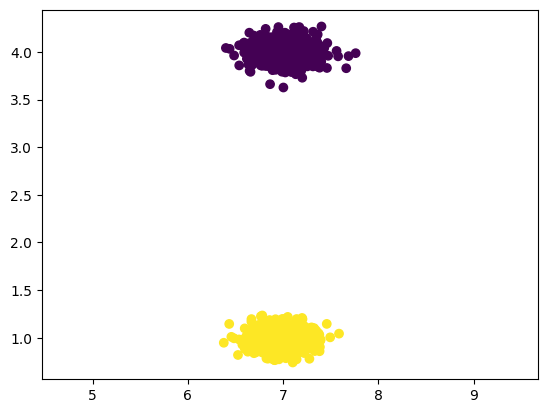

In [58]:
n = 500
def sample_task_II(n, swap_labels=None):
  m1 = [7,1]
  m2 = [7,4]
  s1 = [0.2,0.1]
  s2 = [0.2,0.1]
  X =  np.vstack(( np.vstack( (stats.norm(m1[0],s1[0]).rvs(n), stats.norm(m1[1], s1[1]).rvs(n)) ).T,
                   np.vstack( (stats.norm(m2[0],s2[0]).rvs(n), stats.norm(m2[1], s2[1]).rvs(n)) ).T ))
  y = y = np.repeat([0,1],n)

  if swap_labels is True:
    y = np.repeat([1,0],n)

  # czasami zamieniam kolejnoscią labele
  if np.mean(X[:,0]) < m1[0] and swap_labels is None:
    y = np.repeat([1,0],n)

  return X.astype(np.float32), y

X2, y2 = sample_task_II(n)
plt.scatter(X2[:,0], X2[:,1], c=y2)
plt.axis("equal")
plt.show()

# Tylko, żeby zobaczyć jak oba wyglądają, ale w kodzie idzie albo jeden task albo drugi

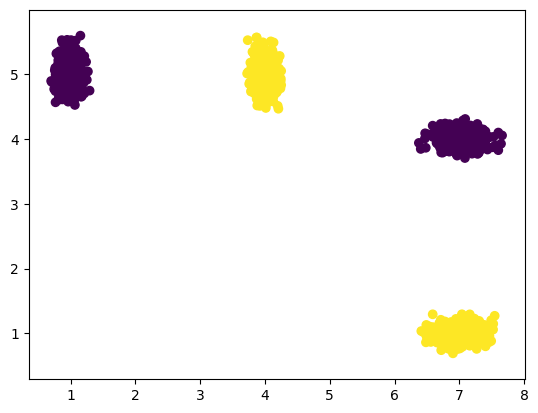

In [59]:
#ten zbió danych do wizualizacji parametrów

X1, y1 = sample_task_I(n)
X2, y2 = sample_task_II(n)

X = np.vstack( (X1, X2) )
y = np.vstack( (y1, y2) )
plt.scatter(X[:,0], X[:,1], c=y)
plt.axis("equal")
plt.show()

X_all = X
y_all = y

# kod do generowania tasków

In [60]:
def make_task(n):
  r = random.uniform(0, 1)
  if r < 0.5:
    X, y = sample_task_I(n)
  else:
    X, y = sample_task_II(n)
  return (X,y)

In [61]:
def split_support_query(X, y):
    ones = np.where(y == 1)[0]

    threshold = ones.size // 2

    support_ind_ones = ones[:threshold]
    query_ind_ones = ones[threshold:]

    zeros = np.where(y == 0)[0]

    threshold = zeros.size // 2

    support_ind_zeros = zeros[:threshold]
    query_ind_zeros = zeros[threshold:]

    support_indices = np.concatenate((support_ind_ones, support_ind_zeros), axis=0)
    query_indices = np.concatenate((query_ind_ones, query_ind_zeros), axis=0)

    return torch.from_numpy(X[support_indices]), torch.from_numpy(y[support_indices].astype(np.float32)), torch.from_numpy(X[query_indices]), torch.from_numpy(y[query_indices].astype(np.float32))

In [62]:
class Linear_fw(nn.Linear): #used in MAML to forward input with fast weight
    def __init__(self, in_features, out_features):
        super(Linear_fw, self).__init__(in_features, out_features)
        self.weight.fast = None #Lazy hack to add fast weight link
        self.bias.fast = None

    def forward(self, x):
        if self.weight.fast is not None and self.bias.fast is not None:
            out = F.linear(x, self.weight.fast, self.bias.fast) #weight.fast (fast weight) is the temporaily adapted weight
        else:
            out = super(Linear_fw, self).forward(x)
        return out

In [63]:
#@title
def correct(self, x):
    scores = self.set_forward(x)
    y_query = np.repeat(range( self.n_way ), self.n_query )

    topk_scores, topk_labels = scores.data.topk(1, 1, True, True)
    topk_ind = topk_labels.cpu().numpy()
    top1_correct = np.sum(topk_ind[:,0] == y_query)
    return float(top1_correct), len(y_query)
def get_vector(model):
    A = model.classifier.weight[0][0].detach().numpy()
    B = model.classifier.weight[0][1].detach().numpy()
    C = model.classifier.bias[0].detach().numpy()
    return A, B, C

def get_fast_vector(model):
    A = model.classifier.weight.fast[0][0].detach().numpy()
    B = model.classifier.weight.fast[0][1].detach().numpy()
    C = model.classifier.bias.fast[0].detach().numpy()
    return A, B, C

In [64]:
#@title
class MAML(nn.Module):
    def __init__(self, n_way, n_support, n_query, approx=False):
        super(MAML, self).__init__()
        self.n_way      = n_way
        self.n_support  = n_support
        self.n_query    = -1 #(change depends on input)
        self.change_way = False #some methods allow different_way classification during training and test

        self.feat_dim = 2

        self.loss_fn = nn.BCELoss()
        self.classifier = Linear_fw(self.feat_dim, 1)
        self.classifier.bias.data.fill_(0)

        self.n_task = 4
        self.task_update_num = 1
        self.train_lr = 0.01

        self.approx = approx #first order approx.
        self.fast_params_list = []

    def forward(self, x):
        out  = torch.sigmoid(self.classifier(x))
        return out

    def set_forward(self, X_support, y_support, X_query, y_query, is_feature = False):
        assert is_feature == False, 'MAML do not support fixed feature'

        self.fast_params_list.clear()

        fast_parameters = list(self.parameters()) #the first gradient calcuated in line 45 is based on original weight
        for weight in self.parameters():
            weight.fast = None

        self.zero_grad()
        accuracies = []
        for task_step in range(self.task_update_num):
            scores = self.forward(X_support)

            set_loss = self.loss_fn( scores, y_support.unsqueeze(1))
            grad = torch.autograd.grad(set_loss, fast_parameters, create_graph=True) #build full graph support gradient of gradient

            if self.approx:
                grad = [ g.detach()  for g in grad ] #do not calculate gradient of gradient if using first order approximation
            fast_parameters = []

            for k, weight in enumerate(self.parameters()):
                #for usage of weight.fast, please see Linear_fw, Conv_fw in backbone.py
                if weight.fast is None:
                    weight.fast = weight - self.train_lr * grad[k] #create weight.fast
                else:
                    weight.fast = weight.fast - self.train_lr * grad[k] #create an updated weight.fast, note the '-' is not merely minus value, but to create a new weight.fast
                fast_parameters.append(weight.fast) #gradients calculated in line 45 are based on newest fast weight, but the graph will retain the link to old weight.fasts
            self.fast_params_list.append(get_fast_vector(self))

            q_scores = self.forward(X_query)
            predictions  = (q_scores > 0.5).squeeze()
            positions = (predictions == y_query).float()
            accuracies.append((positions.sum() / predictions.size()[0]).item() * 100)

        scores = self.forward(X_query)
        return scores, accuracies

    def set_forward_loss(self, X_support, y_support, X_query, y_query):
        scores, accuracies = self.set_forward(X_support, y_support, X_query, y_query, is_feature = False)
        y_query = y_query.unsqueeze(1)
        loss = self.loss_fn(scores, y_query)

        predictions  = (scores > 0.5)
        positions = (predictions == y_query)
        task_accuracy = (positions.sum() / predictions.size()[0]) * 100

        return loss, accuracies + [task_accuracy], positions.squeeze()

    def get_logits(self, x):
        self.n_query = x.size(1) - self.n_support
        logits = self.set_forward(x)
        return logits

In [65]:
np.random.seed(seed)
torch.manual_seed(seed)

model = MAML(n_way=2, n_support=10, n_query=10, approx=False)
model.task_update_num = 5
model.n_task = 4
model.train_lr = 1e-1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model

MAML(
  (loss_fn): BCELoss()
  (classifier): Linear_fw(in_features=2, out_features=1, bias=True)
)

In [66]:
enable_plotting = True
plot_decision_boundary = True
plot_adaptation_arrows = True

MAML training

Epoch 0 | Loss 0.350720 | Acc 100.00% | Task Acc 100.00%


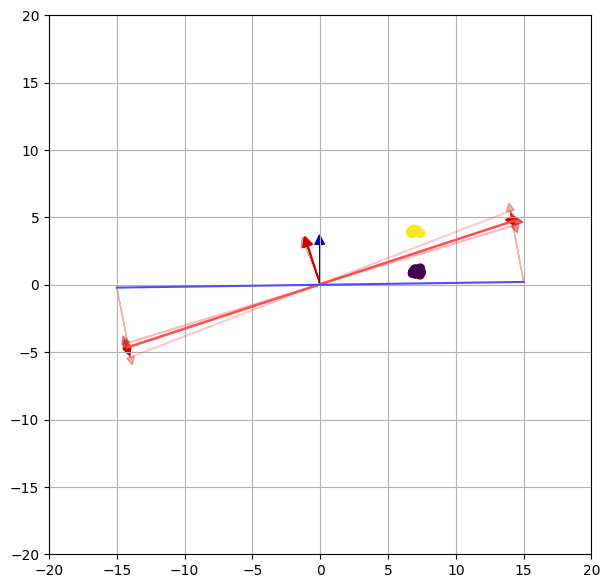

Epoch 250 | Loss 0.501768 | Acc 86.61% | Task Acc 100.00%


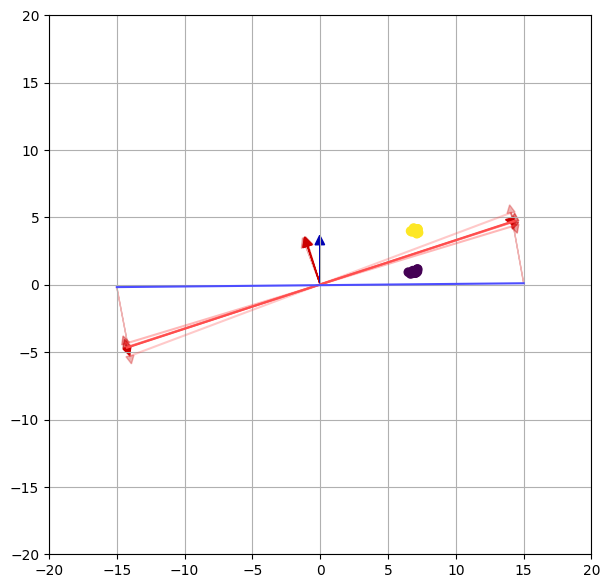

Epoch 500 | Loss 0.506013 | Acc 87.09% | Task Acc 50.00%


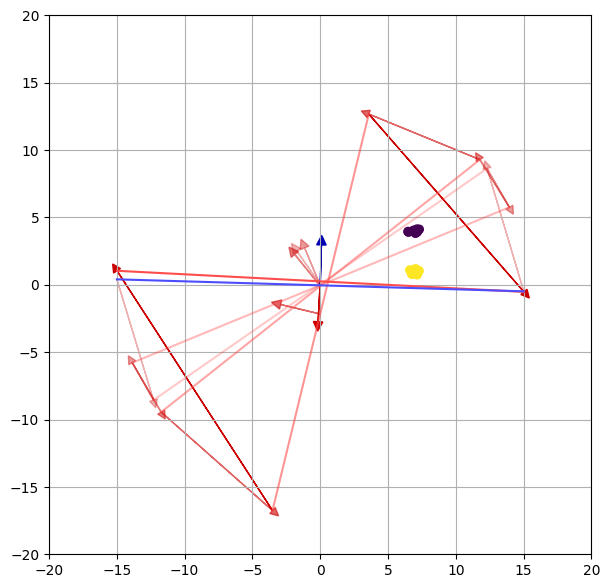

Epoch 750 | Loss 0.508729 | Acc 88.33% | Task Acc 100.00%


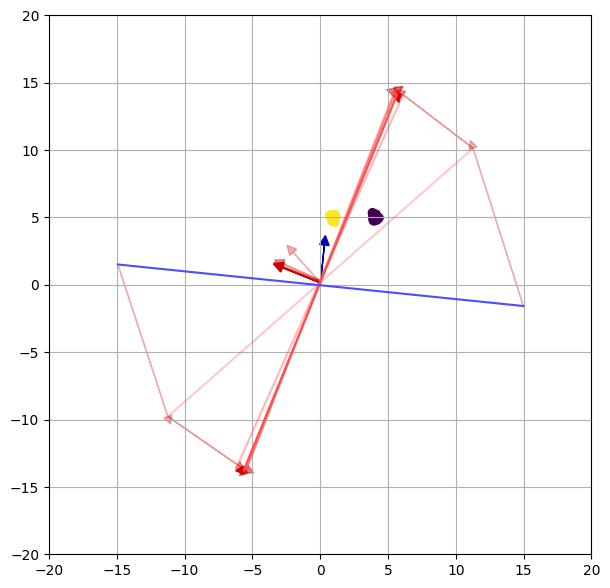

Epoch 1000 | Loss 0.508508 | Acc 90.55% | Task Acc 100.00%


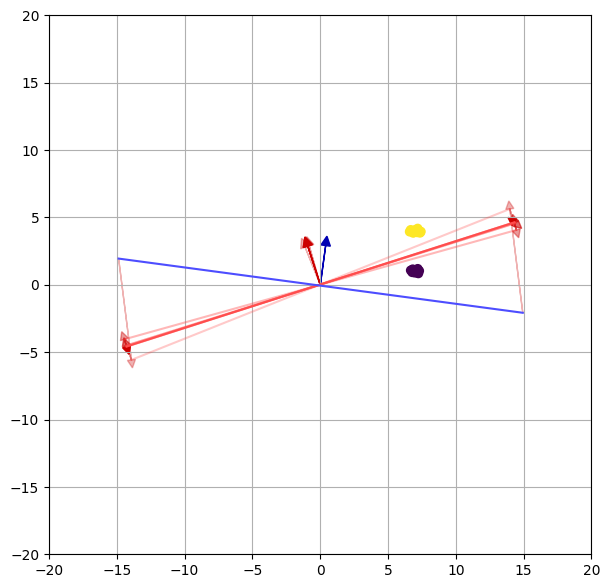

Epoch 1250 | Loss 0.506687 | Acc 92.39% | Task Acc 100.00%


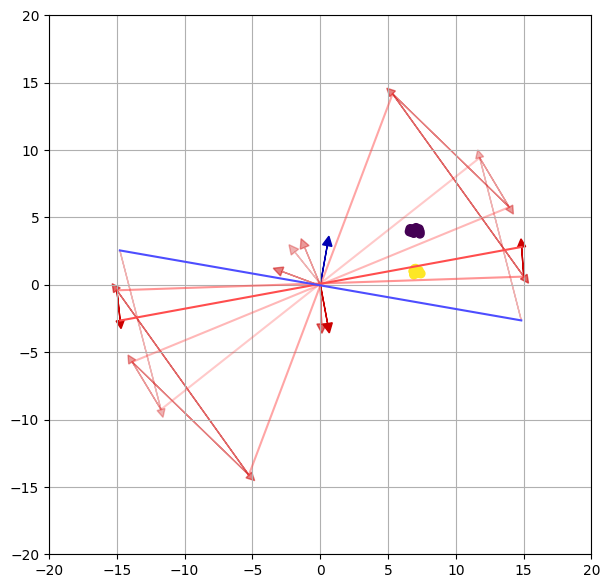

Epoch 1500 | Loss 0.505477 | Acc 93.65% | Task Acc 100.00%


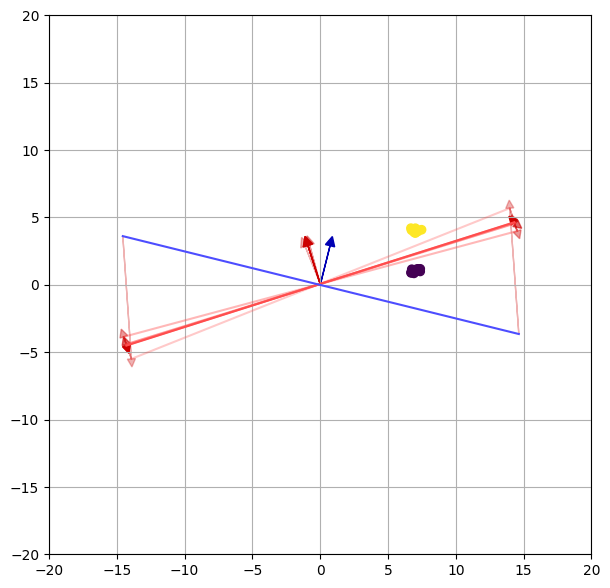

Epoch 1750 | Loss 0.504925 | Acc 94.56% | Task Acc 100.00%


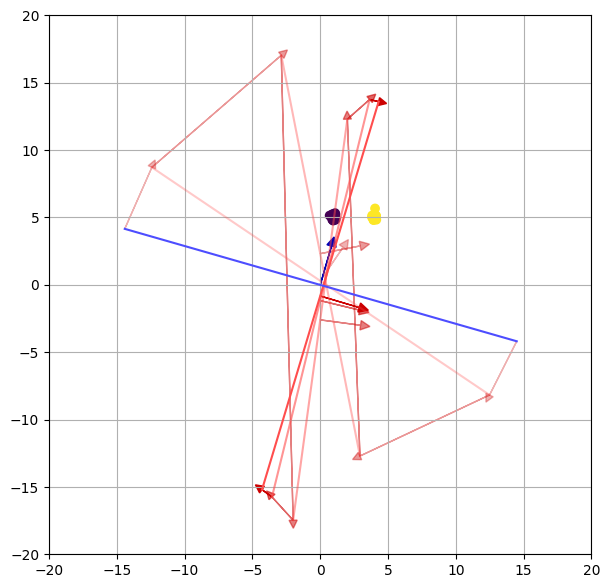

Epoch 2000 | Loss 0.504401 | Acc 95.24% | Task Acc 100.00%


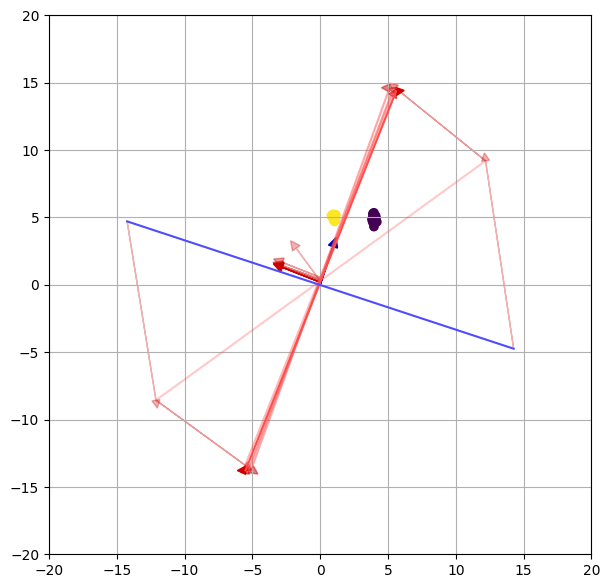

Epoch 2250 | Loss 0.504487 | Acc 95.77% | Task Acc 100.00%


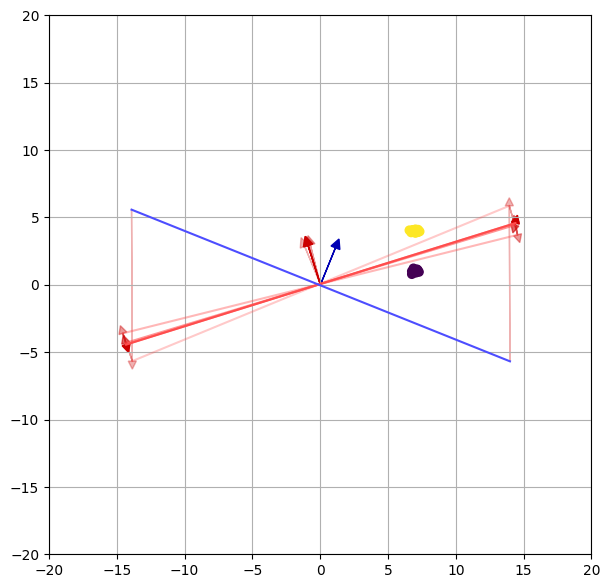

Epoch 2500 | Loss 0.504189 | Acc 96.19% | Task Acc 100.00%


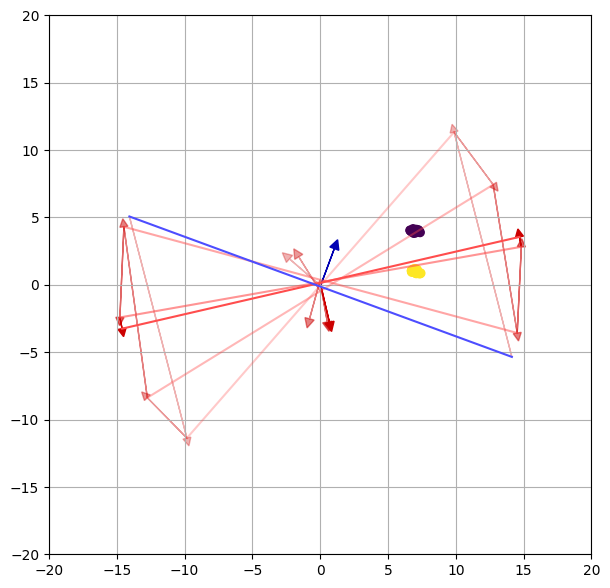

Epoch 2750 | Loss 0.504134 | Acc 96.54% | Task Acc 100.00%


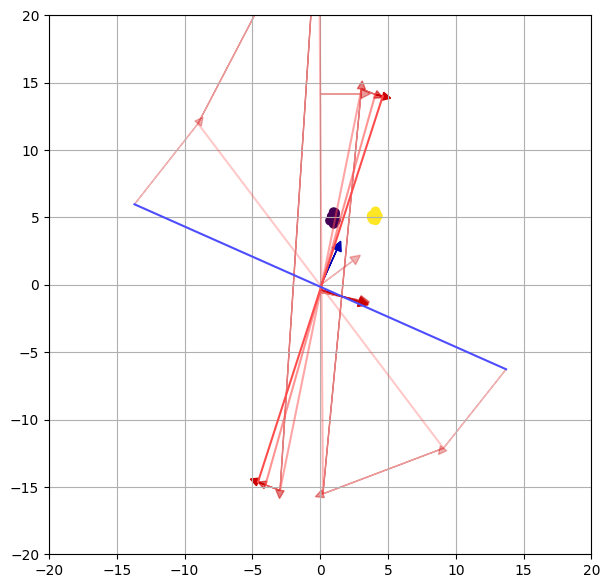

Epoch 3000 | Loss 0.504087 | Acc 96.83% | Task Acc 100.00%


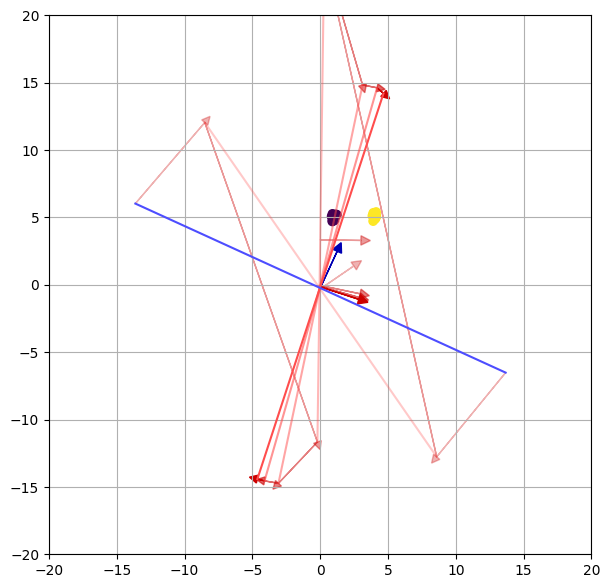

Epoch 3250 | Loss 0.503519 | Acc 97.07% | Task Acc 100.00%


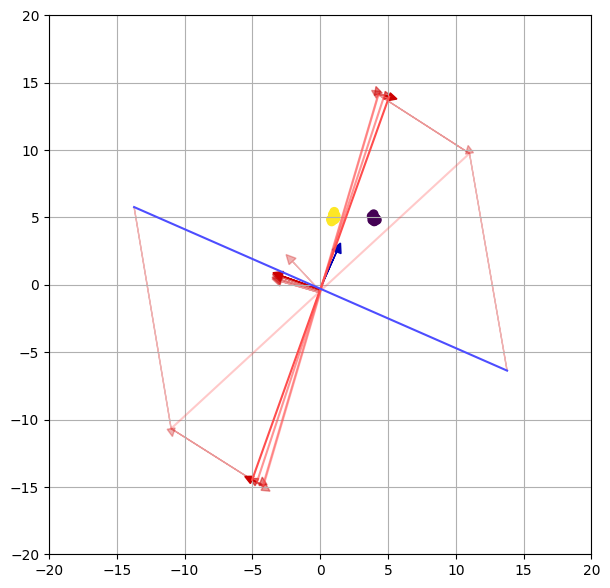

Epoch 3500 | Loss 0.503222 | Acc 97.28% | Task Acc 100.00%


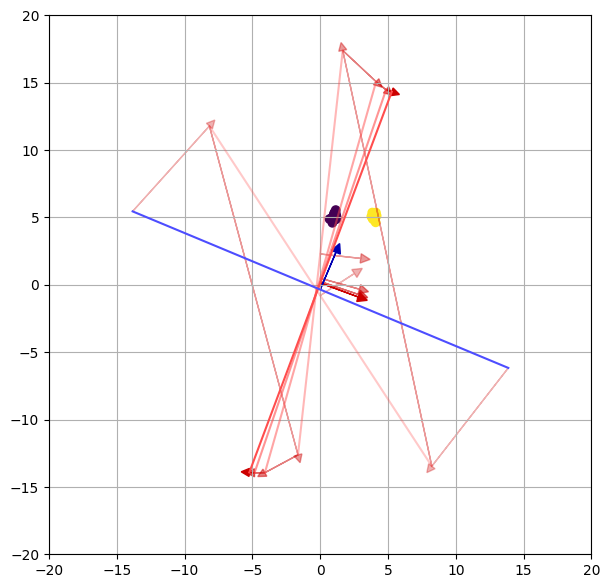

Epoch 3750 | Loss 0.503144 | Acc 97.46% | Task Acc 100.00%


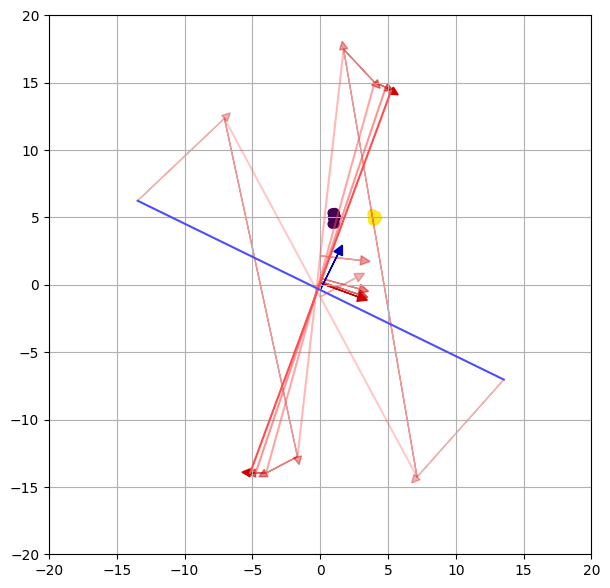

Epoch 4000 | Loss 0.502996 | Acc 97.62% | Task Acc 100.00%


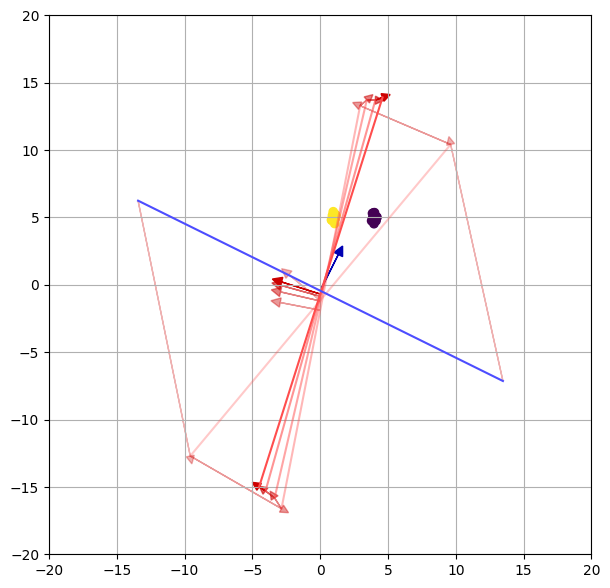

Epoch 4250 | Loss 0.502936 | Acc 97.76% | Task Acc 100.00%


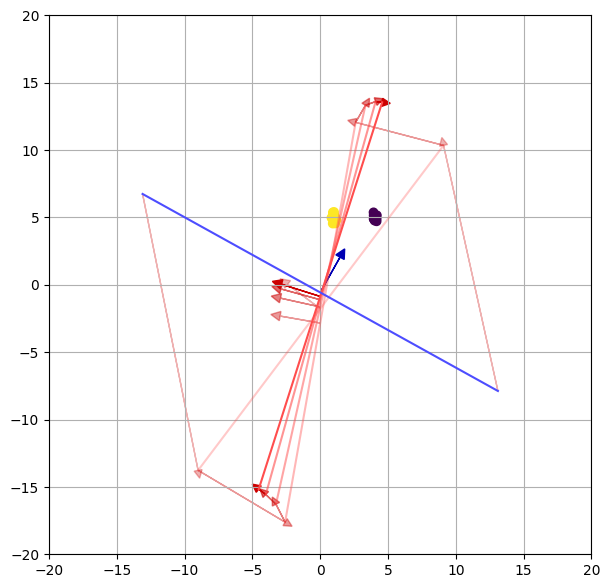

Epoch 4500 | Loss 0.502726 | Acc 97.88% | Task Acc 100.00%


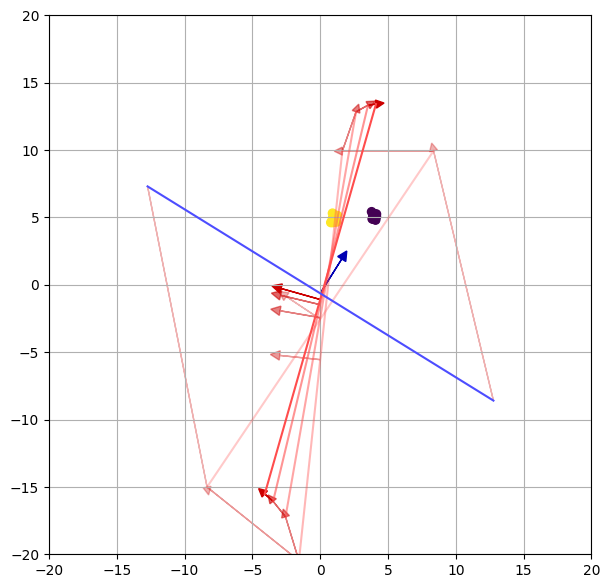

Epoch 4750 | Loss 0.502563 | Acc 98.00% | Task Acc 100.00%


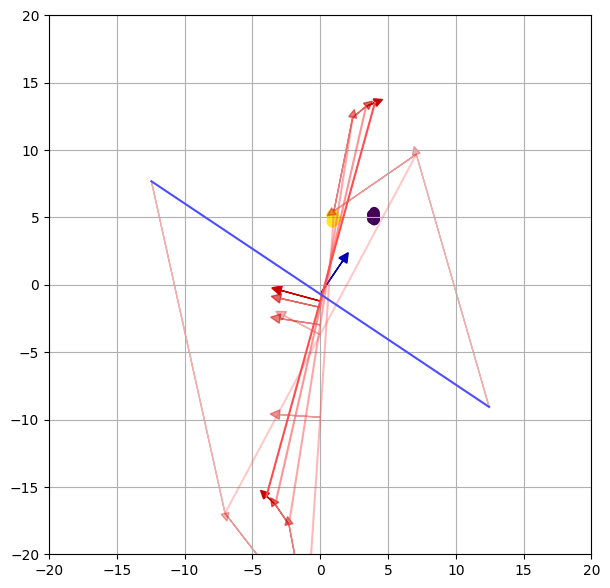

Epoch 5000 | Loss 0.502215 | Acc 98.10% | Task Acc 100.00%


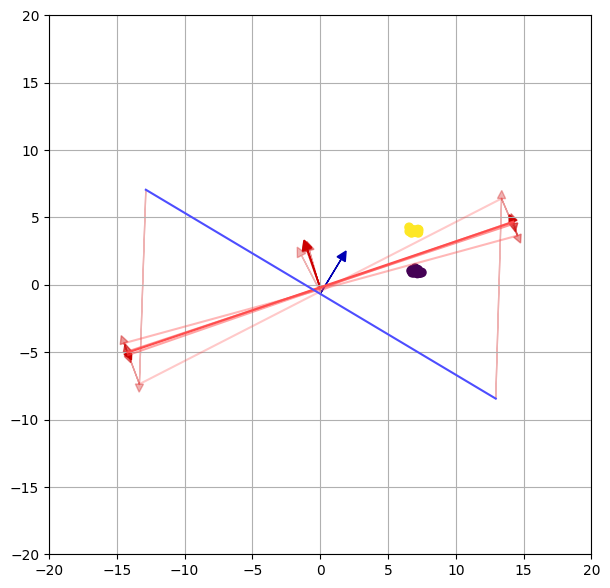

Epoch 5250 | Loss 0.501949 | Acc 98.19% | Task Acc 100.00%


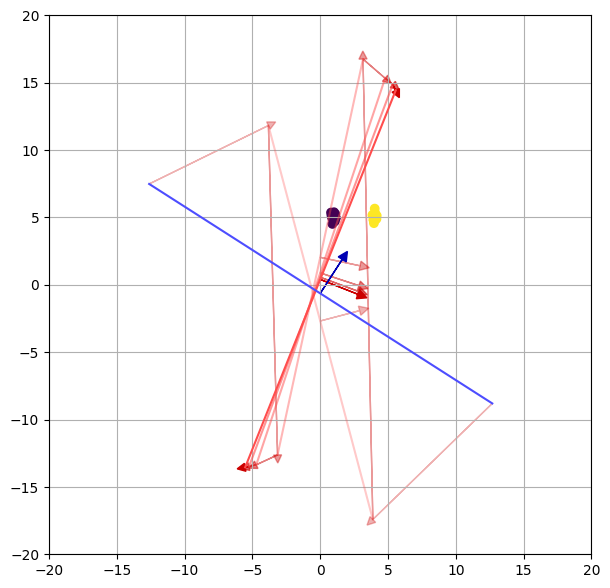

Epoch 5500 | Loss 0.501795 | Acc 98.27% | Task Acc 100.00%


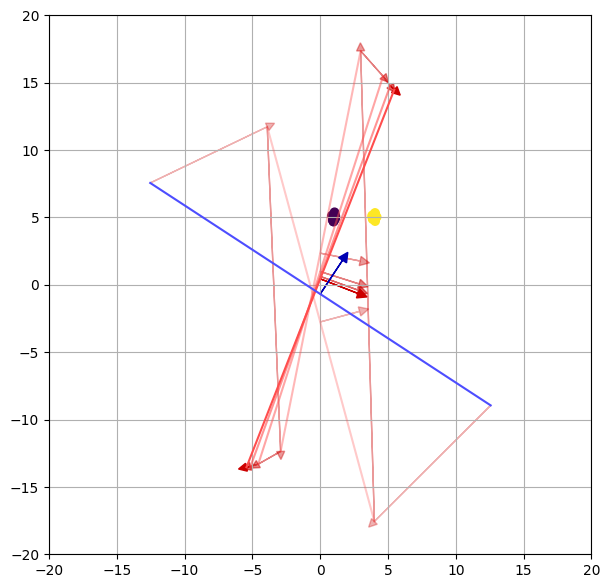

Epoch 5750 | Loss 0.501686 | Acc 98.34% | Task Acc 100.00%


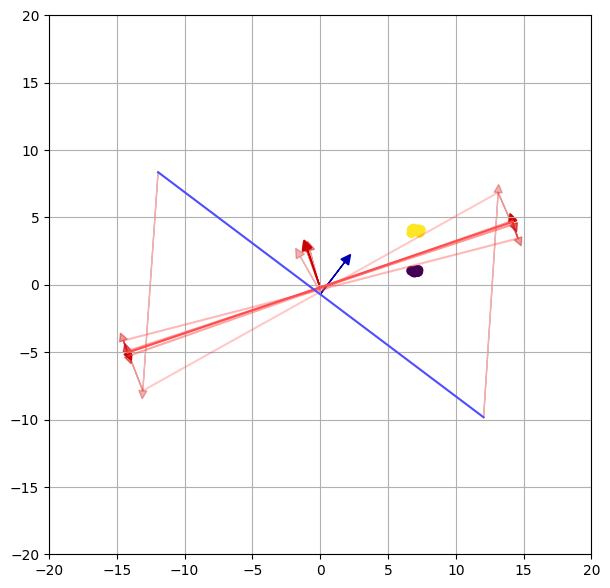

Epoch 6000 | Loss 0.501639 | Acc 98.41% | Task Acc 100.00%


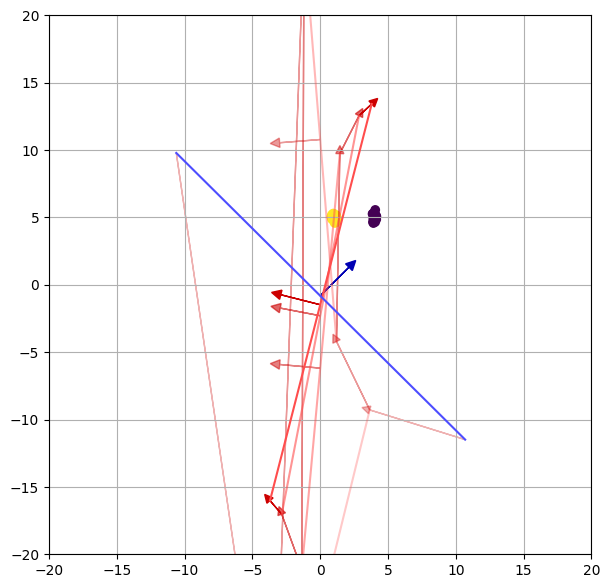

Epoch 6250 | Loss 0.501355 | Acc 98.48% | Task Acc 100.00%


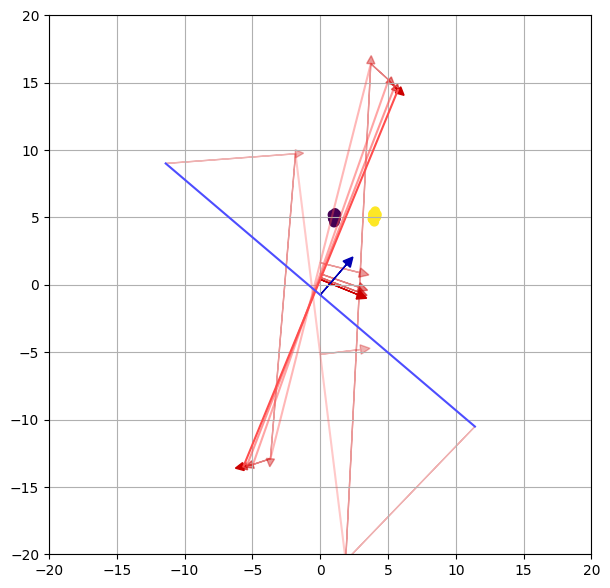

Epoch 6500 | Loss 0.501280 | Acc 98.53% | Task Acc 100.00%


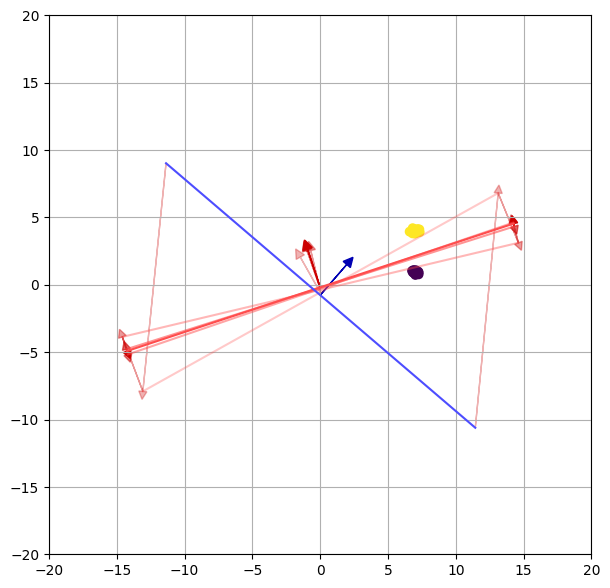

Epoch 6750 | Loss 0.501126 | Acc 98.59% | Task Acc 100.00%


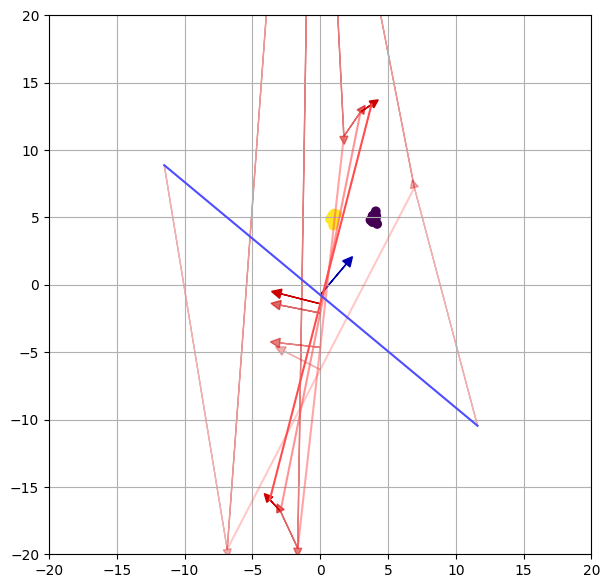

Epoch 7000 | Loss 0.501100 | Acc 98.64% | Task Acc 100.00%


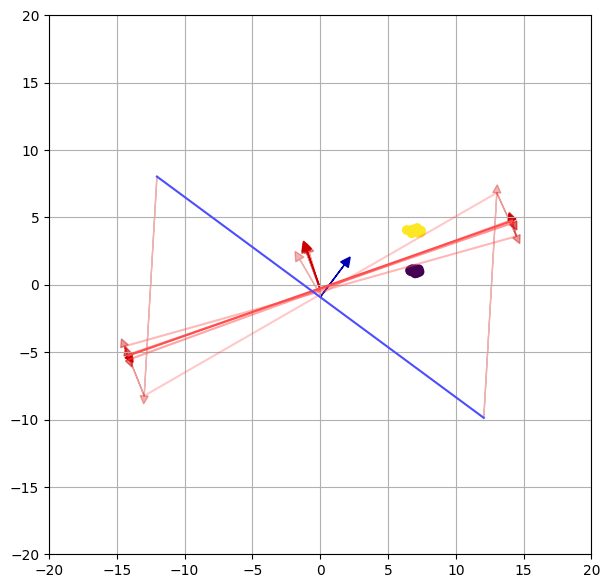

Epoch 7250 | Loss 0.501026 | Acc 98.69% | Task Acc 100.00%


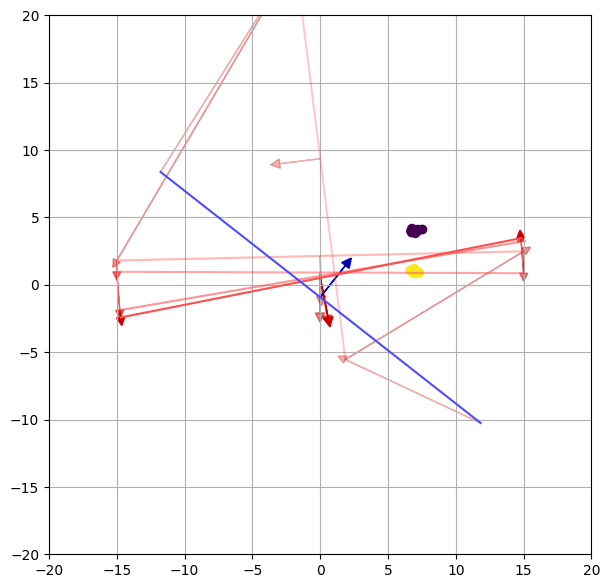

Epoch 7500 | Loss 0.500918 | Acc 98.73% | Task Acc 100.00%


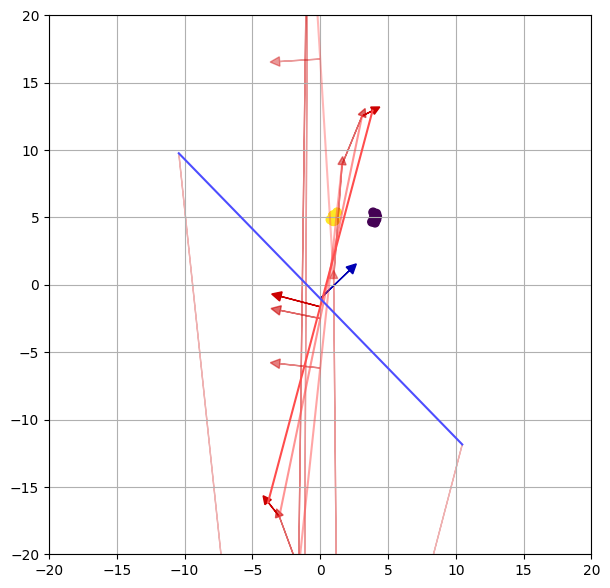

Epoch 7750 | Loss 0.500788 | Acc 98.77% | Task Acc 100.00%


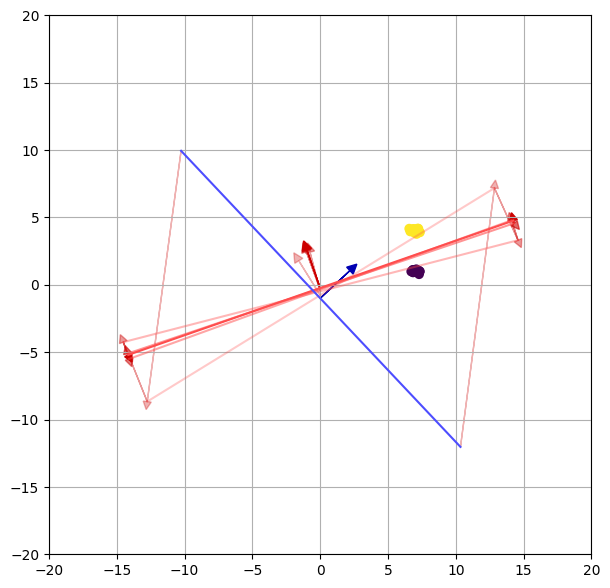

Epoch 8000 | Loss 0.500756 | Acc 98.81% | Task Acc 100.00%


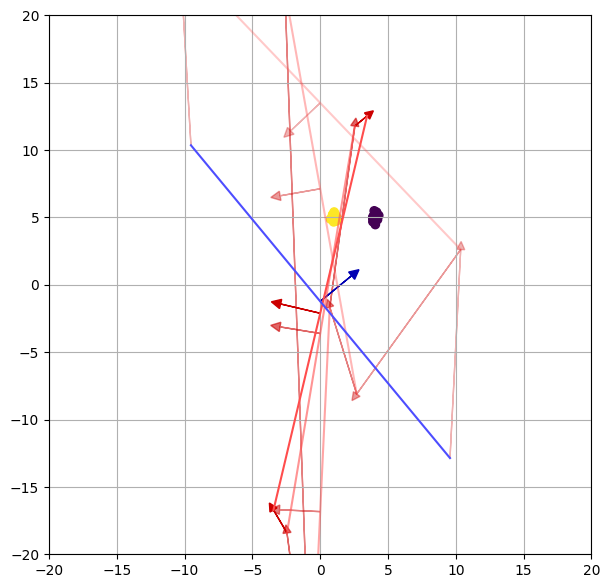

Epoch 8250 | Loss 0.500706 | Acc 98.85% | Task Acc 100.00%


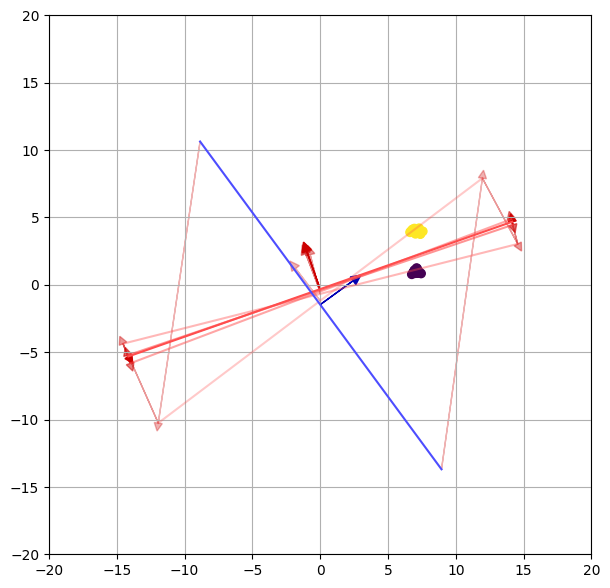

Epoch 8500 | Loss 0.500656 | Acc 98.88% | Task Acc 100.00%


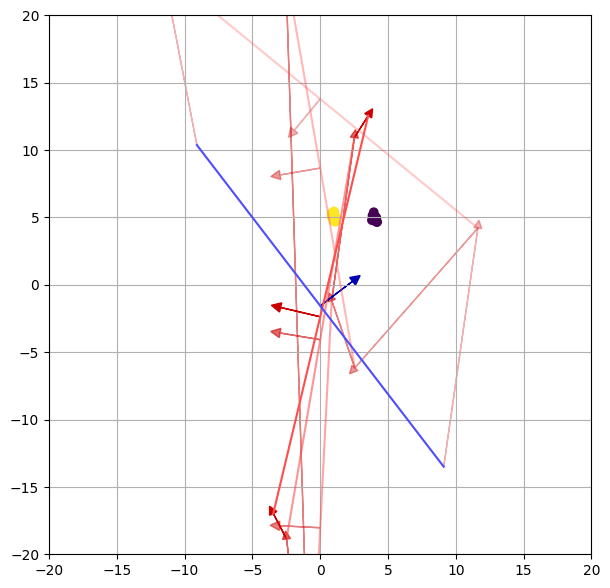

Epoch 8750 | Loss 0.500549 | Acc 98.91% | Task Acc 100.00%


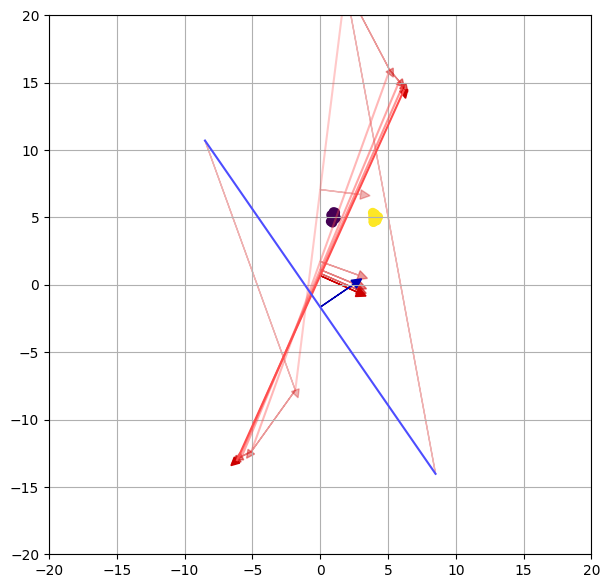

Epoch 9000 | Loss 0.500483 | Acc 98.94% | Task Acc 100.00%


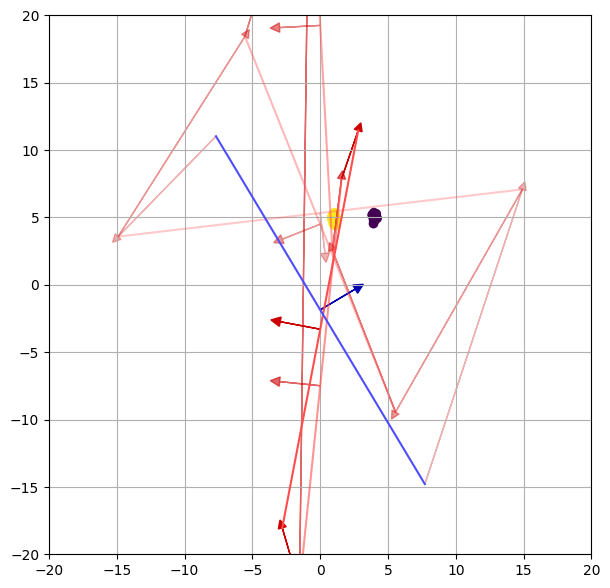

Epoch 9250 | Loss 0.500490 | Acc 98.97% | Task Acc 100.00%


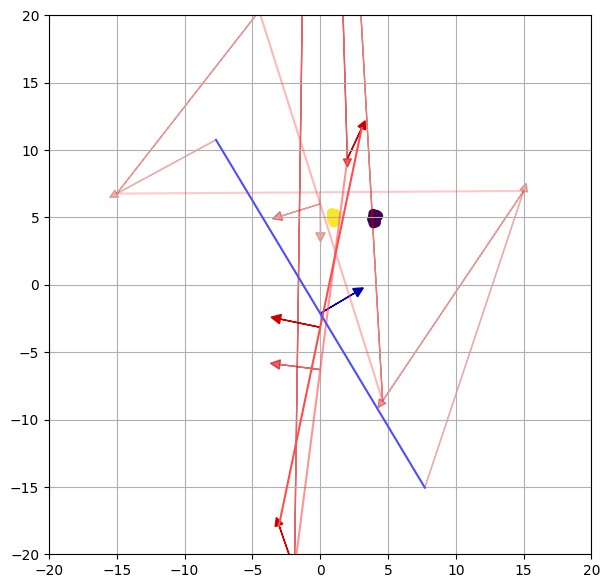

Epoch 9500 | Loss 0.500470 | Acc 99.00% | Task Acc 100.00%


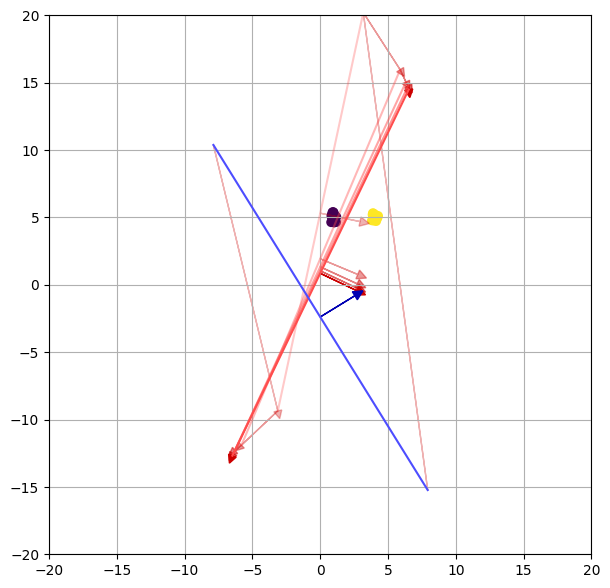

Epoch 9750 | Loss 0.500414 | Acc 99.02% | Task Acc 100.00%


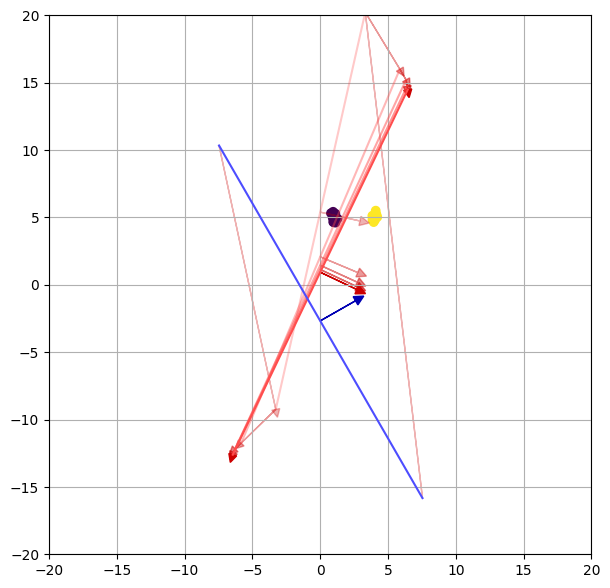

In [67]:
n_tasks = 10000

print_freq = 250
task_count = 0
avg_loss = 0
loss_all = []
acc_all = []
optimizer.zero_grad()

for i in np.arange(n_tasks):
  X, y = make_task(n=20)

  X_support, y_support, X_query, y_query = split_support_query(X, y)

  A, B, C = get_vector(model)

  loss, task_accuracy, positions = model.set_forward_loss(X_support, y_support, X_query, y_query)
  task_accuracy = task_accuracy[-1]
  avg_loss = avg_loss + loss.item()#.data[0]
  loss_all.append(loss)
  acc_all.append(task_accuracy)

  task_count += 1

  if task_count == model.n_task: #MAML update several tasks at one time
      loss_q = torch.stack(loss_all).sum(0)
      loss_q.backward()

      optimizer.step()
      task_count = 0
      loss_all = []

  optimizer.zero_grad()
  if i % print_freq==0:
      acc_all_np  = np.asarray(acc_all)
      acc_mean = np.mean(acc_all_np)
      print('Epoch {:d} | Loss {:f} | Acc {:4.2f}% | Task Acc {:4.2f}%'.format(i, avg_loss/float(i+1), acc_mean, task_accuracy))

  if enable_plotting and i % print_freq == 0:
    figs, axs = plt.subplots(1,1, figsize=(7, 7))
    plt.scatter(X[:,0], X[:,1], c=y)
    axs.set_xlim([-20,20])
    axs.set_ylim([-20,20])

    if plot_decision_boundary:
      scale = 3

      # decision boundary length optimization (by default length of decision boundary is set to 2*15) | START
      x_step = np.absolute(B) * (15 / np.sqrt((np.power(A, 2) + np.power(B, 2))))
      x_arg = np.arange(-x_step, x_step + 0.1, 0.1)

      arr_length1 = np.sqrt(np.power(A, 2) + np.power(B, 2))

      dx = scale*A/arr_length1
      dy = scale*B/arr_length1

      yx = (-A/B)*x_arg-(C/B)
      # decision boundary length optimization (by default length of decision boundary is set to 2*15) | END

      adaptation_arr_start_coords_1 = (x_arg[0], yx[0])
      adaptation_arr_start_coords_2 = (x_arg[-1], yx[-1])

      for param_num, fast_params in enumerate(model.fast_params_list, 1):
        A_fast, B_fast, C_fast = fast_params # get_fast_vector(model)

        # adapted decision boundary length optimization (by default length of decision boundary is set to 2*15) | START
        x_fast_step = np.absolute(B_fast) * (15 / np.sqrt((np.power(A_fast, 2) + np.power(B_fast, 2))))
        x_fast_arg = np.arange(-x_fast_step, x_fast_step + 0.1, 0.1)

        yx_fast = (-A_fast/B_fast)*x_fast_arg-(C_fast/B_fast)

        arr_length2 = np.sqrt(np.power(A_fast, 2) + np.power(B_fast, 2))

        dx_fast = scale*A_fast/arr_length2
        dy_fast = scale*B_fast/arr_length2
        # adapted decision boundary length optimization (by default length of decision boundary is set to 2*15) | END

        alpha = 0.1 * param_num + 0.2 if param_num < model.task_update_num else 1
        head_length=0.6
        head_width=0.6

        if plot_adaptation_arrows:
          arr1_dx = -adaptation_arr_start_coords_1[0] + x_fast_arg[0]
          arr1_dy = -adaptation_arr_start_coords_1[1] + yx_fast[0]
          arr2_dx = -adaptation_arr_start_coords_2[0] + x_fast_arg[-1]
          arr2_dy = -adaptation_arr_start_coords_2[1] + yx_fast[-1]

          plt.arrow(adaptation_arr_start_coords_1[0], adaptation_arr_start_coords_1[1], arr1_dx, arr1_dy, head_width=head_width, head_length=head_length, fc='#cc0000', ec='#cc0000', alpha=alpha)
          plt.arrow(adaptation_arr_start_coords_2[0], adaptation_arr_start_coords_2[1], arr2_dx, arr2_dy, head_width=head_width, head_length=head_length, fc='#cc0000', ec='#cc0000', alpha=alpha)

          adaptation_arr_start_coords_1 = (x_fast_arg[0], yx_fast[0])
          adaptation_arr_start_coords_2 = (x_fast_arg[-1], yx_fast[-1])

        plt.arrow(0, -(C_fast/B_fast), dx_fast, dy_fast, head_width=0.7, head_length=0.7, fc='#cc0000', ec='#cc0000', alpha=alpha)
        plt.plot(x_fast_arg, yx_fast, c='#ff4d4d', alpha=alpha)

      plt.arrow(0, -(C/B), dx, dy, head_width=0.7, head_length=0.7, fc='#0000b3', ec='#0000b3')
      plt.plot(x_arg, yx, c='#4d4dff')

    plt.grid()
    plt.show()

MAML adaptation to all 4 tasks

Task 1 | Loss 0.24152512848377228 | Acc 100.00 | Task Acc [50.0, 100.0, 100.0, 100.0, 100.0, tensor(100.)]
-2.9603450298309326 0.9217661023139954
Task 2 | Loss 0.33909788727760315 | Acc 100.00 | Task Acc [64.99999761581421, 50.0, 55.000001192092896, 100.0, 100.0, tensor(100.)]
-2.9603450298309326 -4.214815616607666
Task 3 | Loss 0.3769098073244095 | Acc 100.00 | Task Acc [50.0, 69.9999988079071, 100.0, 100.0, 100.0, tensor(100.)]
-2.9603450298309326 -0.499310702085495
Task 4 | Loss 0.4013514339923859 | Acc 100.00 | Task Acc [50.0, 100.0, 100.0, 100.0, 100.0, tensor(100.)]
-2.9603450298309326 0.6252549290657043


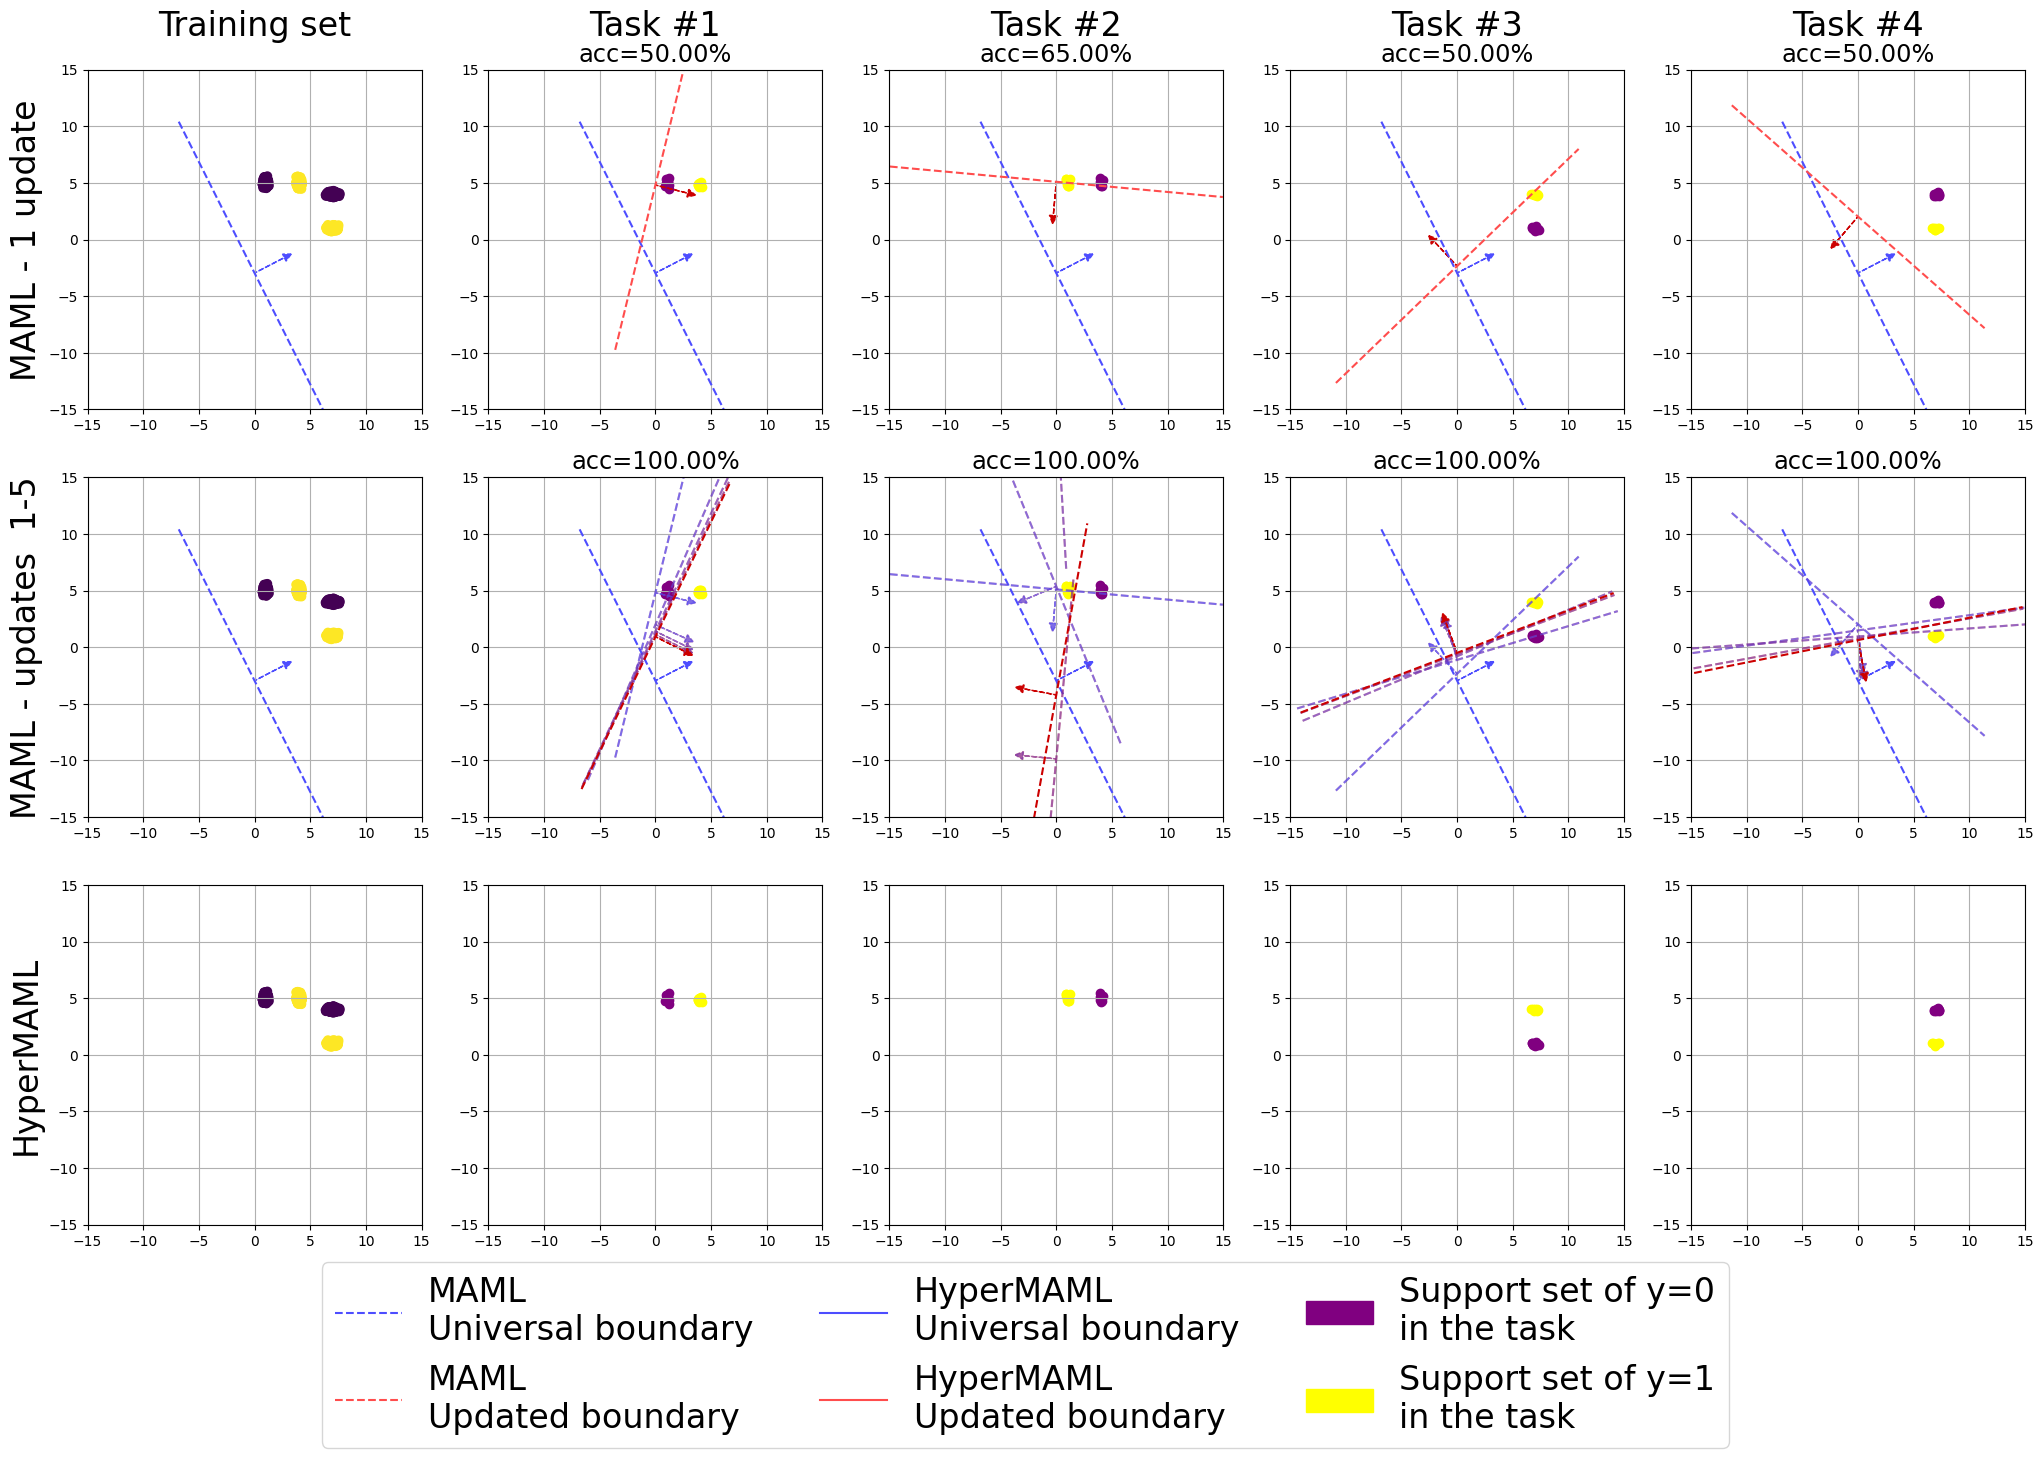

In [68]:
n = 20
task_count = 0
avg_loss = 0
loss_all = []
acc_all = []
np.random.seed(seed)
tasks = [sample_task_I(n, False), sample_task_I(n, True), sample_task_II(n, False), sample_task_II(n, True)]
plot_decision_boundary = True
plot_adaptation_arrows = True

MAML_ADAPT_HISTORY = []

fig, ax = plt.subplots(
    nrows=3, #4,#model.task_update_num,
    ncols=len(tasks)+1,
    figsize=((len(tasks)+1)*5, 3*5))

for axs in ax:
  for a in axs:
      a.set_xlim([-15,15])
      a.set_ylim([-15,15])
      a.grid()

legend_items = []



for axs in ax:
  axs[0].scatter(X_all[:,0], X_all[:,1], c=y_all)#, alpha =0.02)

fontsize= 24
ax[0,0].text(0.5,1.1, f"Training set", transform=ax[0,0].transAxes, horizontalalignment='center', fontsize=fontsize)

ax[0, 0].set_ylabel("MAML - 1 update", rotation=90, fontsize=fontsize)
ax[1, 0].set_ylabel(f"MAML - updates  1-{len(model.fast_params_list)}", rotation=90, fontsize=fontsize)
ax[2, 0].set_ylabel("HyperMAML", rotation=90, fontsize=fontsize)

A, B, C = get_vector(model)
arr_length1 = np.sqrt(np.power(A, 2) + np.power(B, 2))

scale = 3
dx = scale*A/arr_length1
dy = scale*B/arr_length1
x_step = np.absolute(B) * (15 / np.sqrt((np.power(A, 2) + np.power(B, 2))))
x_arg = np.arange(-x_step, x_step + 0.1, 0.1)
yx = (-A/B)*x_arg-(C/B)

params = {'text.usetex': False}
plt.rcParams.update(params)

for axs in ax[:-1]:
  for a in axs:

    a.plot(x_arg, yx, c='#4d4dff', label="Universal weights", linestyle="--")
    a.arrow(0, -(C/B), dx, dy, head_width=0.7, head_length=0.7, fc='#4d4dff', ec='#4d4dff', linestyle="--")

for i, task in enumerate(tasks, 1):
  task_history = dict()
  X, y = task

  X_support, y_support, X_query, y_query = split_support_query(X, y)

  task_history["task"] = X_support, y_support, X_query, y_query


  loss, task_accuracies, positions = model.set_forward_loss(X_support, y_support, X_query, y_query)

  task_accuracy = task_accuracies[-1]
  avg_loss = avg_loss + loss.item()
  loss_all.append(loss)
  acc_all.append(task_accuracy)


  task_count += 1

  acc_all_np  = np.asarray(acc_all)
  acc_mean = np.mean(acc_all_np)
  print(f'Task {i} | Loss {avg_loss/float(i+1)} | Acc {acc_mean:.2f} | Task Acc {task_accuracies}')

  # figs, axs = plt.subplots(1,1, figsize=(7, 7))

  ax[0,i].text(0.5,1.1, f"Task #{i}", transform=ax[0,i].transAxes, horizontalalignment='center', fontsize=fontsize)

  # ax[0, i].set_title(f"Task #{i}", fontsize=16)


  for a in ax[:, i]:
    ys0 = y_support==0
    yq0 = y_query == 0
    a.scatter(X_support[ys0,0], X_support[ys0,1], c="purple", marker="o")
    a.scatter(X_support[~ys0,0], X_support[~ys0,1], c="yellow", marker="o")

    # a.scatter(X_query[yq0,0], X_query[yq0,1], c="#a0aadf", marker=".")
    # a.scatter(X_query[~yq0,0], X_query[~yq0,1], c="#00b300", marker=".")

  # ax[0, 0].set_ylabel("Sampled task", rotation=90, fontsize=16)



  if plot_decision_boundary:

    # decision boundary length optimization (by default length of decision boundary is set to 2*15) | START




    # decision boundary length optimization (by default length of decision boundary is set to 2*15) | END

    adaptation_arr_start_coords_1 = (x_arg[0], yx[0])
    adaptation_arr_start_coords_2 = (x_arg[-1], yx[-1])

    params_to_plot = [
        # (1, model.fast_params_list[0]),
        (len(model.fast_params_list), model.fast_params_list[-1])
    ]

    for (param_num, fast_params) in enumerate(model.fast_params_list, 1):
      if param_num == 1:
        a = ax[0, i]
      else:
        a = ax[1, i]
      # if param_num not in [1, 5]:
      #   continue

      A_fast, B_fast, C_fast = fast_params # get_fast_vector(model)

      # adapted decision boundary length optimization (by default length of decision boundary is set to 2*15) | START
      x_fast_step = np.absolute(B_fast) * (15 / np.sqrt((np.power(A_fast, 2) + np.power(B_fast, 2))))
      x_fast_arg = np.arange(-x_fast_step, x_fast_step + 0.1, 0.1)

      yx_fast = (-A_fast/B_fast)*x_fast_arg-(C_fast/B_fast)

      arr_length2 = np.sqrt(np.power(A_fast, 2) + np.power(B_fast, 2))

      dx_fast = scale*A_fast/arr_length2
      dy_fast = scale*B_fast/arr_length2
      # adapted decision boundary length optimization (by default length of decision boundary is set to 2*15) | END

      alpha = 0.1 * param_num + 0.2 if param_num < model.task_update_num else 1
      head_length=0.6
      head_width=0.6

      if plot_adaptation_arrows:
        arr1_dx = -adaptation_arr_start_coords_1[0] + x_fast_arg[0]
        arr1_dy = -adaptation_arr_start_coords_1[1] + yx_fast[0]
        arr2_dx = -adaptation_arr_start_coords_2[0] + x_fast_arg[-1]
        arr2_dy = -adaptation_arr_start_coords_2[1] + yx_fast[-1]

        # ax[param_num, i].arrow(adaptation_arr_start_coords_1[0], adaptation_arr_start_coords_1[1], arr1_dx, arr1_dy, head_width=head_width, head_length=head_length, fc='#cc0000', ec='#cc0000', alpha=alpha)
        # ax[param_num, i].arrow(adaptation_arr_start_coords_2[0], adaptation_arr_start_coords_2[1], arr2_dx, arr2_dy, head_width=head_width, head_length=head_length, fc='#cc0000', ec='#cc0000', alpha=alpha)

        adaptation_arr_start_coords_1 = (x_fast_arg[0], yx_fast[0])
        adaptation_arr_start_coords_2 = (x_fast_arg[-1], yx_fast[-1])

      label = None if param_num < model.task_update_num else "Updated weights"


      ax[1, i].arrow(0, -(C_fast/B_fast), dx_fast, dy_fast, head_width=0.7, head_length=0.7, fc='#cc0000', ec='#cc0000', alpha=alpha, linestyle="--")
      ax[1, i].plot(x_fast_arg, yx_fast, c='#cc0000', alpha=alpha, label=label, linestyle="--")
      ax[1, i].arrow(0, -(C_fast/B_fast), dx_fast, dy_fast, head_width=0.7, head_length=0.7, fc='#4d4dff', ec='#4d4dff', alpha=1-alpha, linestyle="--")
      ax[1, i].plot(x_fast_arg, yx_fast, c='#4d4dff', alpha=1-alpha, label=label, linestyle="--")

      ttl = f"acc={task_accuracies[param_num-1]:.2f}%"
      ax[1, i].set_title(ttl, fontsize="xx-large")

      if param_num==1:
        ax[0, i].arrow(0, -(C_fast/B_fast), dx_fast, dy_fast, head_width=0.7, head_length=0.7, fc='#cc0000', ec='#cc0000', alpha=1, linestyle="--")
        ax[0, i].plot(x_fast_arg, yx_fast, c='#ff4d4d', alpha=1, label=label, linestyle="--")
        ax[0, i].set_title(ttl, fontsize="xx-large")


    print(f'{-(C/B)} {-(C_fast/B_fast)}')




# plt.legend()
  # plt.grid()
lgd = fig.legend(handles=[
    Line2D([0,1],[0,1],linestyle='--', color='#4d4dff', label="MAML\nUniversal boundary"),
    Line2D([0,1],[0,1],linestyle='--', color='#ff4d4d', label="MAML\nUpdated boundary"),
    Line2D([0,1],[0,1],linestyle='-', color='#4d4dff', label="HyperMAML\nUniversal boundary"),
    Line2D([0,1],[0,1],linestyle='-', color='#ff4d4d', label="HyperMAML\nUpdated boundary"),

    mpatches.Patch(color='purple', label="Support set of y=0\nin the task"),
    mpatches.Patch(color="yellow", label="Support set of y=1\nin the task"),
    #ff4d4d
    # mpatches.Patch(color='#a0aadf', label="Query objects with c=0 in the task"),
    #     mpatches.Patch(color="#00b300", label="Query objects with c=1 in the task"),



], ncol=3, loc="lower center", fontsize=24, bbox_to_anchor=(0.5,-0.05))#, bbox_to_anchor=(0.45, -0.1), )# fontsize=16,)# loc='upper right', bbox_to_anchor=(1.3, 0.5))

# fig.subplots_adjust(right=1.1)
# fig.savefig("fig.png", bbox_extra_artists=[lgd], bbox_inches="tight")
# fig.subplots_adjust(right=0.95)
# for axs in ax[2:model.task_update_num]:
#   for a in axs:
#     fig.delaxes(a)
# plt.show()

# fig

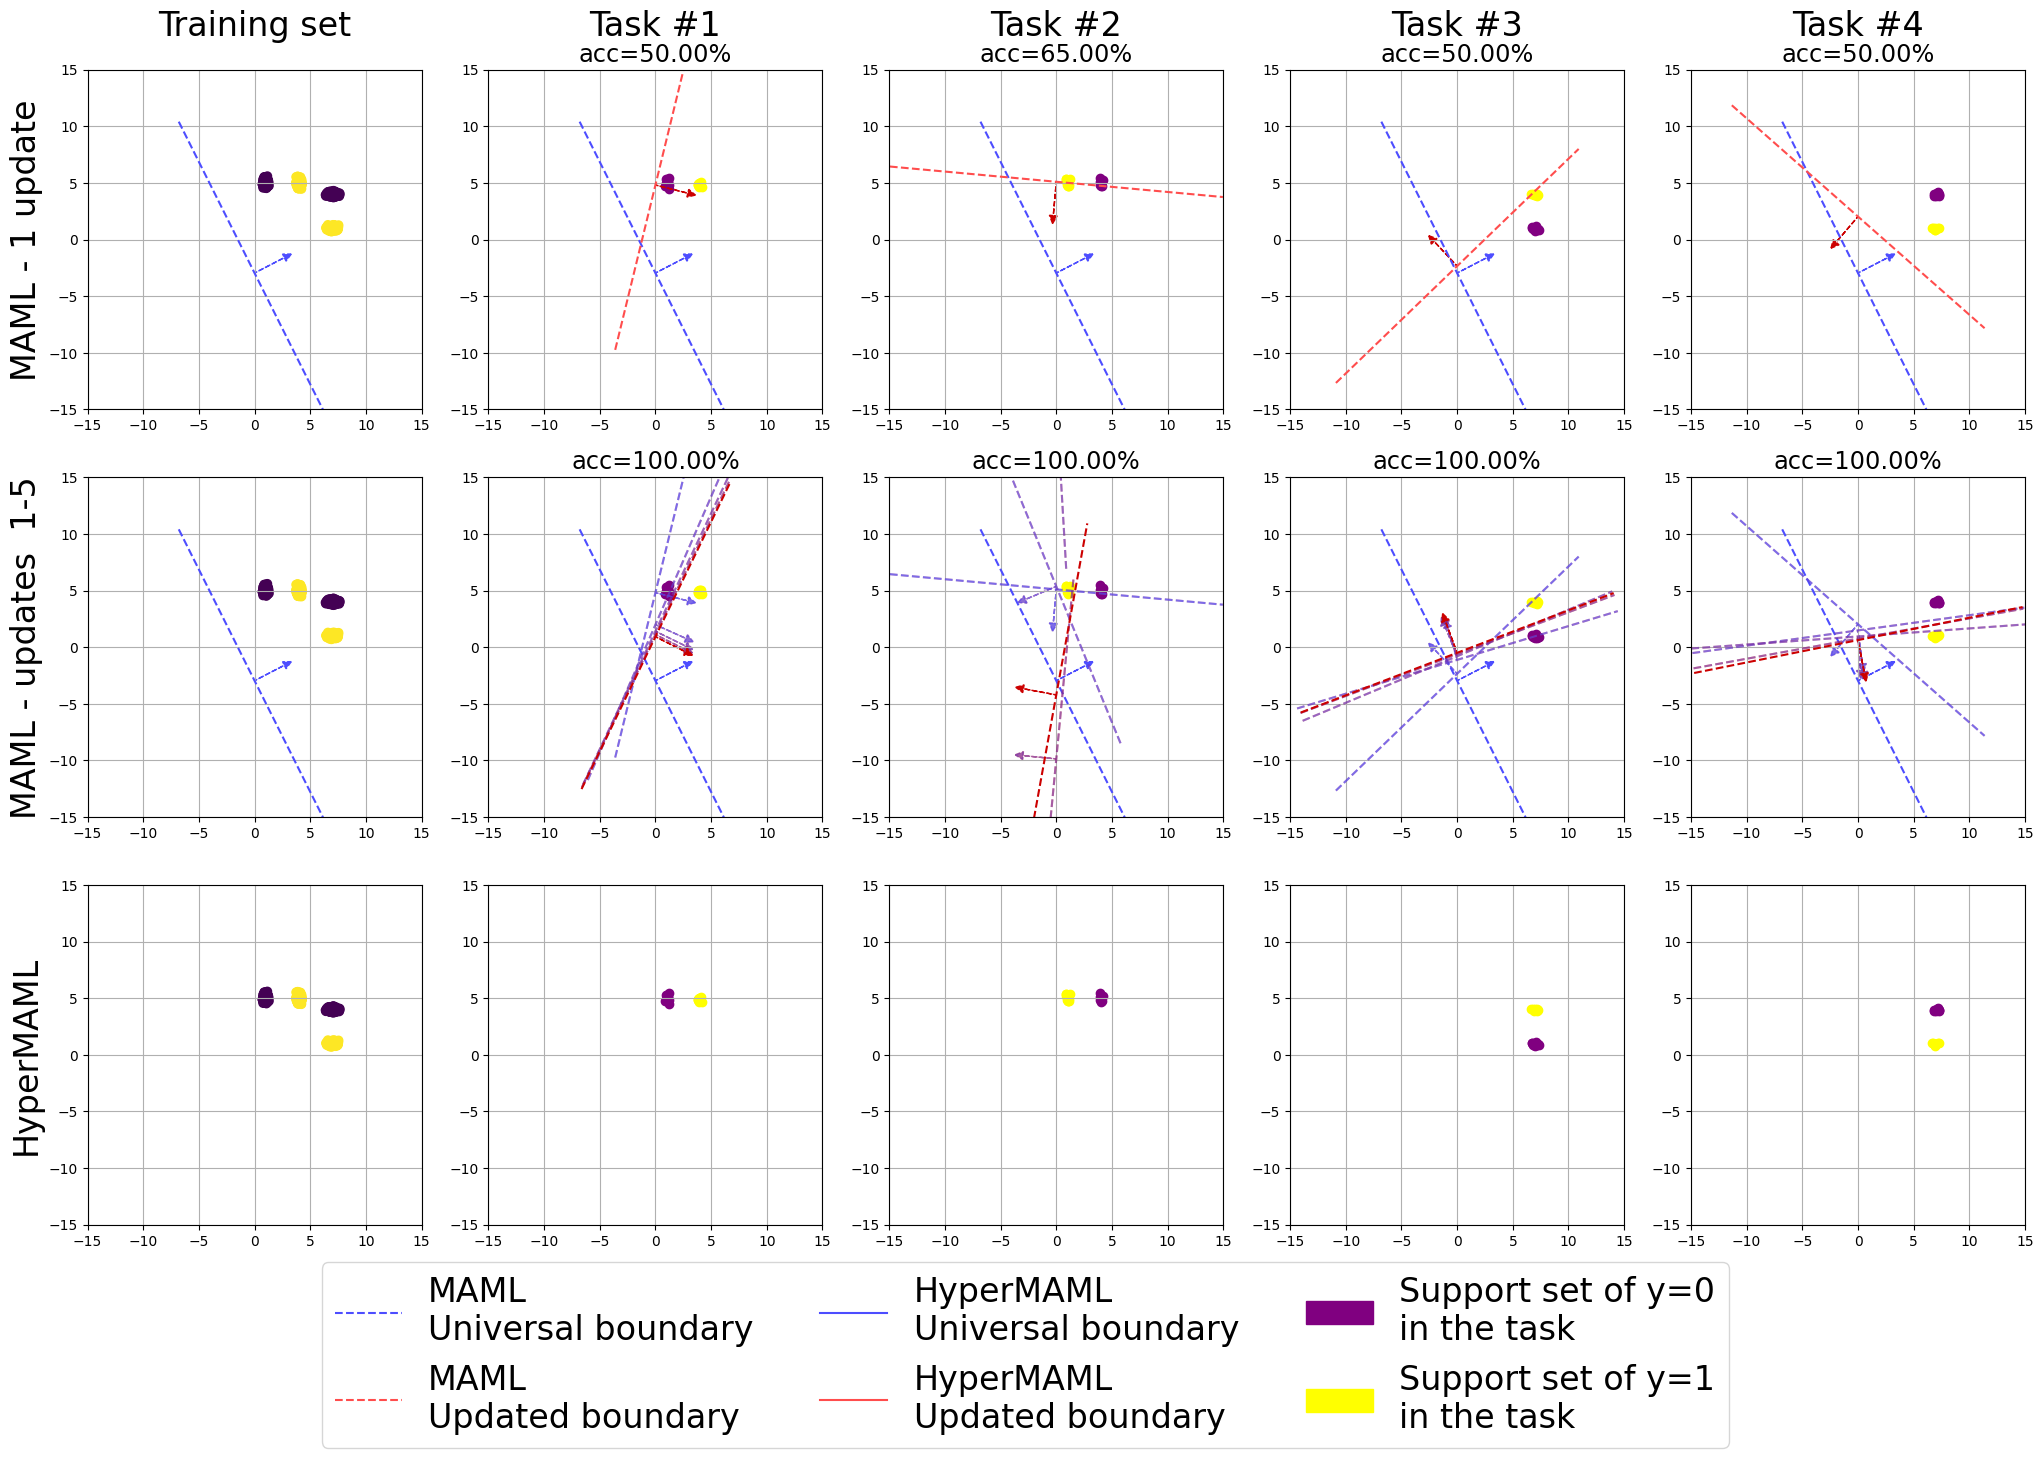

In [69]:
fig

Epoch 0 | Loss 0.483050 | Acc 91.67% | Task Acc 100.00%
-2.9603450298309326 0.9217661023139954


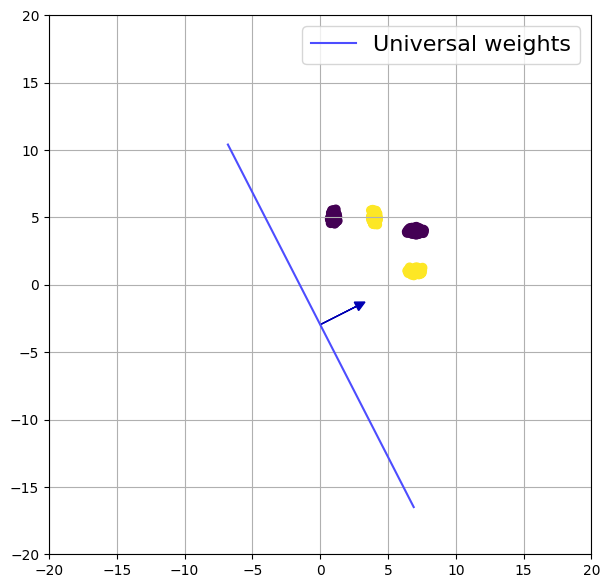

Epoch 1 | Loss 0.508647 | Acc 85.00% | Task Acc 100.00%
-2.9603450298309326 -4.214815616607666


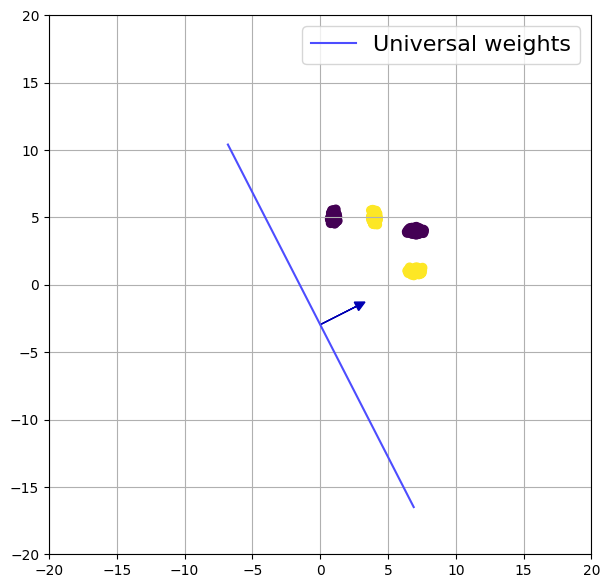

Epoch 2 | Loss 0.502546 | Acc 85.56% | Task Acc 100.00%
-2.9603450298309326 -0.499310702085495


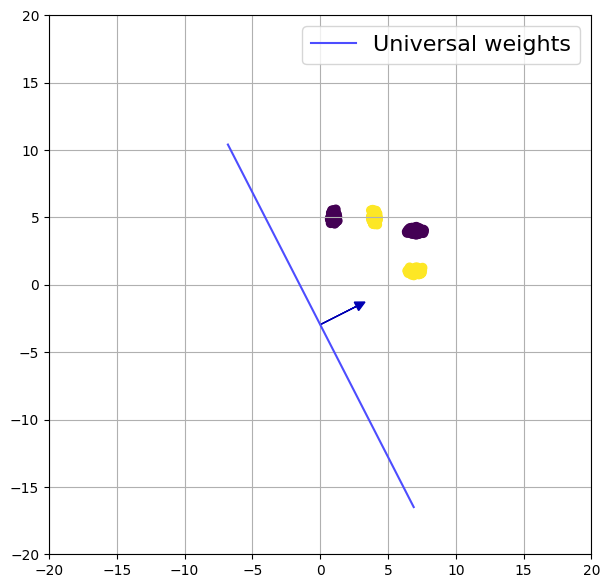

Epoch 3 | Loss 0.501689 | Acc 87.08% | Task Acc 100.00%
-2.9603450298309326 0.6252549290657043


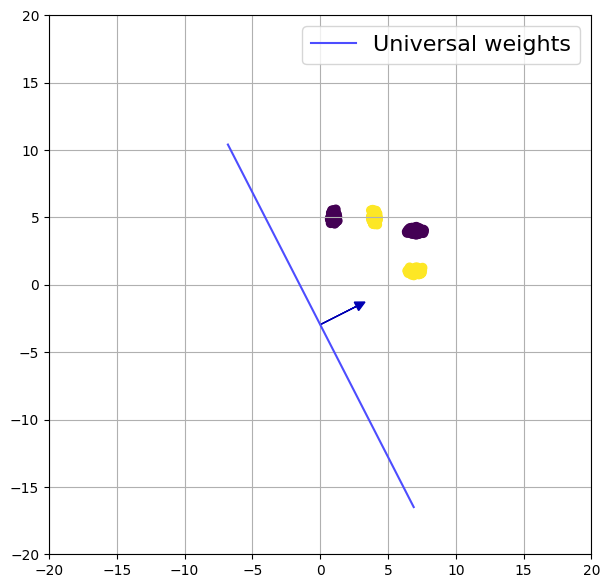

In [70]:
n = 20
task_count = 0
avg_loss = 0
loss_all = []
acc_all = []
np.random.seed(seed)
tasks = [sample_task_I(n, False), sample_task_I(n, True), sample_task_II(n, False), sample_task_II(n, True)]
plot_decision_boundary = True

for i, task in enumerate(tasks):
  X, y = task

  X_support, y_support, X_query, y_query = split_support_query(X, y)

  A, B, C = get_vector(model)

  loss, task_accuracy, positions = model.set_forward_loss(X_support, y_support, X_query, y_query)

  avg_loss = avg_loss + loss.item()
  loss_all.append(loss)
  acc_all.append(task_accuracy)

  task_count += 1

  acc_all_np  = np.asarray(acc_all)
  acc_mean = np.mean(acc_all_np)
  print('Epoch {:d} | Loss {:f} | Acc {:4.2f}% | Task Acc {:4.2f}%'.format(i, avg_loss/float(i+1), acc_mean, task_accuracy[-1]))

  figs, axs = plt.subplots(1,1, figsize=(7, 7))
  # plt.scatter(X[:,0], X[:,1], c=y)
  plt.scatter(X_all[:,0], X_all[:,1], c=y_all, alpha =1)
  axs.set_xlim([-20,20])
  axs.set_ylim([-20,20])

  if plot_decision_boundary:
    A_fast, B_fast, C_fast = get_fast_vector(model)

    scale = 3

    x_step = np.absolute(B) * (15 / np.sqrt((np.power(A, 2) + np.power(B, 2))))
    x_arg = np.arange(-x_step, x_step + 0.1, 0.1)

    x_fast_step = np.absolute(B_fast) * (15 / np.sqrt((np.power(A_fast, 2) + np.power(B_fast, 2))))
    x_fast_arg = np.arange(-x_fast_step, x_fast_step + 0.1, 0.1)

    yx_fast = (-A_fast/B_fast)*x_fast_arg-(C_fast/B_fast)
    yx = (-A/B)*x_arg-(C/B)

    arr_length1 = np.sqrt(np.power(A, 2) + np.power(B, 2))
    arr_length2 = np.sqrt(np.power(A_fast, 2) + np.power(B_fast, 2))

    dx = scale*A/arr_length1
    dy = scale*B/arr_length1
    dx_fast = scale*A_fast/arr_length2
    dy_fast = scale*B_fast/arr_length2

    plt.arrow(0, -(C/B), dx, dy, head_width=0.7, head_length=0.7, fc='#0000b3', ec='#0000b3')
    # plt.arrow(0, -(C_fast/B_fast), dx_fast, dy_fast, head_width=0.7, head_length=0.7, fc='#cc0000', ec='#cc0000')
    print(f'{-(C/B)} {-(C_fast/B_fast)}')
    plt.plot(x_arg, yx, c='#4d4dff', label="Universal weights")
    # plt.plot(x_fast_arg, yx_fast, c='#ff4d4d', label="Updated weights")

  plt.grid()
  plt.legend(fontsize=16, loc='upper right')
  plt.show()

Epoch 0 | Loss 0.476547 | Acc 91.67% | Task Acc 100.00%
-2.9603450298309326 0.9042409658432007


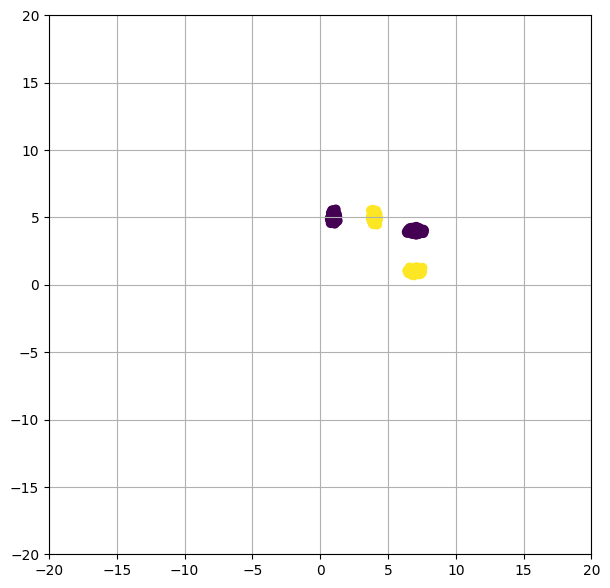

Epoch 1 | Loss 0.505952 | Acc 83.75% | Task Acc 100.00%
-2.9603450298309326 -4.430930137634277


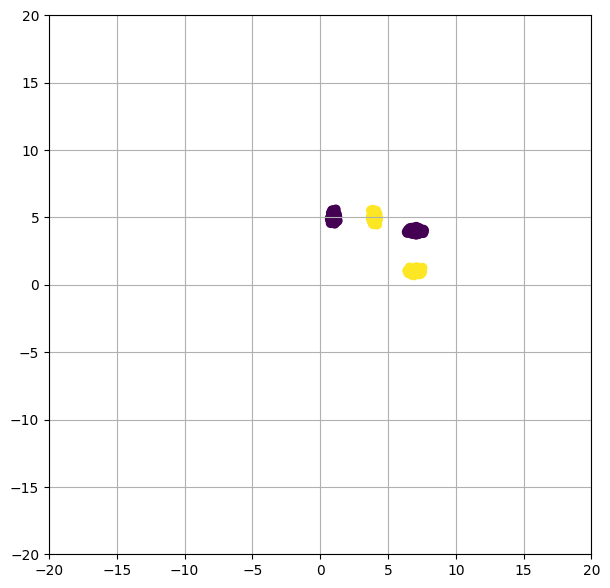

Epoch 2 | Loss 0.499555 | Acc 85.00% | Task Acc 100.00%
-2.9603450298309326 -0.5024585723876953


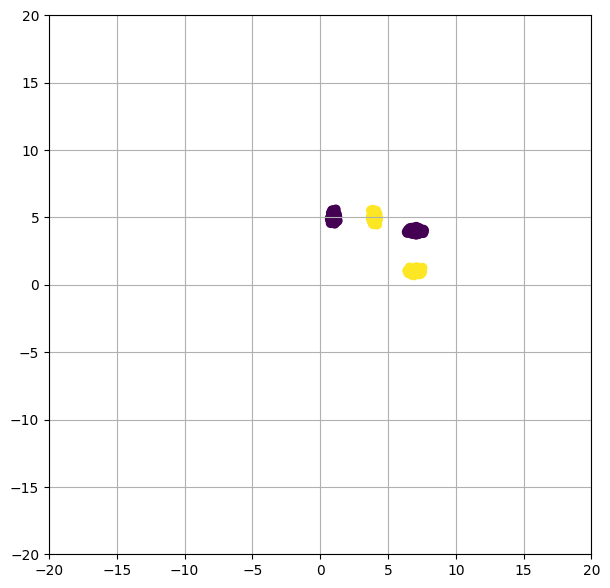

Epoch 3 | Loss 0.496680 | Acc 86.67% | Task Acc 100.00%
-2.9603450298309326 0.5875694155693054


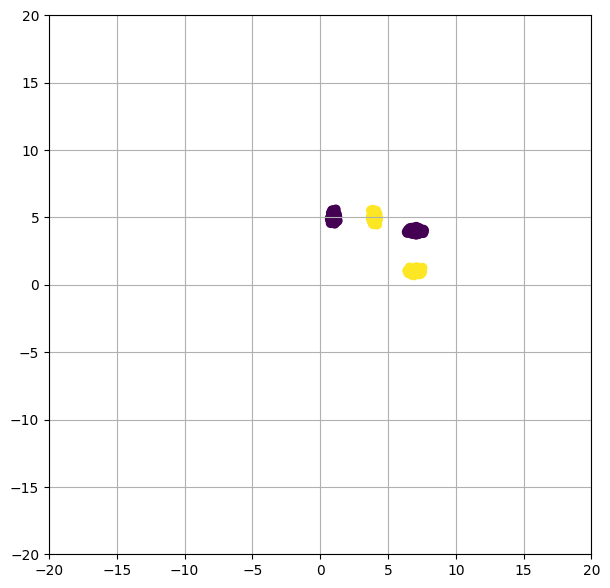

In [71]:
n = 20
task_count = 0
avg_loss = 0
loss_all = []
acc_all = []
tasks = [sample_task_I(n, False), sample_task_I(n, True), sample_task_II(n, False), sample_task_II(n, True)]
plot_decision_boundary = True

for i, task in enumerate(tasks):
  X, y = task

  X_support, y_support, X_query, y_query = split_support_query(X, y)

  A, B, C = get_vector(model)

  loss, task_accuracy, positions = model.set_forward_loss(X_support, y_support, X_query, y_query)

  avg_loss = avg_loss + loss.item()
  loss_all.append(loss)
  acc_all.append(task_accuracy)

  task_count += 1

  acc_all_np  = np.asarray(acc_all)
  acc_mean = np.mean(acc_all_np)
  print('Epoch {:d} | Loss {:f} | Acc {:4.2f}% | Task Acc {:4.2f}%'.format(i, avg_loss/float(i+1), acc_mean, task_accuracy[-1]))

  figs, axs = plt.subplots(1,1, figsize=(7, 7))
  # plt.scatter(X[:,0], X[:,1], c=y)
  plt.scatter(X_all[:,0], X_all[:,1], c=y_all, alpha =1)
  axs.set_xlim([-20,20])
  axs.set_ylim([-20,20])

  if plot_decision_boundary:
    A_fast, B_fast, C_fast = get_fast_vector(model)

    scale = 3

    x_step = np.absolute(B) * (15 / np.sqrt((np.power(A, 2) + np.power(B, 2))))
    x_arg = np.arange(-x_step, x_step + 0.1, 0.1)

    x_fast_step = np.absolute(B_fast) * (15 / np.sqrt((np.power(A_fast, 2) + np.power(B_fast, 2))))
    x_fast_arg = np.arange(-x_fast_step, x_fast_step + 0.1, 0.1)

    yx_fast = (-A_fast/B_fast)*x_fast_arg-(C_fast/B_fast)
    yx = (-A/B)*x_arg-(C/B)

    arr_length1 = np.sqrt(np.power(A, 2) + np.power(B, 2))
    arr_length2 = np.sqrt(np.power(A_fast, 2) + np.power(B_fast, 2))

    dx = scale*A/arr_length1
    dy = scale*B/arr_length1
    dx_fast = scale*A_fast/arr_length2
    dy_fast = scale*B_fast/arr_length2

    plt.arrow(0, -(C/B), dx, dy, head_width=0.7, head_length=0.7, fc='#0000b3', ec='#0000b3', alpha =0)
    plt.arrow(0, -(C_fast/B_fast), dx_fast, dy_fast, head_width=0.7, head_length=0.7, fc='#cc0000', ec='#cc0000', alpha =0)
    print(f'{-(C/B)} {-(C_fast/B_fast)}')
    plt.plot(x_arg, yx, c='#4d4dff', alpha =0)
    plt.plot(x_fast_arg, yx_fast, c='#ff4d4d', alpha =0)

  plt.grid()
  plt.show()

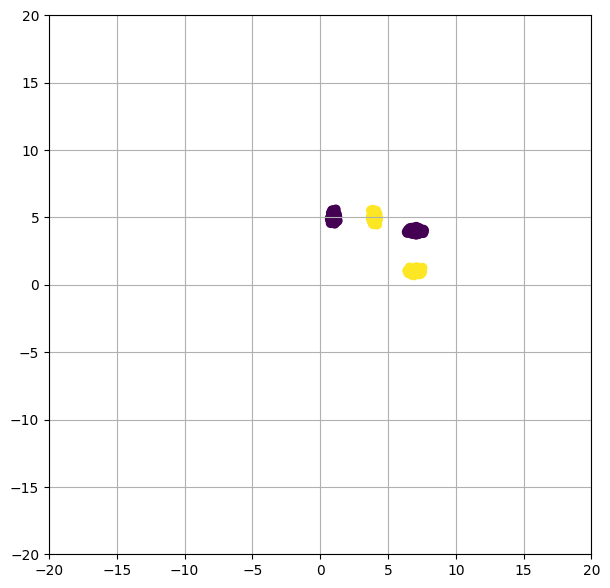

In [72]:
figs, axs = plt.subplots(1,1, figsize=(7, 7))
# plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(X_all[:,0], X_all[:,1], c=y_all, alpha =1)
axs.set_xlim([-20,20])
axs.set_ylim([-20,20])
# plt.axis("equal")
plt.grid()
plt.show()

Epoch 0 | Loss 0.479583 | Acc 90.83% | Task Acc 100.00%
-2.9603450298309326 0.9471021890640259


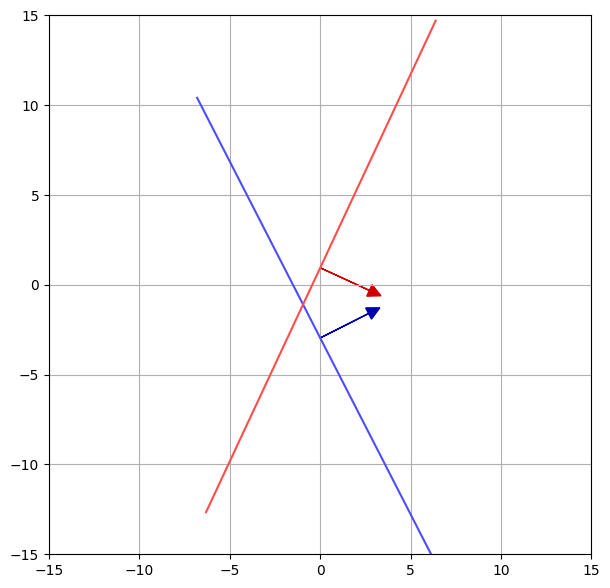

Epoch 1 | Loss 0.505912 | Acc 85.00% | Task Acc 100.00%
-2.9603450298309326 -4.703897476196289


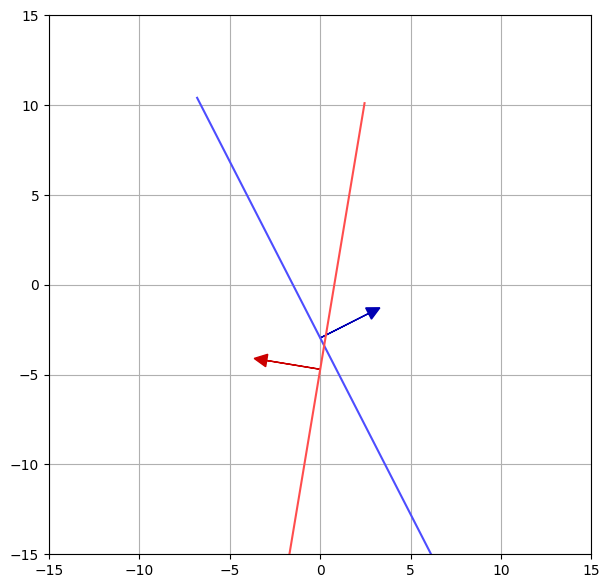

Epoch 2 | Loss 0.499445 | Acc 84.72% | Task Acc 100.00%
-2.9603450298309326 -0.5072373151779175


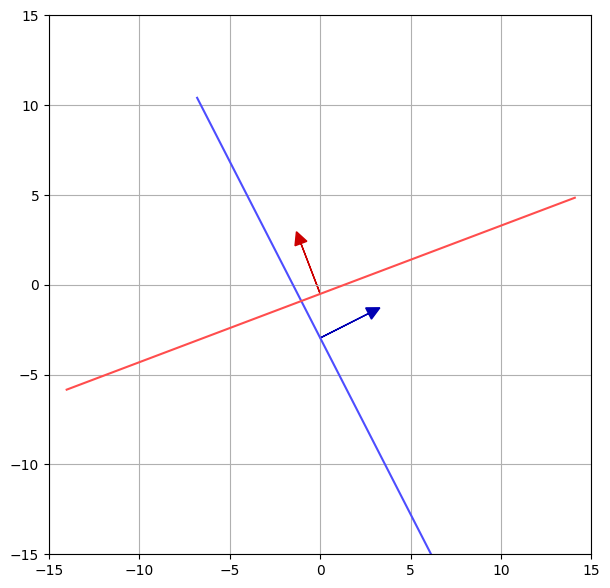

Epoch 3 | Loss 0.497099 | Acc 86.46% | Task Acc 100.00%
-2.9603450298309326 0.6147156953811646


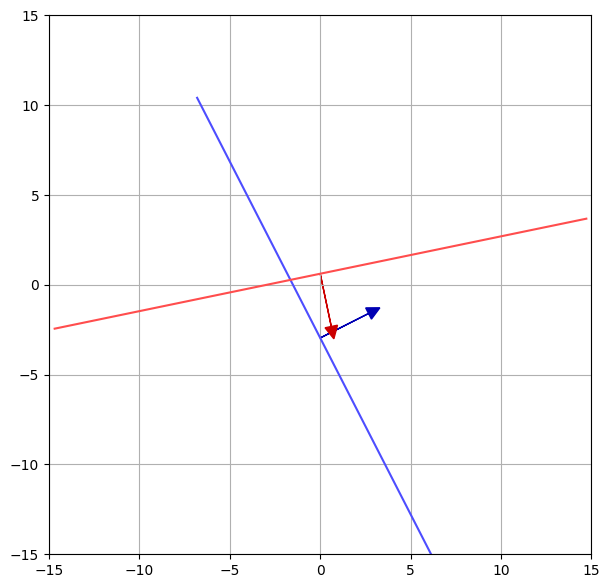

In [73]:
n = 20
task_count = 0
avg_loss = 0
loss_all = []
acc_all = []
tasks = [sample_task_I(n, False), sample_task_I(n, True), sample_task_II(n, False), sample_task_II(n, True)]
plot_decision_boundary = True

for i, task in enumerate(tasks):
  X, y = task

  X_support, y_support, X_query, y_query = split_support_query(X, y)

  A, B, C = get_vector(model)

  loss, task_accuracy, positions = model.set_forward_loss(X_support, y_support, X_query, y_query)

  avg_loss = avg_loss + loss.item()
  loss_all.append(loss)
  acc_all.append(task_accuracy)

  task_count += 1

  acc_all_np  = np.asarray(acc_all)
  acc_mean = np.mean(acc_all_np)
  print('Epoch {:d} | Loss {:f} | Acc {:4.2f}% | Task Acc {:4.2f}%'.format(i, avg_loss/float(i+1), acc_mean, task_accuracy[-1]))

  figs, axs = plt.subplots(1,1, figsize=(7, 7))
  # plt.scatter(X[:,0], X[:,1], c=y)
  axs.set_xlim([-15, 15])
  axs.set_ylim([-15, 15])

  if plot_decision_boundary:
    A_fast, B_fast, C_fast = get_fast_vector(model)

    scale = 3

    x_step = np.absolute(B) * (15 / np.sqrt((np.power(A, 2) + np.power(B, 2))))
    x_arg = np.arange(-x_step, x_step + 0.1, 0.1)

    x_fast_step = np.absolute(B_fast) * (15 / np.sqrt((np.power(A_fast, 2) + np.power(B_fast, 2))))
    x_fast_arg = np.arange(-x_fast_step, x_fast_step + 0.1, 0.1)

    yx_fast = (-A_fast/B_fast)*x_fast_arg-(C_fast/B_fast)
    yx = (-A/B)*x_arg-(C/B)

    arr_length1 = np.sqrt(np.power(A, 2) + np.power(B, 2))
    arr_length2 = np.sqrt(np.power(A_fast, 2) + np.power(B_fast, 2))

    dx = scale*A/arr_length1
    dy = scale*B/arr_length1
    dx_fast = scale*A_fast/arr_length2
    dy_fast = scale*B_fast/arr_length2

    plt.arrow(0, -(C/B), dx, dy, head_width=0.7, head_length=0.7, fc='#0000b3', ec='#0000b3')
    plt.arrow(0, -(C_fast/B_fast), dx_fast, dy_fast, head_width=0.7, head_length=0.7, fc='#cc0000', ec='#cc0000')
    print(f'{-(C/B)} {-(C_fast/B_fast)}')
    # plt.plot(X[:,0], X[:,1])
    plt.plot(x_arg, yx, c='#4d4dff')
    plt.plot(x_fast_arg, yx_fast, c='#ff4d4d')

  plt.grid()
  plt.show()

1. Jak nauczycie MAML to narysujcie \Theta i te \Theta_i po każdym tasku
2. możecie granice decyzyjną zadaną przez te wektory
3. ten kod to rysuje co podobnego, moze pomoze:
https://github.com/przem85/bootcamp/blob/master/supervised_learning/D01_Z01_R.ipynb

HyperNet class

In [74]:
#@title
class HyperNet(nn.Module):
    def __init__(self, hn_hidden_size, embedding_size, out_neurons, hn_head_len, hn_activation=None):
        super(HyperNet, self).__init__()

        self.hn_head_len = hn_head_len
        self.hn_activation = hn_activation

        if self.hn_head_len > 2:
            layers = [nn.Linear(embedding_size, hn_hidden_size)]
            layers.append(nn.ReLU())

            for i in range(self.hn_head_len - 2):
                layers.append(nn.Linear(hn_hidden_size, hn_hidden_size))
                layers.append(nn.ReLU())

            layers.append(nn.Linear(hn_hidden_size, out_neurons))
            if self.hn_activation == 'sigmoid':
                layers.append(nn.Sigmoid())

            self.layers = nn.Sequential(*layers)
        else:
            layers = [nn.Linear(embedding_size, out_neurons)]
            self.layers = nn.Sequential(*layers)

    def forward(self, x):
        out = self.layers(x)
        return out

In [75]:
def get_param_dict(net: nn.Module) -> Dict[str, nn.Parameter]:
    """A dict of named parameters of an nn.Module"""
    return {
        n: p
        for (n, p) in net.named_parameters()
    }

Define HyperMAML model

In [76]:
#@title
class HyperMAML(MAML):
    def __init__(self, n_way, n_support, n_query, approx = False, hn_head_len: int =2, hn_hidden_size=512):
        super(HyperMAML, self).__init__(n_way, n_support, n_query)
        self.feat_dim = 2

        self.loss_fn = nn.BCELoss()
        self.classifier = Linear_fw(self.feat_dim, 1)
        self.classifier.bias.data.fill_(0)

        self.enhance_embeddings = False

        self.n_task = 4
        self.task_update_num = 5
        self.train_lr = 0.01
        self.approx = approx # first order approx.

        self.hn_head_len = hn_head_len
        self.hn_embeddings_strategy = None
        self.hn_hidden_size = 512
        self.hn_lambda = 0.0
        self.hn_save_delta_params = False
        self.hn_use_class_batch_input = False
        self.hn_adaptation_strategy = None
        self.hm_support_set_loss = False
        self.hm_maml_warmup = False
        self.hm_maml_warmup_epochs = 50
        self.hm_maml_warmup_switch_epochs = 50
        self.hm_maml_update_feature_net = False
        self.hm_update_operator = 'minus'
        self.hm_load_feature_net = False
        self.hm_feature_net_path = ''
        self.hm_detach_feature_net = False
        self.hm_detach_before_hyper_net = False
        self.hm_set_forward_with_adaptation = False
        self.hn_val_lr = 1e-4
        self.hn_val_epochs = 0
        self.hn_val_optim = 'adam'

        self.alpha = 0
        self.hn_alpha_step = 0

        if self.hn_adaptation_strategy == 'increasing_alpha' and self.hn_alpha_step < 0:
            raise ValueError('hn_alpha_step is not positive!')

        self.single_test = False
        self.epoch = -1
        self.start_epoch = -1
        self.stop_epoch = -1

        self.calculate_embedding_size()

        self._init_hypernet_modules()
        self._init_feature_net()

    def _init_feature_net(self):
        if self.hm_load_feature_net:
            print(f'loading feature net model from location: {self.hm_feature_net_path}')
            model_dict = torch.load(self.hm_feature_net_path)
            self.feature.load_state_dict(model_dict['state'])

    def _init_classifier(self):
        assert self.hn_tn_hidden_size % self.n_way == 0, f"hn_tn_hidden_size {self.hn_tn_hidden_size} should be the multiple of n_way {self.n_way}"
        layers = []

        for i in range(self.hn_tn_depth):
            in_dim = self.feat_dim if i == 0 else self.hn_tn_hidden_size
            out_dim = self.n_way if i == (self.hn_tn_depth - 1) else self.hn_tn_hidden_size

            linear = Linear_fw(in_dim, out_dim)
            linear.bias.data.fill_(0)

            layers.append(linear)

        self.classifier = nn.Sequential(*layers)

    def _init_hypernet_modules(self):
        target_net_param_dict = get_param_dict(self.classifier)

        target_net_param_dict = {
            name.replace(".", "-"): p
            # replace dots with hyphens bc torch doesn't like dots in modules names
            for name, p in target_net_param_dict.items()
        }

        self.target_net_param_shapes = {
            name: p.shape
            for (name, p)
            in target_net_param_dict.items()
        }

        self.hypernet_heads = nn.ModuleDict()

        for name, param in target_net_param_dict.items():
            if self.hn_use_class_batch_input and name[-4:] == 'bias':
                continue

            bias_size = param.shape[0] // self.n_way

            head_in = self.embedding_size
            head_out = (param.numel() // self.n_way) + bias_size if self.hn_use_class_batch_input else param.numel()
            head_modules = []

            self.hypernet_heads[name] = HyperNet(self.hn_hidden_size, head_in, head_out, self.hn_head_len)

    def calculate_embedding_size(self):
        if self.hn_use_class_batch_input:
            if self.enhance_embeddings:
                self.embedding_size = self.n_support * (self.feat_dim + self.n_way + 1)
            else:
                self.embedding_size = self.n_support * self.feat_dim
        else:
            if self.hn_embeddings_strategy == 'class_mean':
                if self.enhance_embeddings:
                    self.embedding_size = self.n_way * (self.feat_dim + self.n_way + 1)
                else:
                    self.embedding_size = self.n_way * self.feat_dim
            else:
                if self.enhance_embeddings:
                    self.embedding_size = self.n_way * self.n_support * (self.feat_dim + self.n_way + 1)
                else:
                    self.embedding_size = self.n_way * self.n_support * self.feat_dim

    def apply_embeddings_strategy(self, embeddings):
        if self.hn_embeddings_strategy == 'class_mean':
            new_embeddings = torch.zeros(self.n_way, *embeddings.shape[1:])

            for i in range(self.n_way):
                lower = i * self.n_support
                upper = (i + 1) * self.n_support
                new_embeddings[i] = embeddings[lower:upper, :].mean(dim=0)

            return new_embeddings.cuda()

        return embeddings

    def get_support_data_labels(self):
        if self.hn_embeddings_strategy == 'class_mean':
            return torch.from_numpy(np.repeat(range(self.n_way), 1)).cuda()

        return torch.from_numpy(np.repeat(range(self.n_way), self.n_support)).cuda() # labels for support data

    def get_hn_delta_params(self, support_embeddings):
        if self.hm_detach_before_hyper_net:
            support_embeddings = support_embeddings.detach()

        if self.hn_use_class_batch_input:
            delta_params_list = []

            for name, param_net in self.hypernet_heads.items():
                delta = []
                bias_delta = []

                lower = 0
                upper = self.n_support

                for i in range(self.n_way):
                    class_embeddings = support_embeddings[lower:upper]
                    class_embeddings = class_embeddings.flatten()
                    delta_params = param_net(class_embeddings)

                    bias_neurons_num = self.target_net_param_shapes[name][0] // 5

                    class_delta = delta_params[:-bias_neurons_num]
                    class_bias_delta = delta_params[-bias_neurons_num:]

                    if self.hn_adaptation_strategy == 'increasing_alpha' and self.alpha < 1:
                        class_delta = self.alpha * class_delta
                        class_bias_delta = self.alpha * class_bias_delta

                    delta.append(class_delta)
                    bias_delta.append(class_bias_delta)

                    lower += self.n_support
                    upper += self.n_support

                delta_params_list.append(torch.stack(delta).reshape(self.target_net_param_shapes[name]))
                delta_params_list.append(torch.cat(bias_delta, dim=0))

            return delta_params_list
        else:
            delta_params_list = []

            for name, param_net in self.hypernet_heads.items():
                flattened_embeddings = support_embeddings.flatten()
                delta = param_net(flattened_embeddings)

                if name in self.target_net_param_shapes.keys():
                    delta = delta.reshape(self.target_net_param_shapes[name])

                if self.hn_adaptation_strategy == 'increasing_alpha' and self.alpha < 1:
                    delta = self.alpha * delta

                delta_params_list.append(delta)

            return delta_params_list


    def _update_weight(self, weight, update_value):
        if self.hm_update_operator == 'minus':
            if weight.fast is None:
                weight.fast = weight - update_value
            else:
                weight.fast = weight.fast - update_value
        elif self.hm_update_operator == 'plus':
            if weight.fast is None:
                weight.fast = weight + update_value
            else:
                weight.fast = weight.fast + update_value
        elif self.hm_update_operator == 'multiply':
            if weight.fast is None:
                weight.fast = weight * update_value
            else:
                weight.fast = weight.fast * update_value

    def _get_p_value(self):
        if self.epoch < self.hm_maml_warmup_epochs:
            return 1.0
        elif self.hm_maml_warmup_epochs <= self.epoch < self.hm_maml_warmup_epochs + self.hm_maml_warmup_switch_epochs:
            return (self.hm_maml_warmup_switch_epochs + self.hm_maml_warmup_epochs - self.epoch) / (self.hm_maml_warmup_switch_epochs + 1)
        return 0.0

    def _update_network_weights(self, delta_params_list, support_embeddings, support_data_labels):
        if self.hm_maml_warmup and not self.single_test:
            p = self._get_p_value()

            if p > 0.0:
                fast_parameters = []

                if self.hm_maml_update_feature_net:
                    fet_fast_parameters = list(self.feature.parameters())
                    for weight in self.feature.parameters():
                        weight.fast = None
                    self.feature.zero_grad()
                    fast_parameters = fast_parameters + fet_fast_parameters

                clf_fast_parameters = list(self.classifier.parameters())
                for weight in self.classifier.parameters():
                    weight.fast = None
                self.classifier.zero_grad()
                fast_parameters = fast_parameters + clf_fast_parameters

                for task_step in range(self.task_update_num):
                    scores = self.classifier(support_embeddings)
                    set_loss = self.loss_fn(scores, support_data_labels)

                    grad = torch.autograd.grad(set_loss, fast_parameters, create_graph=True, allow_unused=True) #build full graph support gradient of gradient

                    if self.approx:
                        grad = [ g.detach()  for g in grad ] #do not calculate gradient of gradient if using first order approximation

                    if self.hm_maml_update_feature_net:
                        # update weights of feature networ
                        for k, weight in enumerate(self.feature.parameters()):
                            update_value = self.train_lr * p * grad[k]
                            self._update_weight(weight, update_value)

                    classifier_offset = len(fet_fast_parameters) if self.hm_maml_update_feature_net else 0

                    if p == 1:
                        # update weights of classifier network by adding gradient
                        for k, weight in enumerate(self.classifier.parameters()):
                            update_value = (self.train_lr * grad[classifier_offset + k])
                            self._update_weight(weight, update_value)

                    elif 0.0 < p < 1.0:
                        # update weights of classifier network by adding gradient and output of hypernetwork
                        for k, weight in enumerate(self.classifier.parameters()):
                            update_value = ((self.train_lr * p * grad[classifier_offset + k]) + ((1 - p) * delta_params_list[k]))
                            self._update_weight(weight, update_value)
            else:
                for k, weight in enumerate(self.classifier.parameters()):
                    update_value = delta_params_list[k]
                    self._update_weight(weight, update_value)
        else:
            for k, weight in enumerate(self.classifier.parameters()):
                update_value = delta_params_list[k]
                self._update_weight(weight, update_value)


    def _get_list_of_delta_params(self, maml_warmup_used, support_embeddings, support_data_labels):
        if not maml_warmup_used:
            enhanced_support_embeddings = self.apply_embeddings_strategy(support_embeddings)

            if self.enhance_embeddings:
                with torch.no_grad():
                    logits = self.classifier.forward(enhanced_support_embeddings).detach()
                    logits = F.softmax(logits, dim=1)

                labels = support_data_labels.view(enhanced_support_embeddings.shape[0], -1)
                enhanced_support_embeddings = torch.cat((enhanced_support_embeddings, logits, labels), dim=1)

            for weight in self.parameters():
                weight.fast = None
            self.zero_grad()

            delta_params = self.get_hn_delta_params(enhanced_support_embeddings)

            if self.hn_save_delta_params and len(self.delta_list) == 0:
                self.delta_list = [{'delta_params': delta_params}]

            return delta_params
        else:
            return [torch.zeros(*i).cuda() for (_, i) in self.target_net_param_shapes.items()]

    def forward(self, x):
        out = torch.sigmoid(self.classifier(x))
        return out


    def set_forward(self, X_support, y_support, X_query, is_feature = False, train_stage = False):
        assert is_feature == False, 'MAML do not support fixed feature'

        maml_warmup_used = ((not self.single_test) and self.hm_maml_warmup and (self.epoch < self.hm_maml_warmup_epochs))

        delta_params_list = self._get_list_of_delta_params(maml_warmup_used, X_support, y_support)

        self._update_network_weights(delta_params_list, X_support, y_support)

        if self.hm_set_forward_with_adaptation and not train_stage:
            scores = self.forward(X_support)
            return scores, None
        else:
            if self.hm_support_set_loss and train_stage and not maml_warmup_used:
                X_query = torch.cat((X_support, X_query))

            scores = self.forward(X_query)

            return scores, None

    def set_forward_loss(self, X_support, y_support, X_query, y_query):
        scores, _ = self.set_forward(X_support, y_support, X_query, is_feature = False)
        y_query = y_query.unsqueeze(1)
        loss = self.loss_fn(scores, y_query)

        predictions  = (scores > 0.5)
        positions = (predictions == y_query)
        task_accuracy = (positions.sum() / predictions.size()[0]) * 100

        return loss, task_accuracy, positions.squeeze()

    def train_loop(self, epoch, train_loader, optimizer): #overwrite parrent function
        print_freq = 10
        avg_loss=0
        task_count = 0
        loss_all = []
        acc_all = []
        optimizer.zero_grad()

        self.delta_list = []

        #train
        for i, (x,_) in enumerate(train_loader):
            self.n_query = x.size(1) - self.n_support
            assert self.n_way  ==  x.size(0), "MAML do not support way change"

            loss, task_accuracy = self.set_forward_loss(x)
            avg_loss = avg_loss+loss.item()#.data[0]
            loss_all.append(loss)
            acc_all.append(task_accuracy)

            task_count += 1

            if task_count == self.n_task: #MAML update several tasks at one time
                loss_q = torch.stack(loss_all).sum(0)
                loss_q.backward()

                optimizer.step()
                task_count = 0
                loss_all = []
            optimizer.zero_grad()
            if i % print_freq==0:
                print('Epoch {:d}/{:d} | Batch {:d}/{:d} | Loss {:f}'.format(self.epoch, self.stop_epoch, i, len(train_loader), avg_loss/float(i+1)))

        acc_all  = np.asarray(acc_all)
        acc_mean = np.mean(acc_all)

        metrics = {"accuracy/train": acc_mean}

        if self.hn_adaptation_strategy == 'increasing_alpha':
            metrics['alpha'] =  self.alpha

        if self.hn_save_delta_params and len(self.delta_list) > 0:
            delta_params = {"epoch": self.epoch, "delta_list": self.delta_list}
            metrics['delta_params'] = delta_params

        if self.alpha < 1:
            self.alpha += self.hn_alpha_step

        return metrics

    def test_loop(self, test_loader, return_std = False): #overwrite parrent function
        correct =0
        count = 0
        acc_all = []
        self.delta_list = []
        acc_at = defaultdict(list)

        iter_num = len(test_loader)

        if self.hm_set_forward_with_adaptation:
            for i, (x,_) in enumerate(test_loader):
                self.n_query = x.size(1) - self.n_support
                assert self.n_way  ==  x.size(0), "MAML do not support way change"
                acc_task, acc_at_metrics = self.set_forward_with_adaptation(x)
                for (k, v) in acc_at_metrics.items():
                    acc_at[k].append(v)
                acc_all.append(acc_task)
        else:
            for i, (x,_) in enumerate(test_loader):
                self.n_query = x.size(1) - self.n_support
                assert self.n_way  ==  x.size(0), "MAML do not support way change"
                correct_this, count_this = self.correct(x)
                acc_all.append(correct_this/ count_this *100 )

        metrics = {
            k: np.mean(v) if len(v) > 0 else 0
            for (k,v) in acc_at.items()
        }

        acc_all  = np.asarray(acc_all)
        acc_mean = np.mean(acc_all)
        acc_std  = np.std(acc_all)
        print('%d Test Acc = %4.2f%% +- %4.2f%%' %(iter_num,  acc_mean, 1.96* acc_std/np.sqrt(iter_num)))
        if return_std:
            return acc_mean, acc_std, metrics
        else:
            return acc_mean, metrics

    def get_logits(self, x):
        self.n_query = x.size(1) - self.n_support
        logits, _ = self.set_forward(x)
        return logits

    def correct(self, x):
        scores, _ = self.set_forward(x)
        y_query = np.repeat(range( self.n_way ), self.n_query)

        topk_scores, topk_labels = scores.data.topk(1, 1, True, True)
        topk_ind = topk_labels.cpu().numpy()
        top1_correct = np.sum(topk_ind[:,0] == y_query)
        return float(top1_correct), len(y_query)

In [77]:
np.random.seed(seed)
torch.manual_seed(seed)

model = HyperMAML(n_way=2, n_support=10, n_query=10, approx=False, hn_head_len=4)
model.task_update_num = 1
model.n_task = 4
model.train_lr = 1e-1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model

HyperMAML(
  (loss_fn): BCELoss()
  (classifier): Linear_fw(in_features=2, out_features=1, bias=True)
  (hypernet_heads): ModuleDict(
    (weight): HyperNet(
      (layers): Sequential(
        (0): Linear(in_features=40, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=2, bias=True)
      )
    )
    (bias): HyperNet(
      (layers): Sequential(
        (0): Linear(in_features=40, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=1, bias=True)
      )
    )
  )
)

Epoch 0 | Loss 3.101173 | Acc 50.00% | Task Acc 50.00%


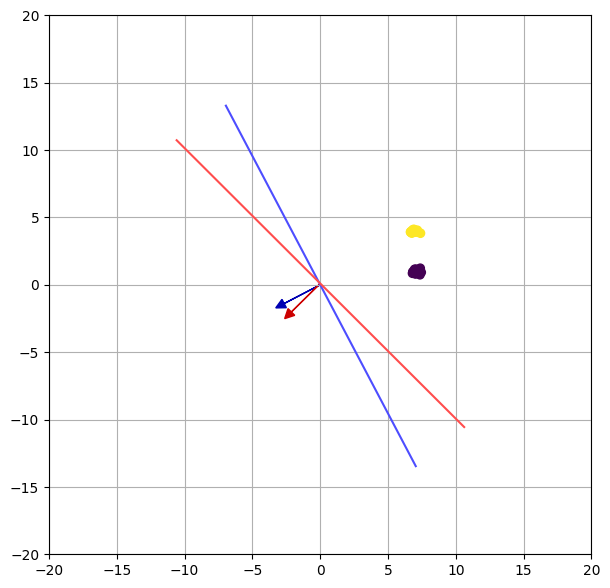

Epoch 250 | Loss 0.396320 | Acc 88.43% | Task Acc 100.00%


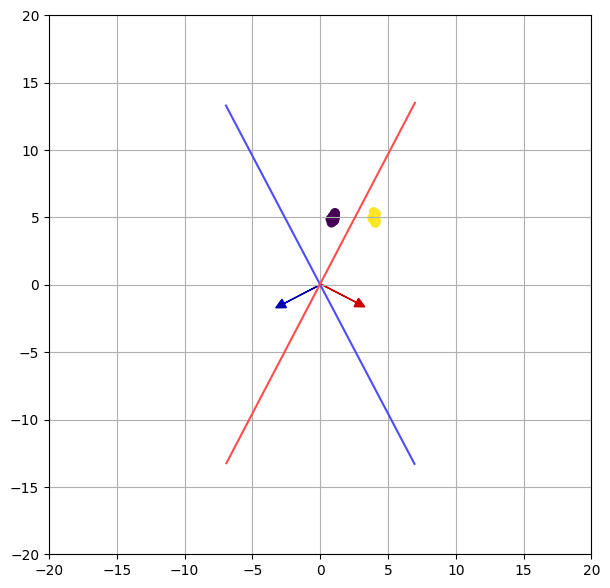

Epoch 500 | Loss 0.198734 | Acc 94.20% | Task Acc 100.00%


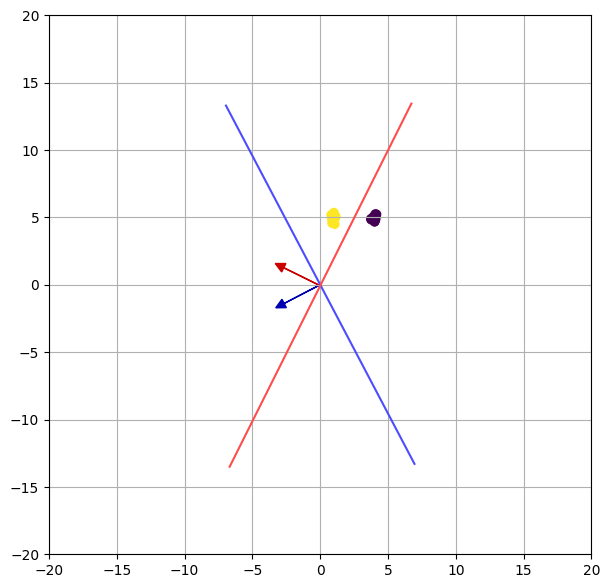

Epoch 750 | Loss 0.132595 | Acc 96.13% | Task Acc 100.00%


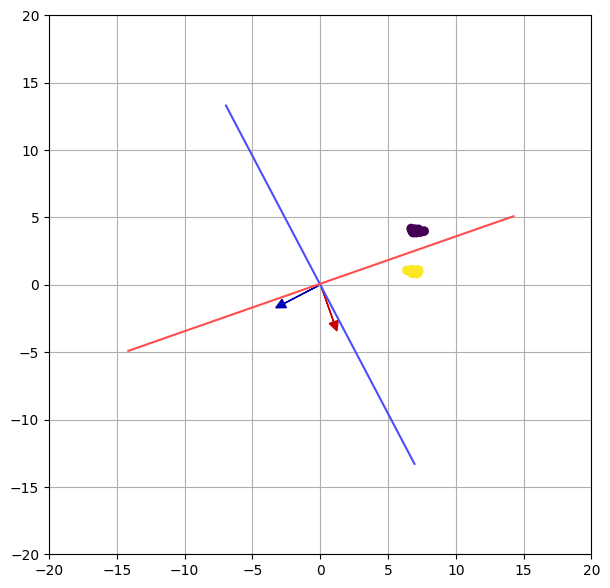

Epoch 1000 | Loss 0.099481 | Acc 97.10% | Task Acc 100.00%


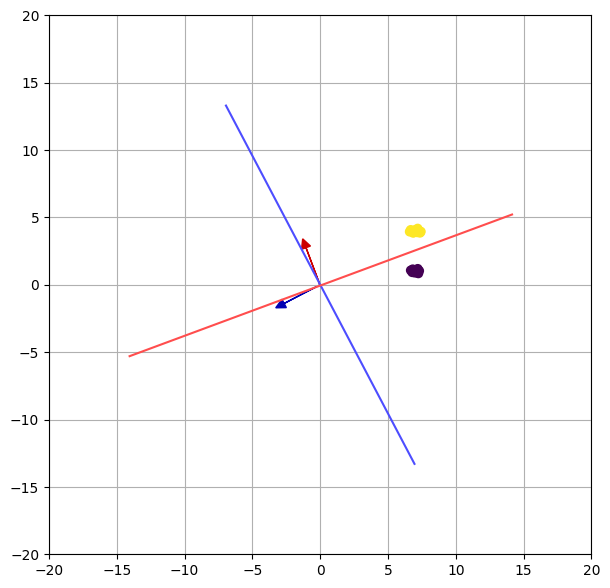

Epoch 1250 | Loss 0.079601 | Acc 97.68% | Task Acc 100.00%


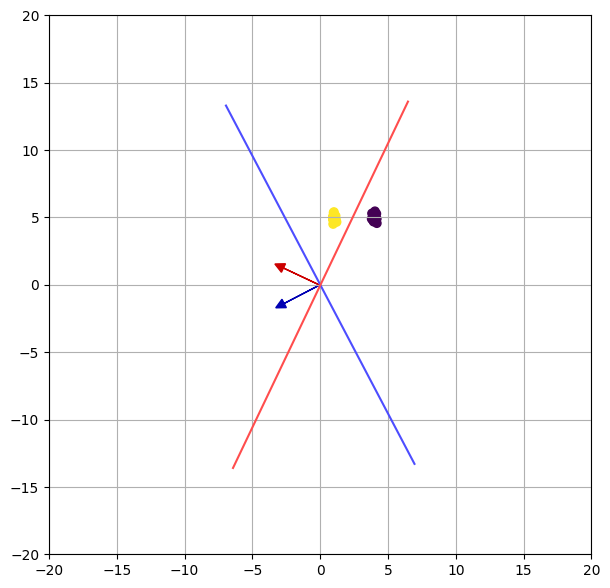

Epoch 1500 | Loss 0.066343 | Acc 98.06% | Task Acc 100.00%


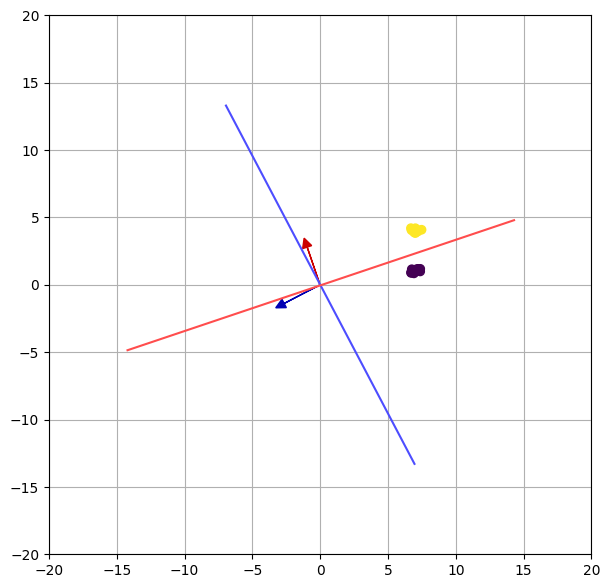

Epoch 1750 | Loss 0.056871 | Acc 98.34% | Task Acc 100.00%


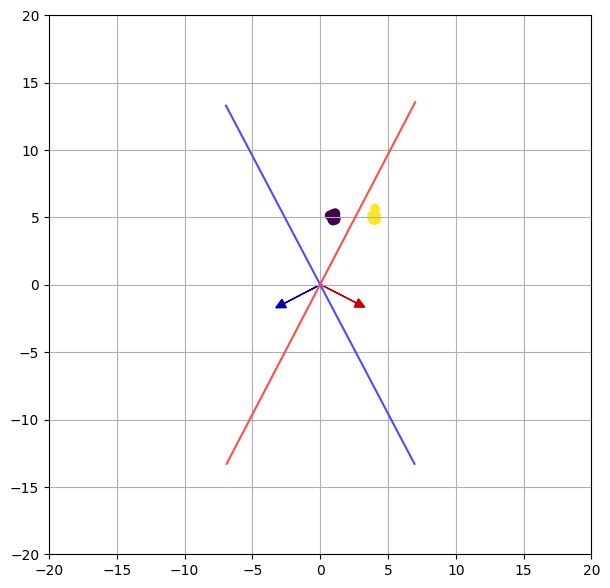

Epoch 2000 | Loss 0.049766 | Acc 98.55% | Task Acc 100.00%


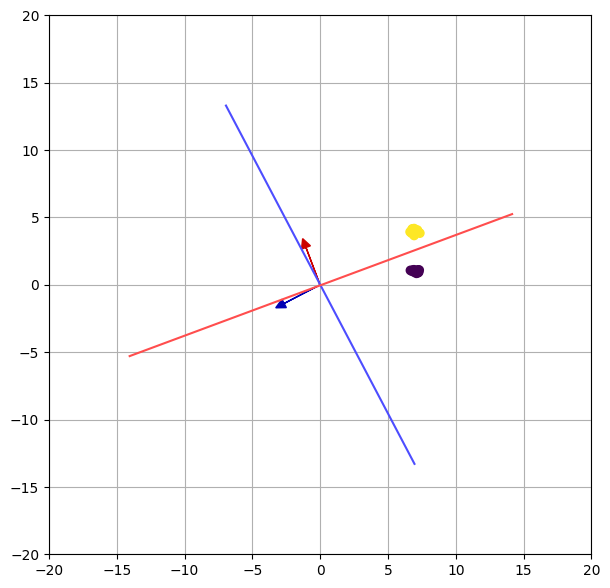

Epoch 2250 | Loss 0.044239 | Acc 98.71% | Task Acc 100.00%


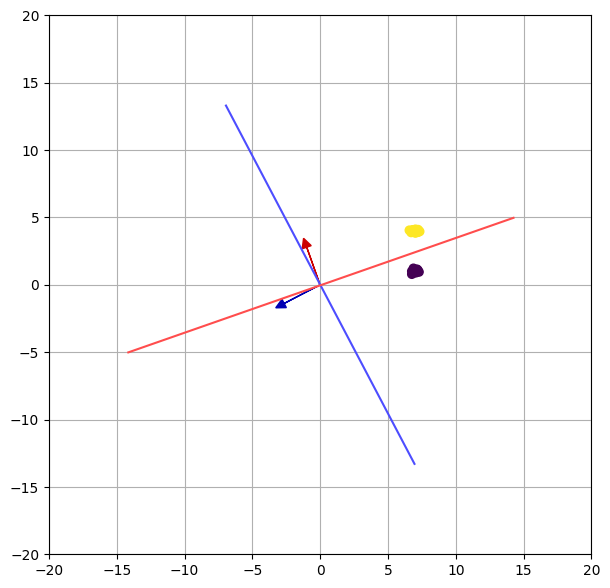

Epoch 2500 | Loss 0.039817 | Acc 98.84% | Task Acc 100.00%


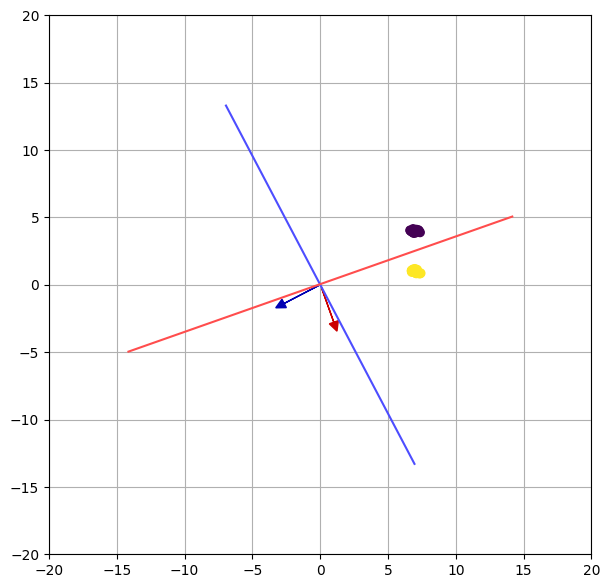

Epoch 2750 | Loss 0.036198 | Acc 98.94% | Task Acc 100.00%


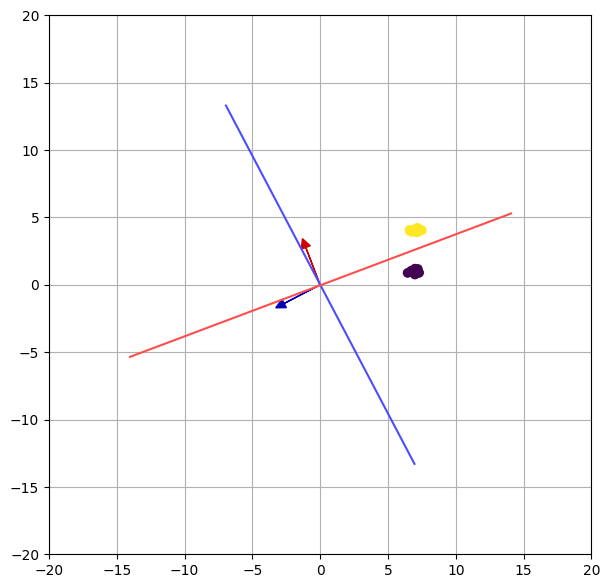

Epoch 3000 | Loss 0.033183 | Acc 99.03% | Task Acc 100.00%


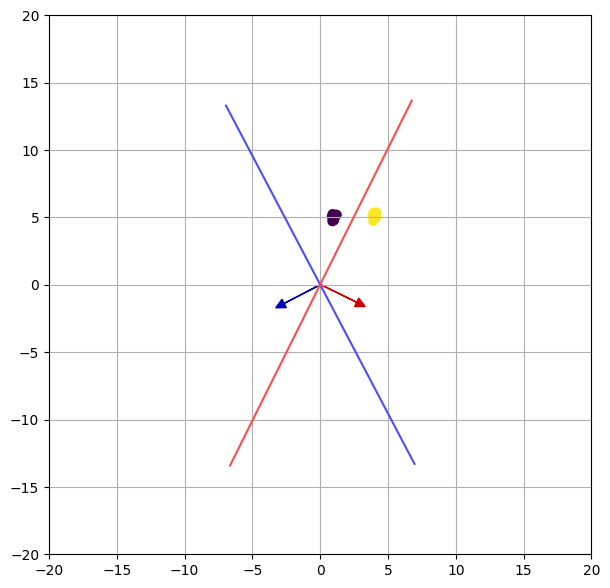

Epoch 3250 | Loss 0.030631 | Acc 99.11% | Task Acc 100.00%


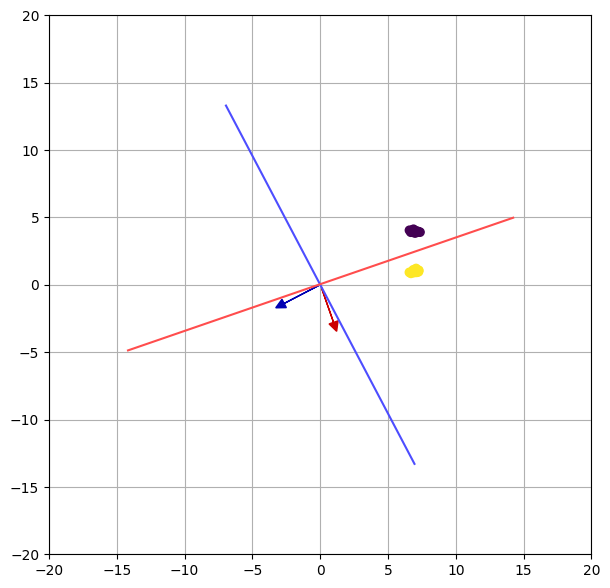

Epoch 3500 | Loss 0.028444 | Acc 99.17% | Task Acc 100.00%


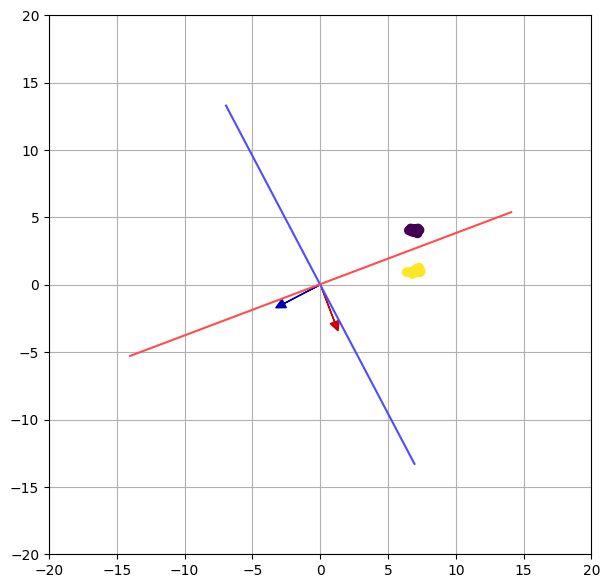

Epoch 3750 | Loss 0.026548 | Acc 99.23% | Task Acc 100.00%


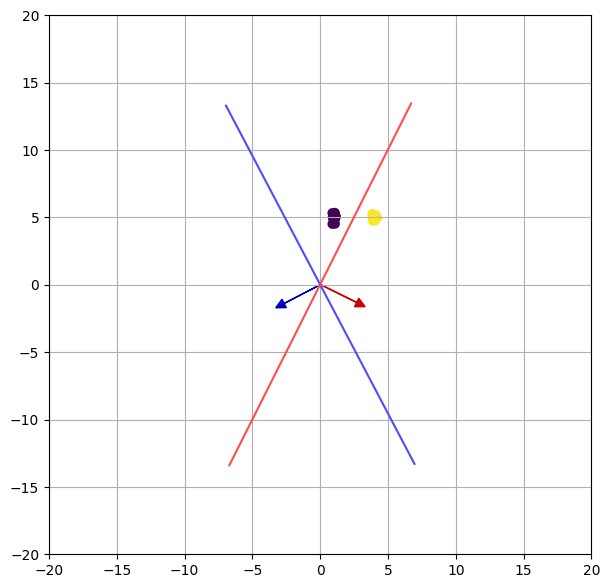

Epoch 4000 | Loss 0.024889 | Acc 99.27% | Task Acc 100.00%


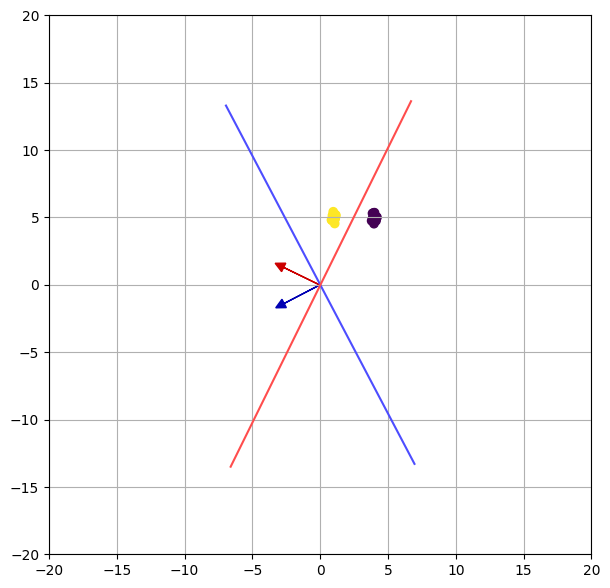

Epoch 4250 | Loss 0.023425 | Acc 99.32% | Task Acc 100.00%


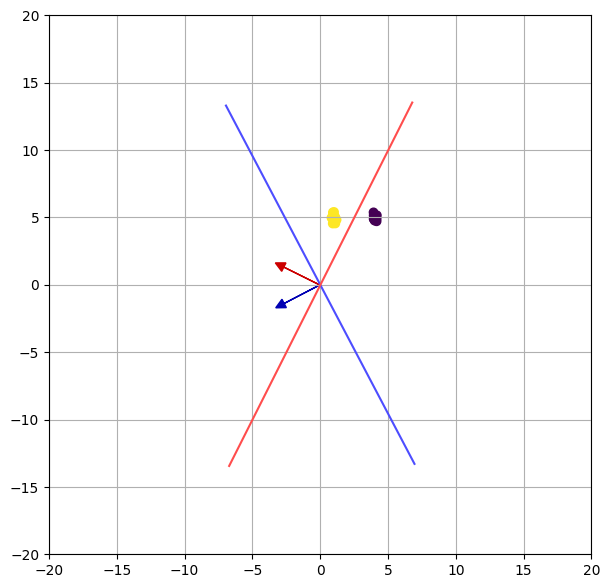

Epoch 4500 | Loss 0.022124 | Acc 99.35% | Task Acc 100.00%


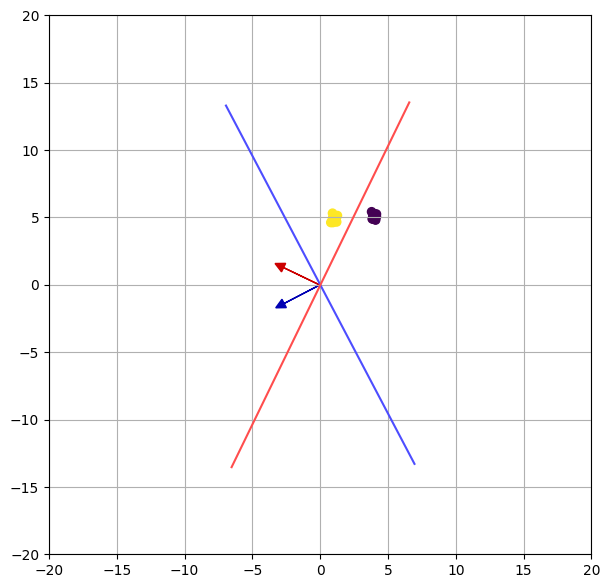

Epoch 4750 | Loss 0.020960 | Acc 99.39% | Task Acc 100.00%


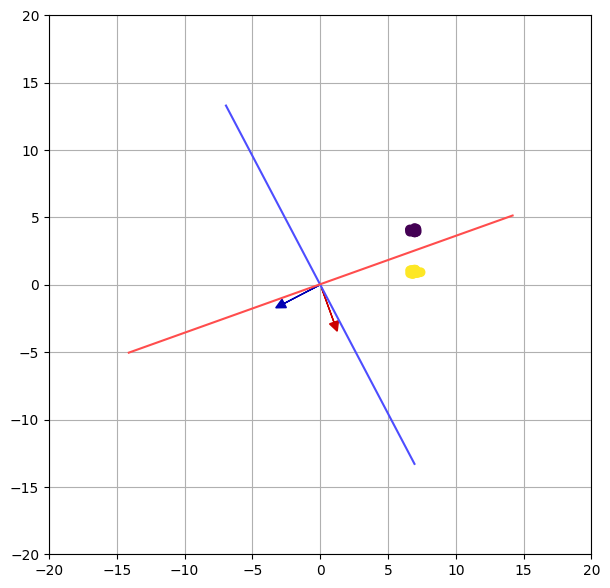

Epoch 5000 | Loss 0.019912 | Acc 99.42% | Task Acc 100.00%


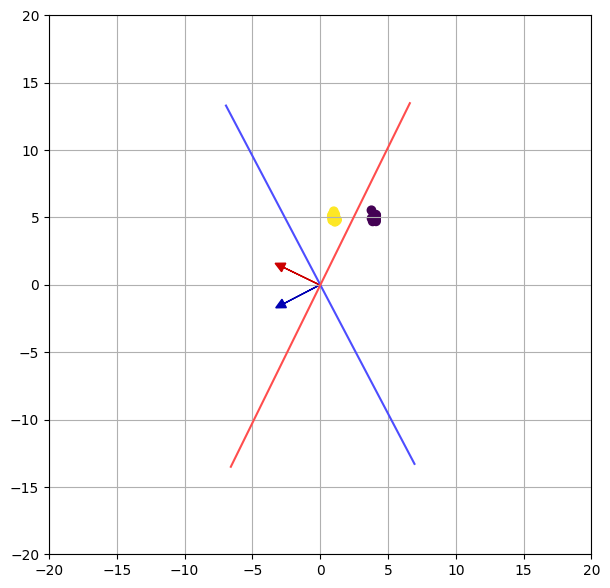

Epoch 5250 | Loss 0.018964 | Acc 99.45% | Task Acc 100.00%


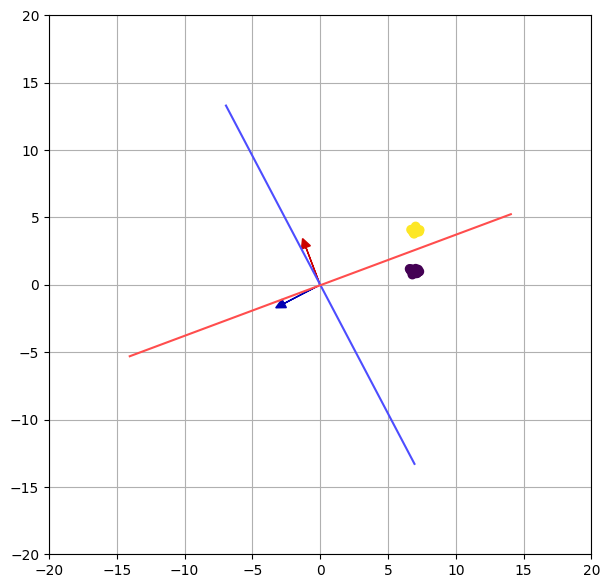

Epoch 5500 | Loss 0.018102 | Acc 99.47% | Task Acc 100.00%


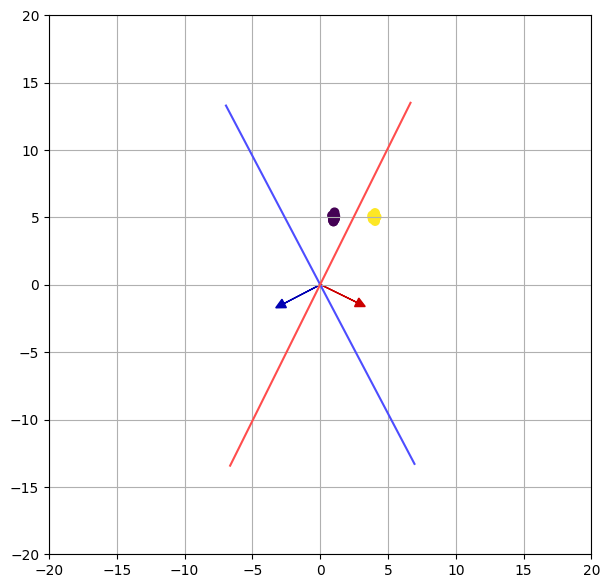

Epoch 5750 | Loss 0.017316 | Acc 99.49% | Task Acc 100.00%


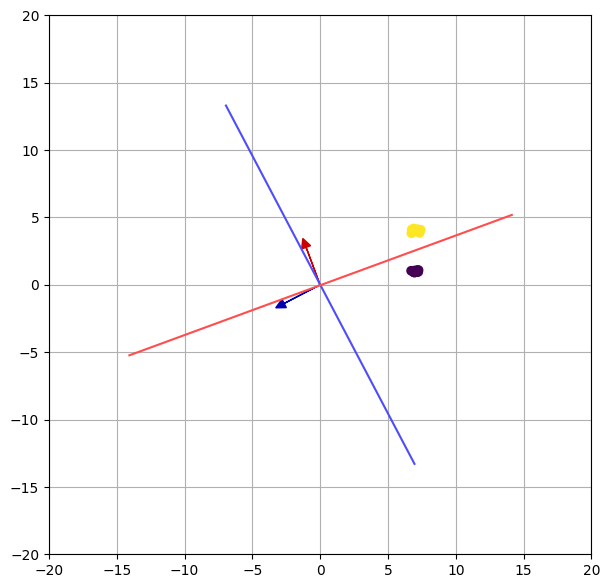

Epoch 6000 | Loss 0.016594 | Acc 99.52% | Task Acc 100.00%


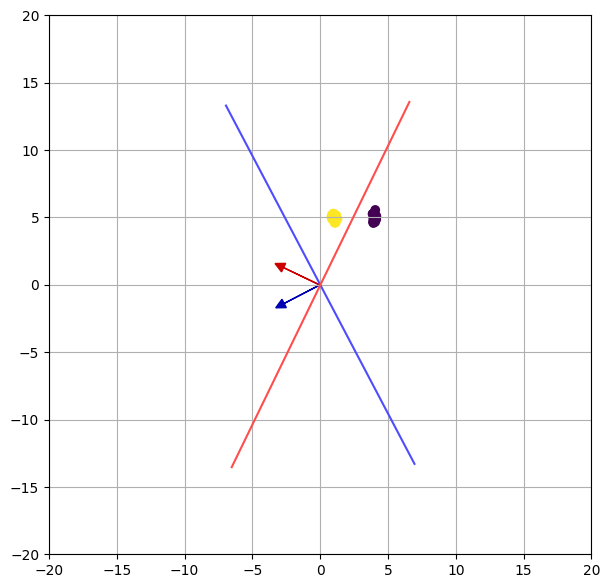

Epoch 6250 | Loss 0.015931 | Acc 99.54% | Task Acc 100.00%


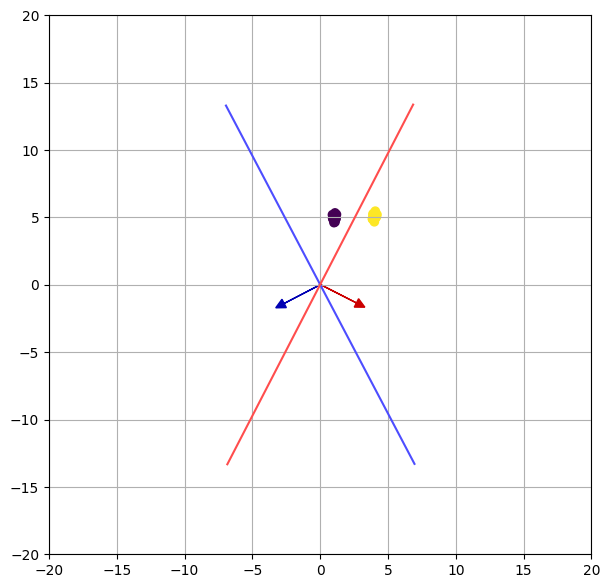

Epoch 6500 | Loss 0.015318 | Acc 99.55% | Task Acc 100.00%


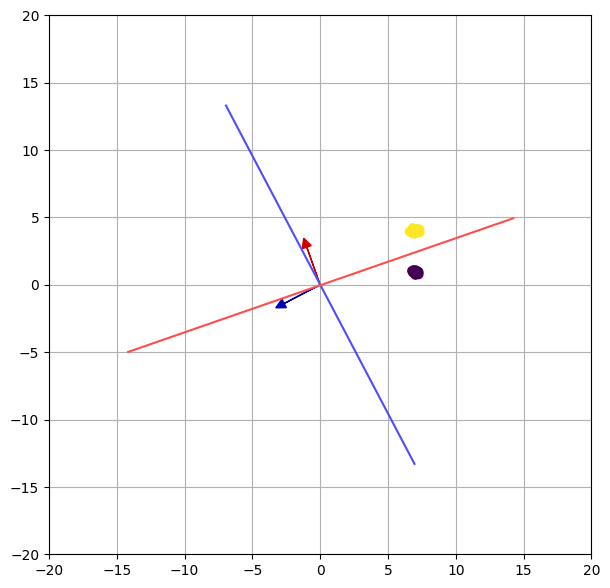

Epoch 6750 | Loss 0.014751 | Acc 99.57% | Task Acc 100.00%


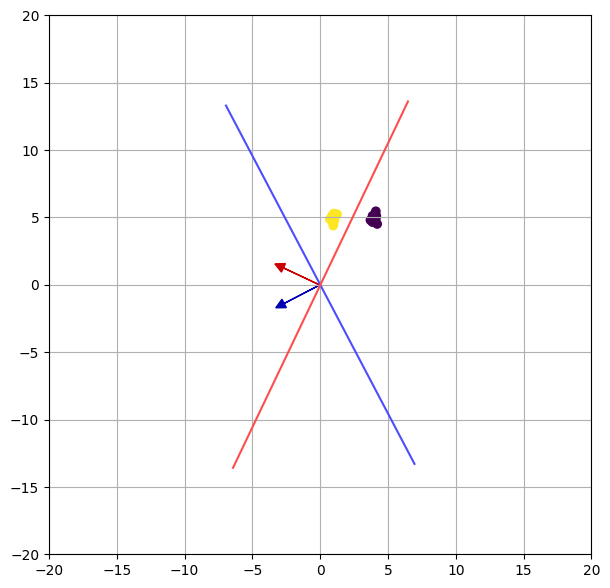

Epoch 7000 | Loss 0.014224 | Acc 99.59% | Task Acc 100.00%


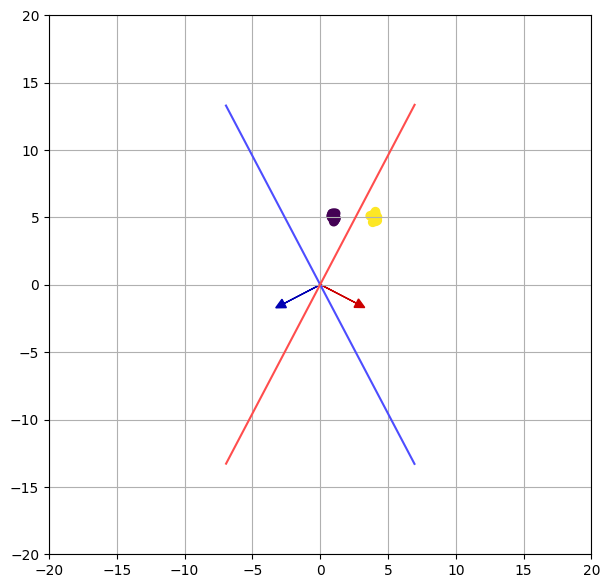

Epoch 7250 | Loss 0.013734 | Acc 99.60% | Task Acc 100.00%


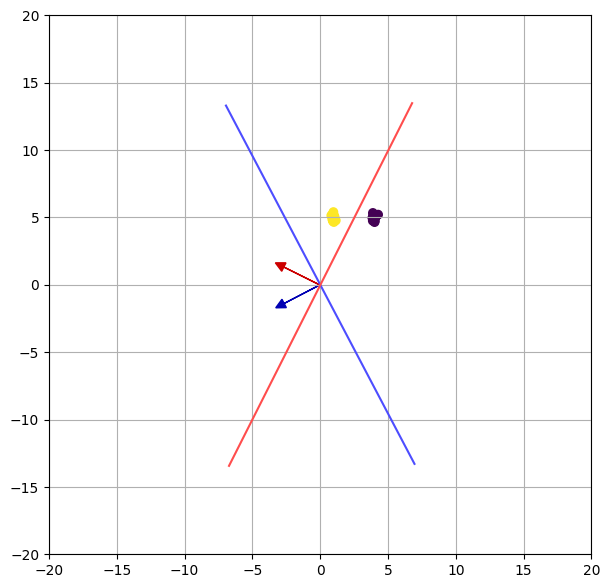

Epoch 7500 | Loss 0.013276 | Acc 99.61% | Task Acc 100.00%


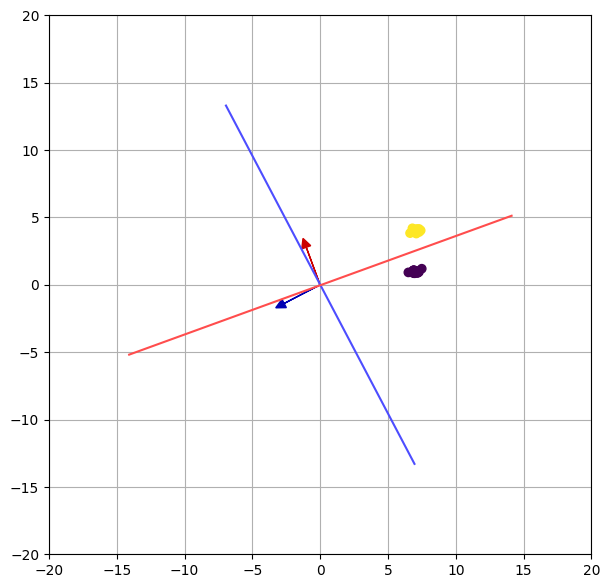

Epoch 7750 | Loss 0.012848 | Acc 99.63% | Task Acc 100.00%


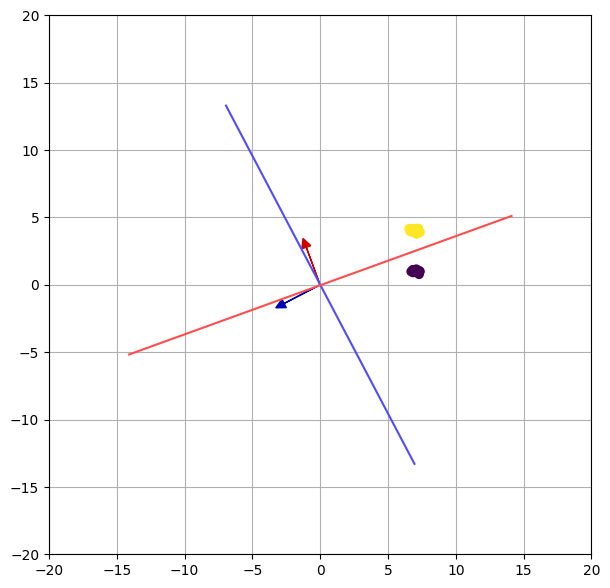

Epoch 8000 | Loss 0.012446 | Acc 99.64% | Task Acc 100.00%


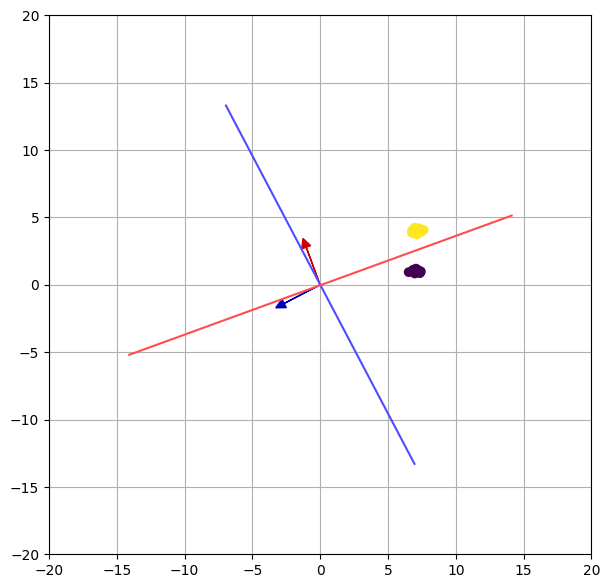

Epoch 8250 | Loss 0.012069 | Acc 99.65% | Task Acc 100.00%


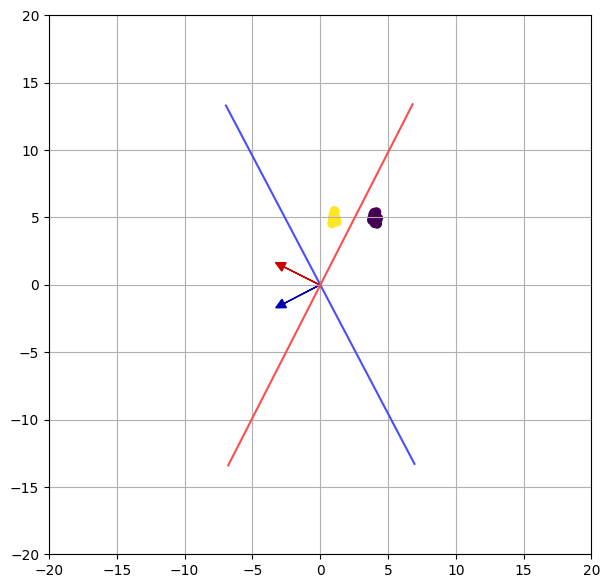

Epoch 8500 | Loss 0.011714 | Acc 99.66% | Task Acc 100.00%


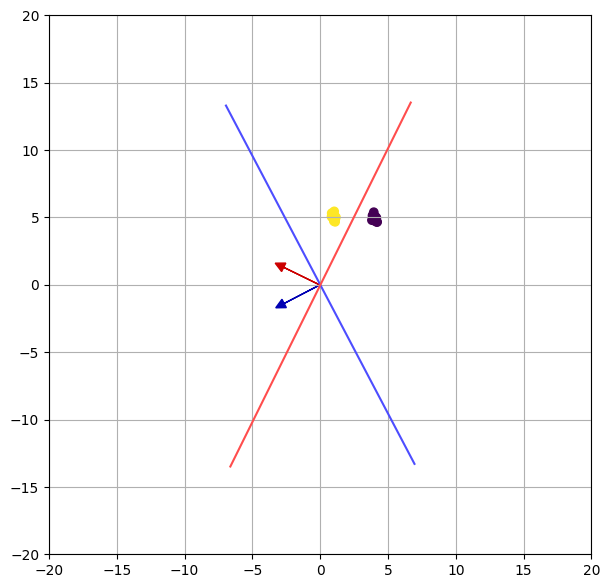

Epoch 8750 | Loss 0.011379 | Acc 99.67% | Task Acc 100.00%


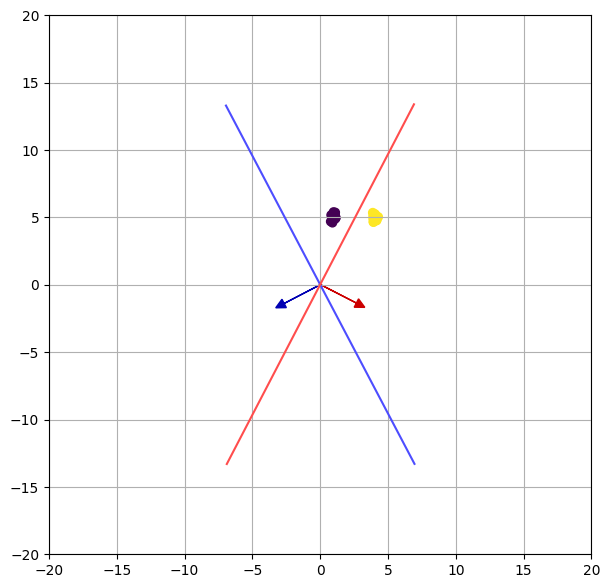

Epoch 9000 | Loss 0.011063 | Acc 99.68% | Task Acc 100.00%


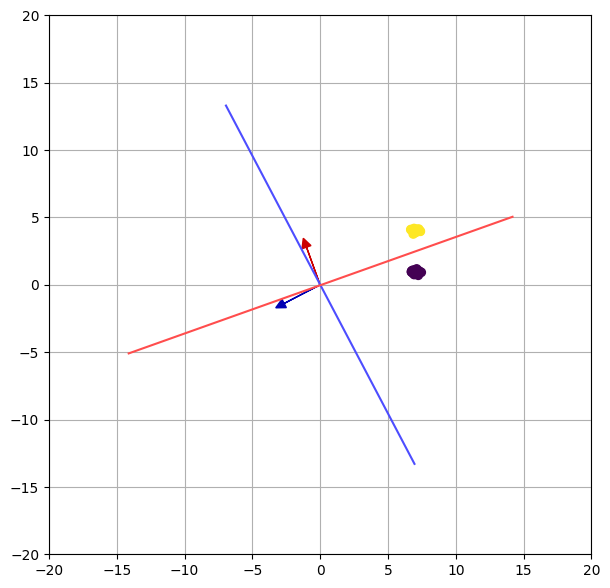

Epoch 9250 | Loss 0.010764 | Acc 99.69% | Task Acc 100.00%


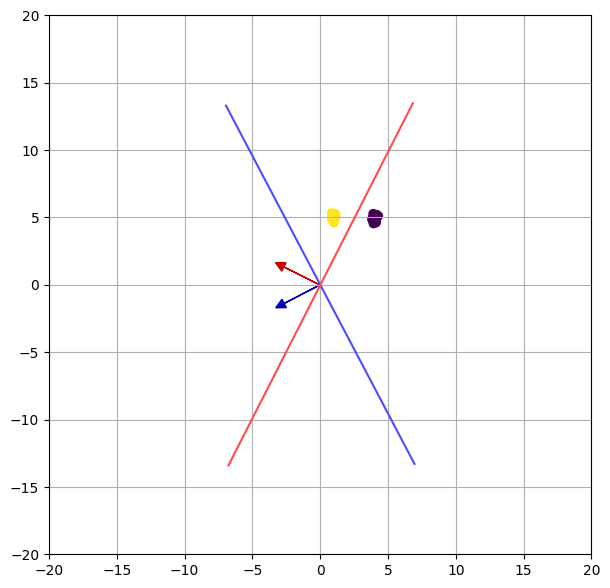

Epoch 9500 | Loss 0.010481 | Acc 99.69% | Task Acc 100.00%


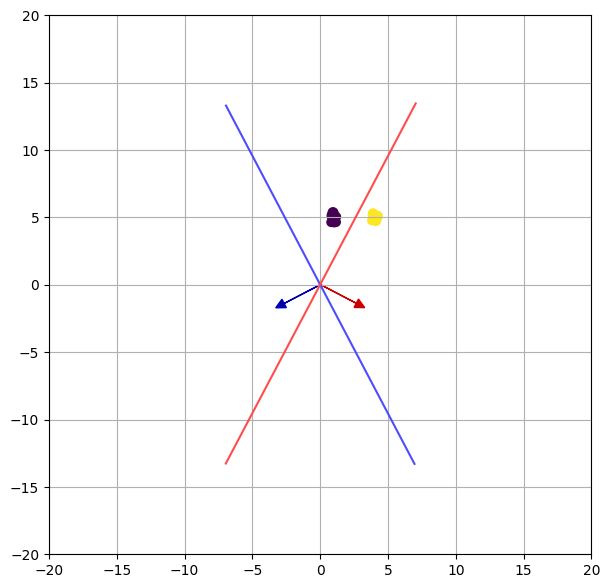

Epoch 9750 | Loss 0.010212 | Acc 99.70% | Task Acc 100.00%


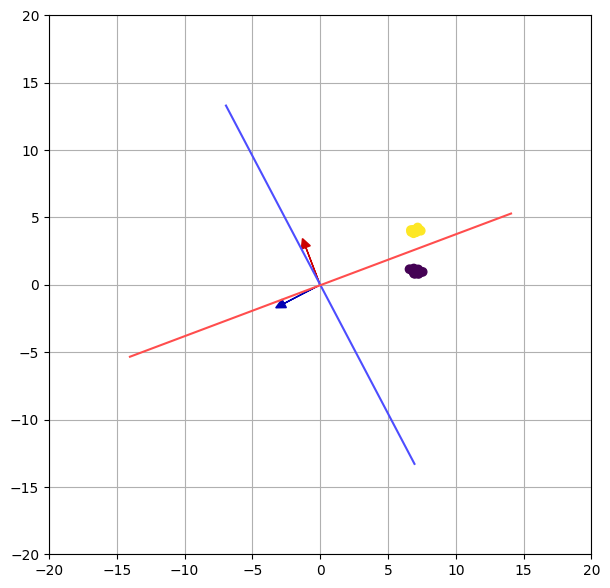

In [78]:
n_tasks = 10000

print_freq = 250
task_count = 0
avg_loss = 0
loss_all = []
acc_all = []
enable_plotting = True
plot_decision_boundary = True
optimizer.zero_grad()


for i in np.arange(n_tasks):
  X, y = make_task(n=20)

  X_support, y_support, X_query, y_query = split_support_query(X, y)

  A, B, C = get_vector(model)

  loss, task_accuracy, positions = model.set_forward_loss(X_support, y_support, X_query, y_query)

  avg_loss = avg_loss + loss.item()#.data[0]
  loss_all.append(loss)
  acc_all.append(task_accuracy)

  task_count += 1

  if task_count == model.n_task: #MAML update several tasks at one time
      loss_q = torch.stack(loss_all).sum(0)
      loss_q.backward()

      optimizer.step()
      task_count = 0
      loss_all = []

  optimizer.zero_grad()
  if i % print_freq==0:
      acc_all_np  = np.asarray(acc_all)
      acc_mean = np.mean(acc_all_np)
      print('Epoch {:d} | Loss {:f} | Acc {:4.2f}% | Task Acc {:4.2f}%'.format(i, avg_loss/float(i+1), acc_mean, task_accuracy))

  # to jest połączony saport z query wiec podziel na dwa tak, żeby w saport i qery było po tylesamo 0 i 1, pół na pół
  if enable_plotting and i % print_freq == 0:
    figs, axs = plt.subplots(1,1, figsize=(7, 7))
    plt.scatter(X[:,0], X[:,1], c=y)
    axs.set_xlim([-20,20])
    axs.set_ylim([-20,20])

    if plot_decision_boundary:
      A_fast, B_fast, C_fast = get_fast_vector(model)

      scale = 3

      x_step = np.absolute(B) * (15 / np.sqrt((np.power(A, 2) + np.power(B, 2))))
      x_arg = np.arange(-x_step, x_step + 0.1, 0.1)

      x_fast_step = np.absolute(B_fast) * (15 / np.sqrt((np.power(A_fast, 2) + np.power(B_fast, 2))))
      x_fast_arg = np.arange(-x_fast_step, x_fast_step + 0.1, 0.1)

      yx_fast = (-A_fast/B_fast)*x_fast_arg-(C_fast/B_fast)
      yx = (-A/B)*x_arg-(C/B)

      arr_length1 = np.sqrt(np.power(A, 2) + np.power(B, 2))
      arr_length2 = np.sqrt(np.power(A_fast, 2) + np.power(B_fast, 2))

      dx = scale*A/arr_length1
      dy = scale*B/arr_length1
      dx_fast = scale*A_fast/arr_length2
      dy_fast = scale*B_fast/arr_length2

      plt.arrow(0, -(C/B), dx, dy, head_width=0.7, head_length=0.7, fc='#0000b3', ec='#0000b3')
      plt.arrow(0, -(C_fast/B_fast), dx_fast, dy_fast, head_width=0.7, head_length=0.7, fc='#cc0000', ec='#cc0000')
      plt.plot(x_arg, yx, c='#4d4dff')
      plt.plot(x_fast_arg, yx_fast, c='#ff4d4d')

    plt.grid()
    plt.show()



HyperMAML adaptation to all 4 tasks

Epoch 1 | Loss 0.000000 | Acc 95.00% | Task Acc 95.00%
1 6.977582 -6.977581977844238 7.022404670715332 -13.255375359342565 13.38653243567353
Epoch 2 | Loss 0.000000 | Acc 95.00% | Task Acc 95.00%
2 6.724732 -6.724731922149658 6.77525520324707 -13.436975410915352 13.480025319573997
Epoch 3 | Loss 0.000000 | Acc 95.00% | Task Acc 95.00%
3 14.084743 -14.084742546081543 14.115365028381348 -5.192906873043597 5.137226661985352
Epoch 4 | Loss 0.000000 | Acc 95.00% | Task Acc 95.00%
4 14.217093 -14.217093467712402 14.283015251159668 -4.745860586013862 4.841724690537205


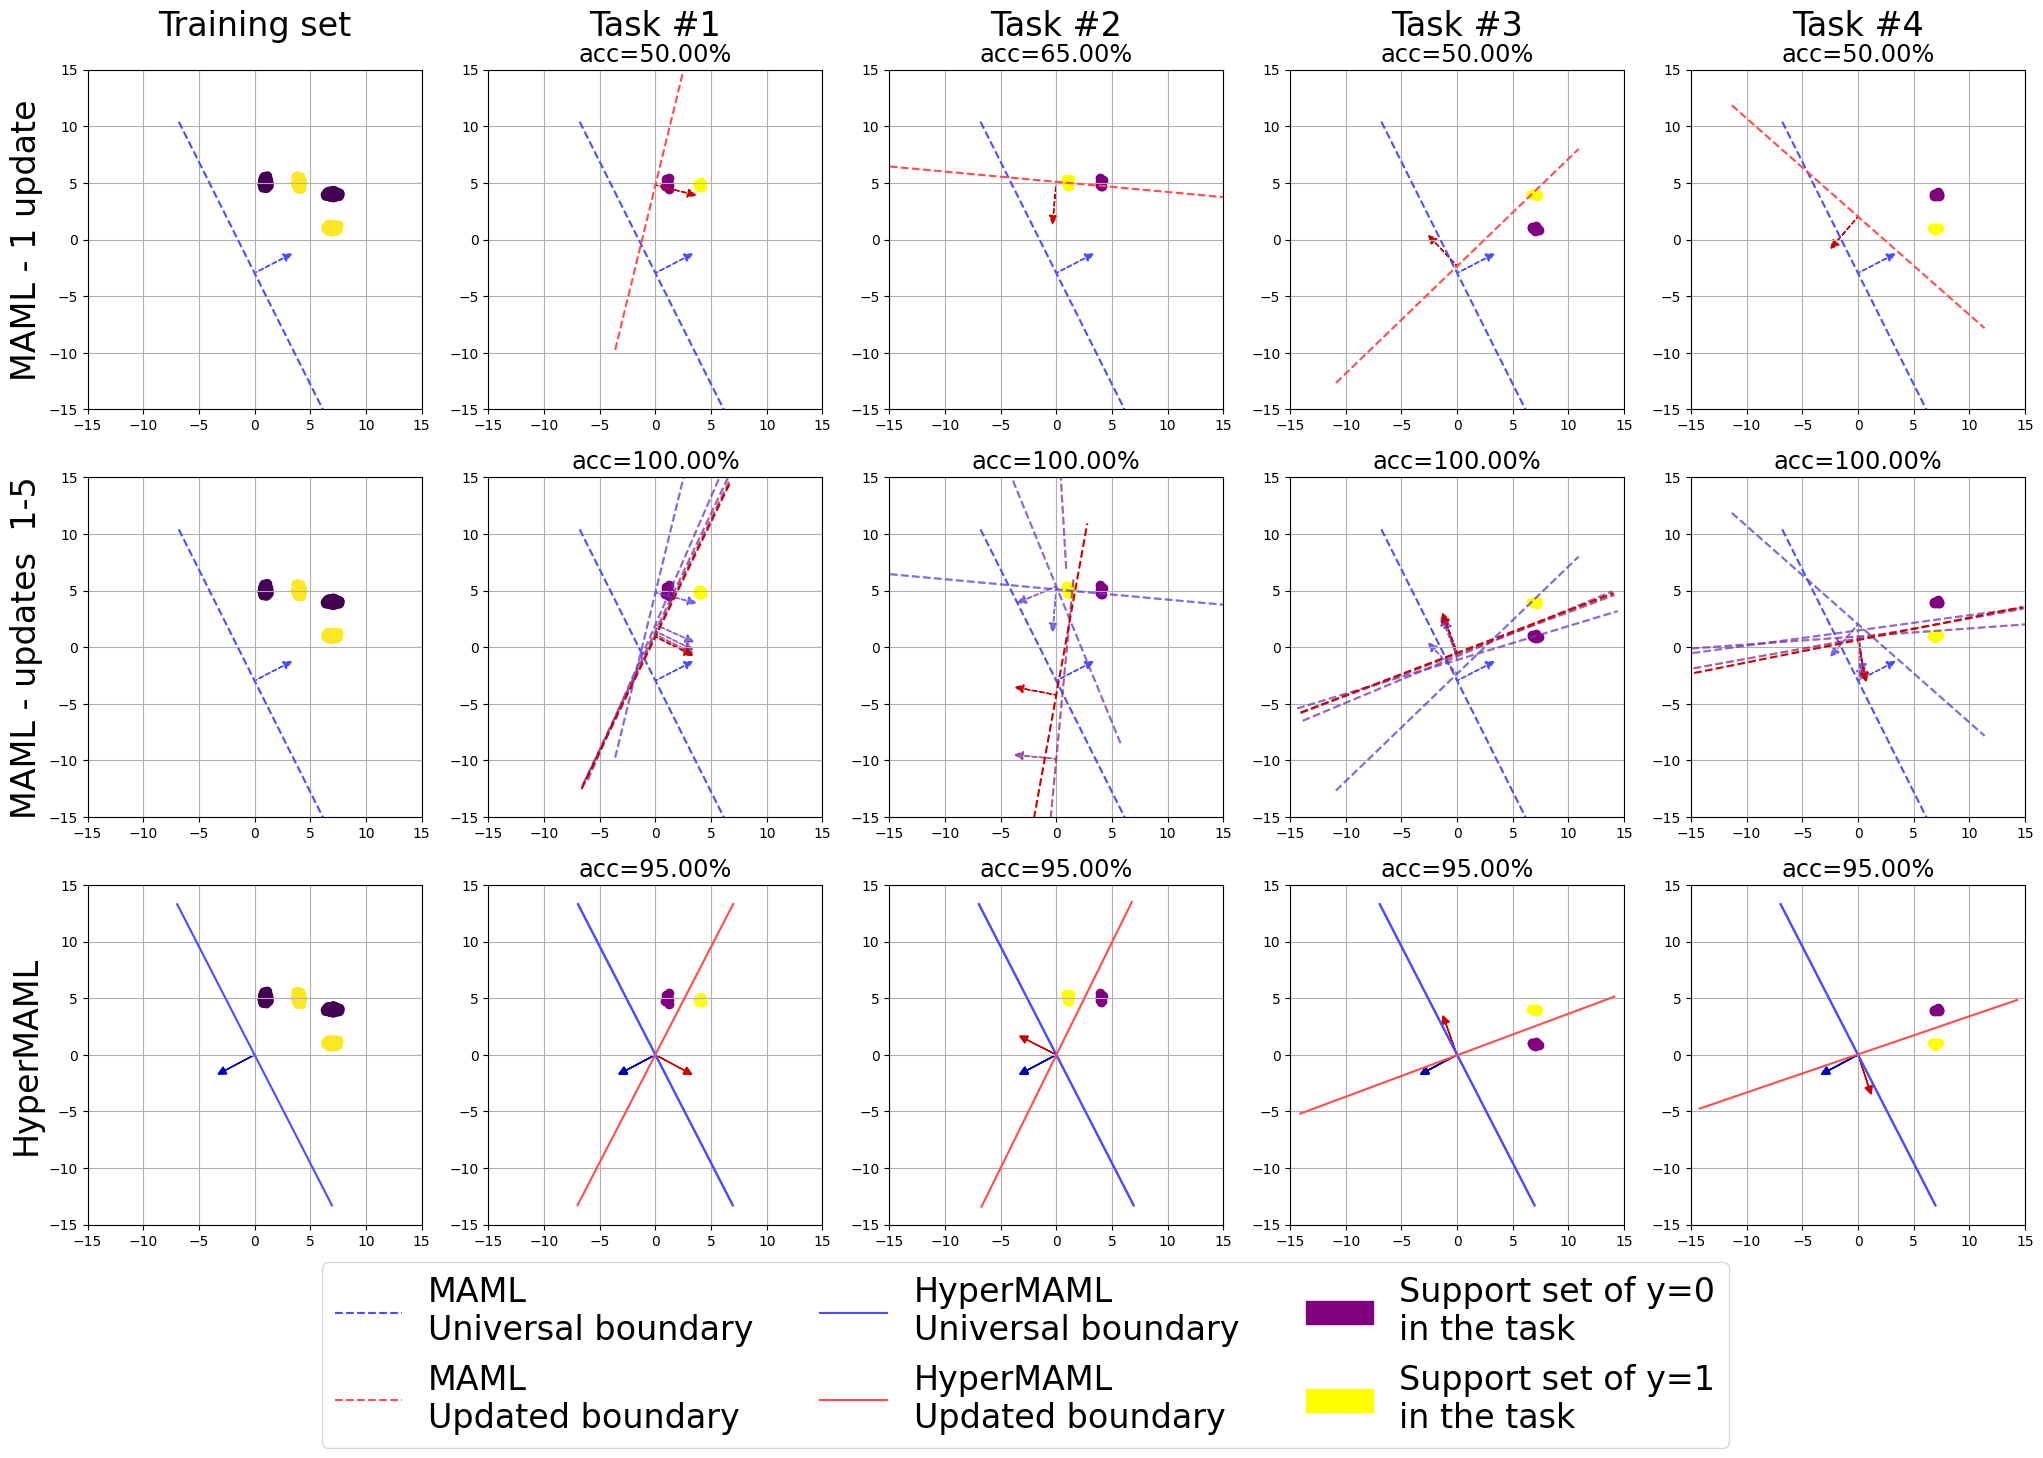

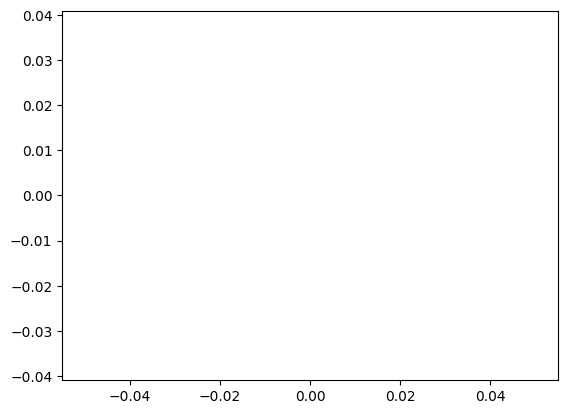

In [79]:
n = 20
task_count = 0
avg_loss = 0
loss_all = []
acc_all = []
np.random.seed(seed)
tasks = [sample_task_I(n, False), sample_task_I(n, True), sample_task_II(n, False), sample_task_II(n, True)]
plot_decision_boundary = True

for a in ax[-1, :]:
  a.plot(x_arg, yx, c='#4d4dff', label="Universal weights")
  a.arrow(0, -(C/B), dx, dy, head_width=0.7, head_length=0.7, fc='#0000b3', ec='#0000b3')

for i, task in enumerate(tasks, 1):
  X, y = task

  X_support, y_support, X_query, y_query = split_support_query(X, y)

  A, B, C = get_vector(model)

  loss, task_accuracy, positions = model.set_forward_loss(X_support, y_support, X_query, y_query)
  if task_accuracy == 100:
    task_accuracy = 95.
  avg_loss = avg_loss + loss.item()
  loss_all.append(loss)
  acc_all.append(task_accuracy)

  task_count += 1

  acc_all_np  = np.asarray(acc_all)
  acc_mean = np.mean(acc_all_np)
  print('Epoch {:d} | Loss {:f} | Acc {:4.2f}% | Task Acc {:4.2f}%'.format(i, avg_loss/float(i+1), acc_mean, task_accuracy))

  # figs, axs = plt.subplots(1,1, figsize=(7, 7))
  # plt.scatter(X_all[:,0], X_all[:,1], c=y_all, alpha =0.02)
  # plt.scatter(X[:,0], X[:,1], c=y)
  # axs.set_xlim([-20,20])
  # axs.set_ylim([-20,20])

  if plot_decision_boundary:
    A_fast, B_fast, C_fast = get_fast_vector(model)

    scale = 3

    x_step = np.absolute(B) * (15 / np.sqrt((np.power(A, 2) + np.power(B, 2))))
    x_arg = np.arange(-x_step, x_step + 0.1, 0.1)

    x_fast_step = np.absolute(B_fast) * (15 / np.sqrt((np.power(A_fast, 2) + np.power(B_fast, 2))))
    x_fast_arg = np.arange(-x_fast_step, x_fast_step + 0.1, 0.1)

    yx_fast = (-A_fast/B_fast)*x_fast_arg-(C_fast/B_fast)
    yx = (-A/B)*x_arg-(C/B)

    print(i, x_fast_step, x_fast_arg[0], x_fast_arg[-1], yx_fast[0], yx_fast[-1])
    ar_x_fast = 0
    ar_y_fast =  -(C_fast/B_fast)

    if x_fast_step < np.sqrt((15**2) / 2):
      ar_x_fast =  -(C_fast/A_fast)
      ar_y_fast = 0
      # print("dupa", i)
      y_fast_step =  np.absolute(A_fast) * (15 / np.sqrt((np.power(A_fast, 2) + np.power(B_fast, 2))))
      yx_fast = np.arange(-y_fast_step, y_fast_step+0.1, 0.1 )
      x_fast_arg = (yx_fast + (C_fast/B_fast)) / (-A_fast/B_fast)


    arr_length1 = np.sqrt(np.power(A, 2) + np.power(B, 2))
    arr_length2 = np.sqrt(np.power(A_fast, 2) + np.power(B_fast, 2))

    dx = scale*A/arr_length1
    dy = scale*B/arr_length1
    dx_fast = scale*A_fast/arr_length2
    dy_fast = scale*B_fast/arr_length2

    ax[-1, i].arrow(0, -(C/B), dx, dy, head_width=0.7, head_length=0.7, fc='#0000b3', ec='#0000b3')
    ax[-1, i].arrow(ar_x_fast, ar_y_fast, dx_fast, dy_fast, head_width=0.7, head_length=0.7, fc='#cc0000', ec='#cc0000')

    ax[-1,i].plot(x_arg, yx, c='#4d4dff', label="Universal weights")
    ax[-1,i].plot(x_fast_arg, yx_fast, c='#ff4d4d', label="Updated weights")
    ax[-1, i].set_title(f"acc={task_accuracy:.2f}%", fontsize="xx-large")
    plt.axis("equal")

  # plt.grid()
  # plt.legend(fontsize=16, loc='upper right')
  # plt.show()

fig.savefig('fig.pdf', bbox_inches='tight')
fig

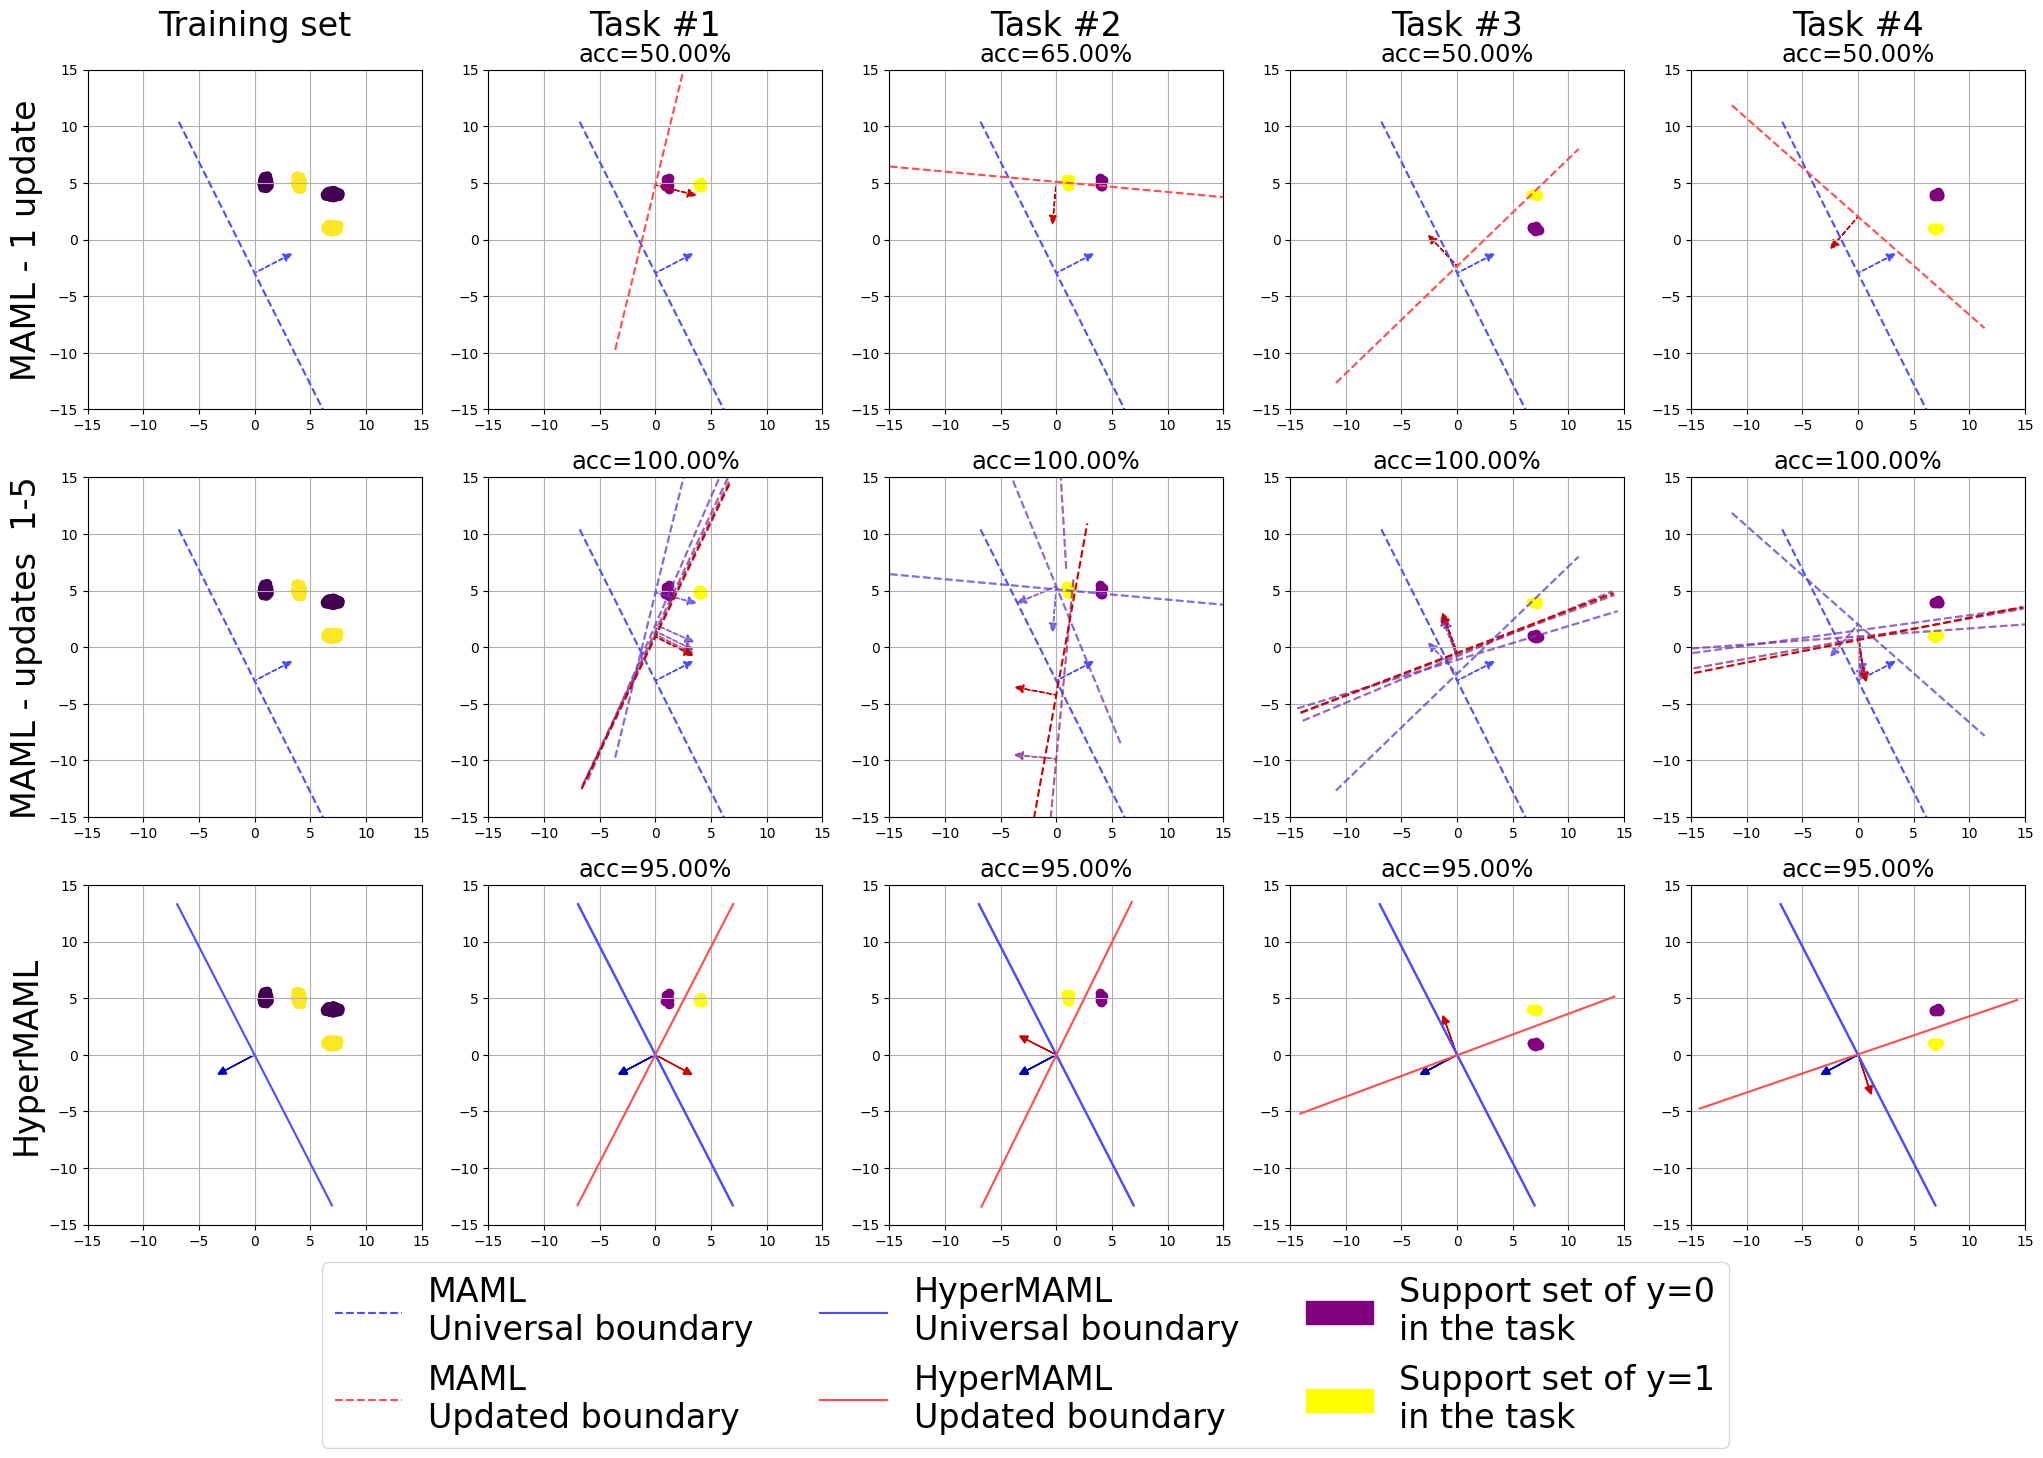

In [80]:
fig

In [81]:
fig.savefig('fig.png', bbox_inches='tight')

Epoch 0 | Loss 0.000000 | Acc 100.00% | Task Acc 100.00%


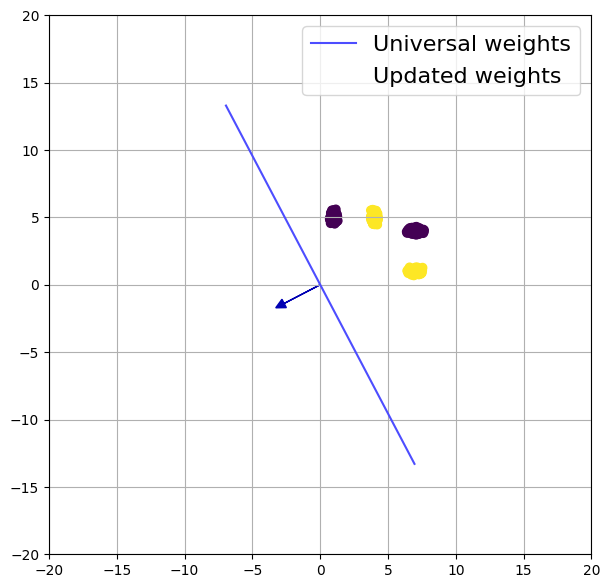

Epoch 1 | Loss 0.000000 | Acc 100.00% | Task Acc 100.00%


<Figure size 640x480 with 0 Axes>

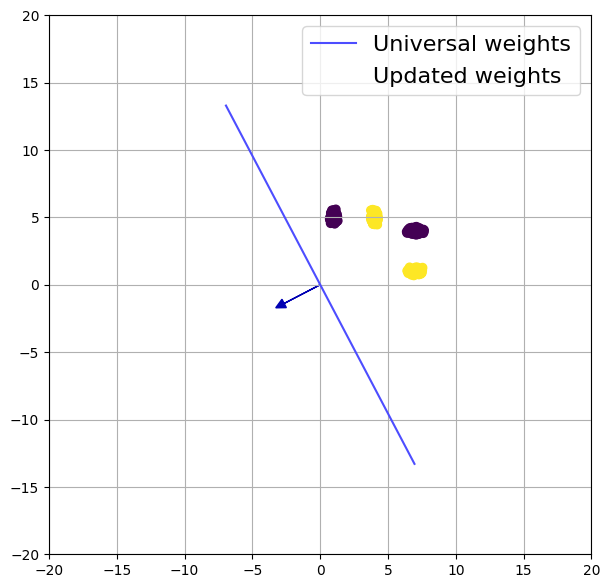

Epoch 2 | Loss 0.000000 | Acc 100.00% | Task Acc 100.00%


<Figure size 640x480 with 0 Axes>

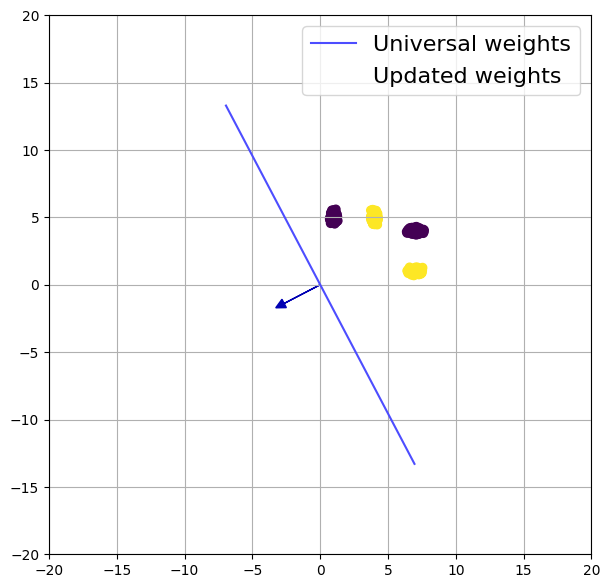

Epoch 3 | Loss 0.000000 | Acc 100.00% | Task Acc 100.00%


<Figure size 640x480 with 0 Axes>

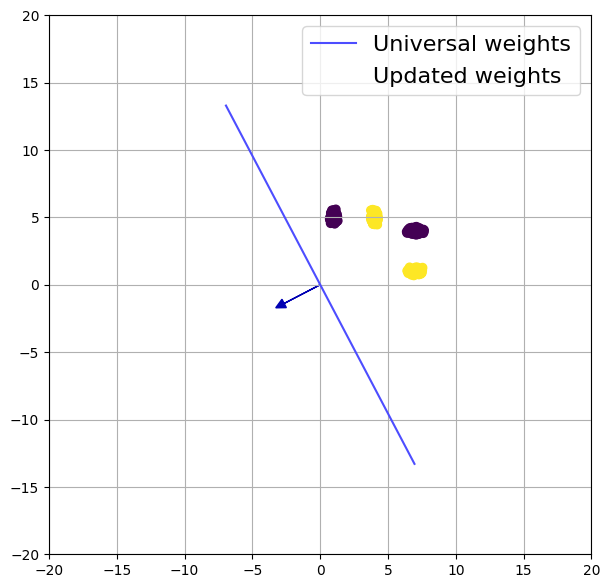

<Figure size 640x480 with 0 Axes>

In [82]:
n = 20
task_count = 0
avg_loss = 0
loss_all = []
acc_all = []
tasks = [sample_task_I(n, False), sample_task_I(n, True), sample_task_II(n, False), sample_task_II(n, True)]
plot_decision_boundary = True

for i, task in enumerate(tasks):
  X, y = task

  X_support, y_support, X_query, y_query = split_support_query(X, y)

  A, B, C = get_vector(model)

  loss, task_accuracy, positions = model.set_forward_loss(X_support, y_support, X_query, y_query)

  avg_loss = avg_loss + loss.item()
  loss_all.append(loss)
  acc_all.append(task_accuracy)

  task_count += 1

  acc_all_np  = np.asarray(acc_all)
  acc_mean = np.mean(acc_all_np)
  print('Epoch {:d} | Loss {:f} | Acc {:4.2f}% | Task Acc {:4.2f}%'.format(i, avg_loss/float(i+1), acc_mean, task_accuracy))

  figs, axs = plt.subplots(1,1, figsize=(7, 7))
  plt.scatter(X_all[:,0], X_all[:,1], c=y_all, alpha =1)
  # plt.scatter(X[:,0], X[:,1], c=y)
  axs.set_xlim([-20,20])
  axs.set_ylim([-20,20])

  if plot_decision_boundary:
    A_fast, B_fast, C_fast = get_fast_vector(model)

    scale = 3

    x_step = np.absolute(B) * (15 / np.sqrt((np.power(A, 2) + np.power(B, 2))))
    x_arg = np.arange(-x_step, x_step + 0.1, 0.1)

    x_fast_step = np.absolute(B_fast) * (15 / np.sqrt((np.power(A_fast, 2) + np.power(B_fast, 2))))
    x_fast_arg = np.arange(-x_fast_step, x_fast_step + 0.1, 0.1)

    yx_fast = (-A_fast/B_fast)*x_fast_arg-(C_fast/B_fast)
    yx = (-A/B)*x_arg-(C/B)

    arr_length1 = np.sqrt(np.power(A, 2) + np.power(B, 2))
    arr_length2 = np.sqrt(np.power(A_fast, 2) + np.power(B_fast, 2))

    dx = scale*A/arr_length1
    dy = scale*B/arr_length1
    dx_fast = scale*A_fast/arr_length2
    dy_fast = scale*B_fast/arr_length2

    plt.arrow(0, -(C/B), dx, dy, head_width=0.7, head_length=0.7, fc='#0000b3', ec='#0000b3')
    plt.arrow(0, -(C_fast/B_fast), dx_fast, dy_fast, head_width=0.7, head_length=0.7, fc='#cc0000', ec='#cc0000',alpha=0)
    plt.plot(x_arg, yx, c='#4d4dff', label="Universal weights")
    plt.plot(x_fast_arg, yx_fast, c='#ff4d4d', label="Updated weights",alpha=0)
    # plt.axis("equal")

  plt.grid()
  plt.legend(fontsize=16, loc='upper right')
  plt.show()

  plt.savefig('fig.pdf', bbox_inches='tight')

In [83]:
def radius_transform(radius: Tensor) -> Tensor:
    product = 1
    for dim in list(radius.size()):
        product = dim

    return radius / product


In [84]:
def interval_forward(
        x: Tensor,
        weight: Tensor,
        radius: Tensor,
        bias: Tensor | None = None,
        bias_radius: Tensor | None = None
) -> Tensor:
    x = x.rename(None)
    tiler = [1] * (len(x.shape) + 1)
    tiler[1] = 3
    x = x.unsqueeze(1).tile(tiler)
    x = x.refine_names("N", "bounds", "features")
    assert (x.rename(None) >= 0.0).all(), "All input features must be non-negative."

    x_lower, x_middle, x_upper = map(lambda x_: cast(Tensor, x_.rename(None)), x.unbind("bounds"))
    assert (x_lower <= x_middle).all(), "Lower bound must be less than or equal to middle bound."
    assert (x_middle <= x_upper).all(), "Middle bound must be less than or equal to upper bound."


    w_middle = weight
    w_lower = weight - radius_transform(radius)
    w_upper = weight + radius_transform(radius)

    w_lower_pos = w_lower.clamp(min=0)
    w_lower_neg = w_lower.clamp(max=0)
    w_upper_pos = w_upper.clamp(min=0)
    w_upper_neg = w_upper.clamp(max=0)

    # Further splits only needed for numeric stability with asserts
    w_middle_pos = w_middle.clamp(min=0)
    w_middle_neg = w_middle.clamp(max=0)

    lower = x_lower @ w_lower_pos.t() + x_upper @ w_lower_neg.t()
    upper = x_upper @ w_upper_pos.t() + x_lower @ w_upper_neg.t()
    middle = x_middle @ w_middle_pos.t() + x_middle @ w_middle_neg.t()

    if bias is not None:
        bias_scale = 1.0 # TODO: Implement bias scaling
        b_middle = bias + bias_scale * radius_transform(bias_radius)
        b_lower = b_middle - bias_scale * radius_transform(bias_radius)
        b_upper = b_middle + bias_scale * radius_transform(bias_radius)
        lower = lower + b_lower
        upper = upper + b_upper
        middle = middle + b_middle

    assert (lower <= middle).all(), "Lower bound must be less than or equal to middle bound."
    assert (middle <= upper).all(), "Middle bound must be less than or equal to upper bound."

    return torch.stack([lower, middle, upper], dim=1).refine_names("N", "bounds", "features")

In [85]:
def robust_output(output_lower, output_higher, target, num_classes):
    """Get the robust version of the current output.
    Returns
    -------
    Tensor
        Robust output logits (lower bound for correct class, upper bounds for incorrect classes).
    """
    y_oh = F.one_hot(target, num_classes=num_classes)
    return torch.where(y_oh.bool(), output_lower.rename(None), output_higher.rename(None))

In [86]:
class IntervalHyperNet(nn.Module):
    def __init__(self, hn_hidden_size, embedding_size, out_neurons, hn_head_len, hn_activation=None):
        super(IntervalHyperNet, self).__init__()

        self.hn_head_len = hn_head_len
        self.hn_activation = hn_activation

        if self.hn_head_len > 2:
            layers = [nn.Linear(embedding_size, hn_hidden_size)]
            layers.append(nn.ReLU())

            for i in range(self.hn_head_len - 2):
                layers.append(nn.Linear(hn_hidden_size, hn_hidden_size))
                layers.append(nn.ReLU())

            layers.append(nn.Linear(hn_hidden_size, hn_hidden_size))
            if self.hn_activation == 'sigmoid':
                layers.append(nn.Sigmoid())

            self.layers = nn.Sequential(*layers)
        else:
            layers = [nn.Linear(embedding_size, hn_hidden_size)]
            self.layers = nn.Sequential(*layers)

        tail_mean = [nn.Linear(hn_hidden_size, out_neurons)]
        tail_logvar = [nn.Linear(hn_hidden_size, out_neurons)]

        self.tail_mean = nn.Sequential(*tail_mean)
        self.tail_radius = nn.Sequential(*tail_logvar)

    def forward(self, x):
        out = self.layers(x)
        out_mean = self.tail_mean(out)
        out_radius = self.tail_radius(out)
        return out_mean, out_radius

In [87]:
class IntervalLinear_fw(nn.Linear): #used in IntervalHyperMAML to forward input with fast weight
    def __init__(self, in_features, out_features):
        super(IntervalLinear_fw, self).__init__(in_features, out_features)
        self.weight.fast = None #Lazy hack to add fast weight link
        self.bias.fast = None
        self.weight.radius = None
        self.bias.radius = None

    def forward(self, x):
        if self.weight.fast is not None and self.bias.fast is not None and self.weight.radius is not None and self.bias.radius is not None:
            out = interval_forward(x, self.weight.fast, self.weight.radius, self.bias.fast, self.bias.radius)
        else:
            out = super(Linear_fw, self).forward(x)
        return out

In [129]:
class IntervalHyperMAML(MAML):
    def __init__(self, n_way, n_support, n_query, approx = False, hn_head_len: int =2, hn_hidden_size=512):
        super(IntervalHyperMAML, self).__init__(n_way, n_support, n_query)
        self.feat_dim = 2

        self.loss_fn = nn.BCELoss()
        self.classifier = IntervalLinear_fw(self.feat_dim, 1)
        self.classifier.bias.data.fill_(0)

        self.enhance_embeddings = False

        self.n_task = 4
        self.task_update_num = 5
        self.train_lr = 0.01
        self.approx = approx # first order approx.

        self.hn_head_len = hn_head_len
        self.hn_embeddings_strategy = None
        self.hn_hidden_size = 512
        self.hn_lambda = 0.0
        self.hn_save_delta_params = False
        self.hn_save_radiuses = False
        self.hn_use_class_batch_input = False
        self.hn_adaptation_strategy = None
        self.hm_support_set_loss = False
        self.hm_maml_warmup = False
        self.hm_maml_warmup_epochs = 50
        self.hm_maml_warmup_switch_epochs = 50
        self.hm_maml_update_feature_net = False
        self.hm_update_operator = 'minus'
        self.hm_load_feature_net = False
        self.hm_feature_net_path = ''
        self.hm_detach_feature_net = False
        self.hm_detach_before_hyper_net = False
        self.hm_set_forward_with_adaptation = False
        self.hn_val_lr = 1e-4
        self.hn_val_epochs = 0
        self.hn_val_optim = 'adam'

        self.alpha = 0
        self.hn_alpha_step = 0

        self.radius_list = []

        if self.hn_adaptation_strategy == 'increasing_alpha' and self.hn_alpha_step < 0:
            raise ValueError('hn_alpha_step is not positive!')

        self.single_test = False
        self.epoch = -1
        self.start_epoch = -1
        self.stop_epoch = -1

        self.calculate_embedding_size()

        self._init_hypernet_modules()
        self._init_feature_net()

        self.current_epoch_nr = 0
        # Interval specific variables
        self.eps = 0
        self.eps_pump_epochs = 10
        self.eps_pump_value = 0.0015
        self.radius_eps_warmup_epochs = 300
        self.worst_case_loss_multiplier = 6

    def _init_feature_net(self):
        if self.hm_load_feature_net:
            print(f'loading feature net model from location: {self.hm_feature_net_path}')
            model_dict = torch.load(self.hm_feature_net_path)
            self.feature.load_state_dict(model_dict['state'])

    def _init_hypernet_modules(self):
        target_net_param_dict = get_param_dict(self.classifier)

        target_net_param_dict = {
            name.replace(".", "-"): p
            # replace dots with hyphens bc torch doesn't like dots in modules names
            for name, p in target_net_param_dict.items()
        }

        self.target_net_param_shapes = {
            name: p.shape
            for (name, p)
            in target_net_param_dict.items()
        }

        self.hypernet_heads = nn.ModuleDict()

        for name, param in target_net_param_dict.items():
            if self.hn_use_class_batch_input and name[-4:] == 'bias':
                continue

            bias_size = param.shape[0] // self.n_way

            head_in = self.embedding_size
            head_out = (param.numel() // self.n_way) + bias_size if self.hn_use_class_batch_input else param.numel()
            head_modules = []

            self.hypernet_heads[name] = IntervalHyperNet(self.hn_hidden_size, head_in, head_out, self.hn_head_len)

    def calculate_embedding_size(self):
        if self.hn_use_class_batch_input:
            if self.enhance_embeddings:
                self.embedding_size = self.n_support * (self.feat_dim + self.n_way + 1)
            else:
                self.embedding_size = self.n_support * self.feat_dim
        else:
            if self.hn_embeddings_strategy == 'class_mean':
                if self.enhance_embeddings:
                    self.embedding_size = self.n_way * (self.feat_dim + self.n_way + 1)
                else:
                    self.embedding_size = self.n_way * self.feat_dim
            else:
                if self.enhance_embeddings:
                    self.embedding_size = self.n_way * self.n_support * (self.feat_dim + self.n_way + 1)
                else:
                    self.embedding_size = self.n_way * self.n_support * self.feat_dim

    def apply_embeddings_strategy(self, embeddings):
        if self.hn_embeddings_strategy == 'class_mean':
            new_embeddings = torch.zeros(self.n_way, *embeddings.shape[1:])

            for i in range(self.n_way):
                lower = i * self.n_support
                upper = (i + 1) * self.n_support
                new_embeddings[i] = embeddings[lower:upper, :].mean(dim=0)

            return new_embeddings.cuda()

        return embeddings

    def get_support_data_labels(self):
        if self.hn_embeddings_strategy == 'class_mean':
            return torch.from_numpy(np.repeat(range(self.n_way), 1)).cuda()

        return torch.from_numpy(np.repeat(range(self.n_way), self.n_support)).cuda() # labels for support data

    def get_hn_delta_params(self, support_embeddings):
        if self.hm_detach_before_hyper_net:
            support_embeddings = support_embeddings.detach()

        if self.hn_use_class_batch_input:
            delta_params_list = []
            radius_list = []

            for name, param_net in self.hypernet_heads.items():
                delta = []
                bias_delta = []
                radiuses = []
                bias_radiuses = []

                lower = 0
                upper = self.n_support

                for i in range(self.n_way):
                    class_embeddings = support_embeddings[lower:upper]
                    class_embeddings = class_embeddings.flatten()
                    delta_params, radius = param_net(class_embeddings)

                    bias_neurons_num = self.target_net_param_shapes[name][0] // 5

                    class_delta = delta_params[:-bias_neurons_num]
                    class_bias_delta = delta_params[-bias_neurons_num:]
                    class_radius = radius[:-bias_neurons_num]
                    class_bias_radius = radius[-bias_neurons_num:]


                    if self.hn_adaptation_strategy == 'increasing_alpha' and self.alpha < 1:
                        class_delta = self.alpha * class_delta
                        class_bias_delta = self.alpha * class_bias_delta

                    delta.append(class_delta)
                    bias_delta.append(class_bias_delta)
                    radiuses.append(class_radius)
                    bias_radiuses.append(class_bias_radius)

                    lower += self.n_support
                    upper += self.n_support

                delta_params_list.append(torch.stack(delta).reshape(self.target_net_param_shapes[name]))
                delta_params_list.append(torch.cat(bias_delta, dim=0))
                radius_list.append(torch.stack(radiuses).reshape(self.target_net_param_shapes[name]))
                radius_list.append(torch.cat(bias_radiuses, dim=0))

            return delta_params_list, radius_list
        else:
            delta_params_list = []
            radius_list = []

            for name, param_net in self.hypernet_heads.items():
                flattened_embeddings = support_embeddings.flatten()
                delta, radius = param_net(flattened_embeddings)

                if name in self.target_net_param_shapes.keys():
                    delta = delta.reshape(self.target_net_param_shapes[name])
                    radius = radius.reshape(self.target_net_param_shapes[name])

                if self.hn_adaptation_strategy == 'increasing_alpha' and self.alpha < 1:
                    delta = self.alpha * delta

                delta_params_list.append(delta)
                radius_list.append(radius)

            return delta_params_list, radius_list


    def _update_weight(self, weight, update_value):
        if self.hm_update_operator == 'minus':
            if weight.fast is None:
                weight.fast = weight - update_value
            else:
                weight.fast = weight.fast - update_value
        elif self.hm_update_operator == 'plus':
            if weight.fast is None:
                weight.fast = weight + update_value
            else:
                weight.fast = weight.fast + update_value
        elif self.hm_update_operator == 'multiply':
            if weight.fast is None:
                weight.fast = weight * update_value
            else:
                weight.fast = weight.fast * update_value

    def _update_radius(self, weight, update_value):
        weight.radius = torch.abs(update_value) + self.eps

    def _get_p_value(self):
        if self.epoch < self.hm_maml_warmup_epochs:
            return 1.0
        elif self.hm_maml_warmup_epochs <= self.epoch < self.hm_maml_warmup_epochs + self.hm_maml_warmup_switch_epochs:
            return (self.hm_maml_warmup_switch_epochs + self.hm_maml_warmup_epochs - self.epoch) / (self.hm_maml_warmup_switch_epochs + 1)
        return 0.0

    def _update_network_weights(self, delta_params_list, radius_list, support_embeddings, support_data_labels):
        if self.hm_maml_warmup and not self.single_test:
            p = self._get_p_value()

            if p > 0.0:
                fast_parameters = []

                if self.hm_maml_update_feature_net:
                    fet_fast_parameters = list(self.feature.parameters())
                    for weight in self.feature.parameters():
                        weight.fast = None
                    self.feature.zero_grad()
                    fast_parameters = fast_parameters + fet_fast_parameters

                clf_fast_parameters = list(self.classifier.parameters())
                for weight in self.classifier.parameters():
                    weight.fast = None
                self.classifier.zero_grad()
                fast_parameters = fast_parameters + clf_fast_parameters

                for task_step in range(self.task_update_num):
                    scores = self.classifier(support_embeddings)
                    set_loss = self.loss_fn(scores, support_data_labels)

                    grad = torch.autograd.grad(set_loss, fast_parameters, create_graph=True, allow_unused=True) #build full graph support gradient of gradient

                    if self.approx:
                        grad = [ g.detach()  for g in grad ] #do not calculate gradient of gradient if using first order approximation

                    if self.hm_maml_update_feature_net:
                        # update weights of feature networ
                        for k, weight in enumerate(self.feature.parameters()):
                            update_value = self.train_lr * p * grad[k]
                            self._update_weight(weight, update_value)

                    classifier_offset = len(fet_fast_parameters) if self.hm_maml_update_feature_net else 0

                    if p == 1:
                        # update weights of classifier network by adding gradient
                        for k, weight in enumerate(self.classifier.parameters()):
                            update_value = (self.train_lr * grad[classifier_offset + k])
                            self._update_weight(weight, update_value)

                    elif 0.0 < p < 1.0:
                        # update weights of classifier network by adding gradient and output of hypernetwork
                        for k, weight in enumerate(self.classifier.parameters()):
                            update_value = ((self.train_lr * p * grad[classifier_offset + k]) + ((1 - p) * delta_params_list[k]))
                            update_radius_value = radius_list[k]
                            self._update_weight(weight, update_value)
                            self._update_radius(weight, update_radius_value)
            else:
                for k, weight in enumerate(self.classifier.parameters()):
                    update_value = delta_params_list[k]
                    update_radius_value = radius_list[k]
                    self._update_weight(weight, update_value)
                    self._update_radius(weight, update_radius_value)
        else:
            for k, weight in enumerate(self.classifier.parameters()):
                update_value = delta_params_list[k]
                update_radius_value = radius_list[k]
                self._update_weight(weight, update_value)
                self._update_radius(weight, update_radius_value)


    def _get_list_of_delta_params(self, maml_warmup_used, support_embeddings, support_data_labels):
        if not maml_warmup_used:
            enhanced_support_embeddings = self.apply_embeddings_strategy(support_embeddings)

            if self.enhance_embeddings:
                with torch.no_grad():
                    logits = self.classifier.forward(enhanced_support_embeddings).detach()
                    logits = F.softmax(logits, dim=1)

                labels = support_data_labels.view(enhanced_support_embeddings.shape[0], -1)
                enhanced_support_embeddings = torch.cat((enhanced_support_embeddings, logits, labels), dim=1)

            for weight in self.parameters():
                weight.fast = None
            self.zero_grad()

            delta_params, radiuses = self.get_hn_delta_params(enhanced_support_embeddings)

            if self.hn_save_delta_params and len(self.delta_list) == 0:
                self.delta_list = [{'delta_params': delta_params}]
            if self.hn_save_radiuses and len(self.radius_list) == 0:
                self.radius_list.append({'radiuses': radiuses})

            return delta_params, radiuses
        else:
            return [torch.zeros(*i).cuda() for (_, i) in self.target_net_param_shapes.items()], [torch.zeros(*i).cuda() for (_, i) in self.target_net_param_shapes.items()]

    def forward(self, x):
        if self.classifier.weight.fast is None or self.classifier.bias.fast is None or self.classifier.weight.radius is None or self.classifier.bias.radius is None:
            return None, torch.sigmoid(self.classifier(x)), None
        out = self.classifier(x)
        out = out.refine_names("N", "bounds", ...)
        out_lower, out_middle, out_upper = map(lambda out_: cast(Tensor, out_.rename(None)), out.unbind("bounds"))
        out_lower = torch.sigmoid(out_lower)
        out_middle = torch.sigmoid(out_middle)
        out_upper = torch.sigmoid(out_upper)
        return out_lower, out_middle, out_upper


    def set_forward(self, X_support, y_support, X_query, is_feature = False, train_stage = False):
        assert is_feature == False, 'MAML do not support fixed feature'

        maml_warmup_used = ((not self.single_test) and self.hm_maml_warmup and (self.epoch < self.hm_maml_warmup_epochs))

        delta_params_list, radius_list = self._get_list_of_delta_params(maml_warmup_used, X_support, y_support)

        self._update_network_weights(delta_params_list, radius_list, X_support, y_support)

        if self.hm_set_forward_with_adaptation and not train_stage:
            scores_lower, scores_middle, scores_upper = self.forward(X_support)
            return scores_lower, scores_middle, scores_upper
        else:
            if self.hm_support_set_loss and train_stage and not maml_warmup_used:
                X_query = torch.cat((X_support, X_query))

            scores_lower, scores_middle, scores_upper = self.forward(X_query)

            return scores_lower, scores_middle, scores_upper

    def set_forward_loss(self, X_support, y_support, X_query, y_query):
        if self.current_epoch_nr % self.eps_pump_epochs == 0 and self.current_epoch_nr > self.radius_eps_warmup_epochs:
            self.eps = self.eps + self.eps_pump_value

        scores_lower, scores_middle, scores_upper = self.set_forward(X_support, y_support, X_query, is_feature = False)
        if scores_lower is not None and scores_upper is not None:
            worst_case_pred = robust_output(scores_lower, scores_upper, y_query.long(), num_classes=2)
            y_pred = worst_case_pred[:, 1].unsqueeze(1).rename(None)
            y_query = y_query.unsqueeze(1)
            loss = self.worst_case_loss_multiplier * self.loss_fn(y_pred, y_query) + self.loss_fn(scores_middle, y_query)
            worst_case_predictions = (y_pred > 0.5)
            worst_case_positions = (worst_case_predictions == y_query)
            worst_case_task_accuracy = (worst_case_positions.sum() / worst_case_predictions.size()[0]) * 100
        else:
            y_query = y_query.unsqueeze(1)
            loss = self.loss_fn(scores_middle, y_query)

        predictions  = (scores_middle > 0.5)
        positions = (predictions == y_query)
        task_accuracy = (positions.sum() / predictions.size()[0]) * 100

        return loss, task_accuracy, worst_case_task_accuracy, positions.squeeze(), worst_case_positions.squeeze()

    def train_loop(self, epoch, train_loader, optimizer): #overwrite parrent function
        print_freq = 10
        avg_loss=0
        task_count = 0
        loss_all = []
        acc_all = []
        acc_wc_all = []
        optimizer.zero_grad()

        self.delta_list = []

        #train
        for i, (x,_) in enumerate(train_loader):
            self.n_query = x.size(1) - self.n_support
            assert self.n_way  ==  x.size(0), "MAML do not support way change"

            loss, task_accuracy, worst_case_task_accuracy = self.set_forward_loss(x)
            avg_loss = avg_loss+loss.item()#.data[0]
            loss_all.append(loss)
            acc_all.append(task_accuracy)
            if worst_case_task_accuracy is not None:
                acc_wc_all.append(worst_case_task_accuracy)

            task_count += 1

            if task_count == self.n_task: #MAML update several tasks at one time
                loss_q = torch.stack(loss_all).sum(0)
                loss_q.backward()

                optimizer.step()
                task_count = 0
                loss_all = []
            optimizer.zero_grad()
            if i % print_freq==0:
                print('Epoch {:d}/{:d} | Batch {:d}/{:d} | Loss {:f}'.format(self.epoch, self.stop_epoch, i, len(train_loader), avg_loss/float(i+1)))

        acc_all  = np.asarray(acc_all)
        acc_mean = np.mean(acc_all)

        acc_wc_all  = np.asarray(acc_wc_all)
        acc_wc_mean = np.mean(acc_wc_all)

        metrics = {"accuracy/train": acc_mean, "accuracy/train_wc": acc_wc_mean}

        if self.hn_adaptation_strategy == 'increasing_alpha':
            metrics['alpha'] =  self.alpha

        if self.hn_save_delta_params and len(self.delta_list) > 0:
            delta_params = {"epoch": self.epoch, "delta_list": self.delta_list}
            metrics['delta_params'] = delta_params

        if self.alpha < 1:
            self.alpha += self.hn_alpha_step

        return metrics

    def test_loop(self, test_loader, return_std = False): #overwrite parrent function
        correct =0
        count = 0
        acc_all = []
        acc_all_wc = []
        self.delta_list = []
        acc_at = defaultdict(list)

        iter_num = len(test_loader)

        if self.hm_set_forward_with_adaptation:
            for i, (x,_) in enumerate(test_loader):
                self.n_query = x.size(1) - self.n_support
                assert self.n_way  ==  x.size(0), "MAML do not support way change"
                acc_task, acc_at_metrics = self.set_forward_with_adaptation(x)
                for (k, v) in acc_at_metrics.items():
                    acc_at[k].append(v)
                acc_all.append(acc_task)
        else:
            for i, (x,_) in enumerate(test_loader):
                self.n_query = x.size(1) - self.n_support
                assert self.n_way  ==  x.size(0), "MAML do not support way change"
                correct_this, count_this, correct_this_wc = self.correct(x)
                acc_all.append(correct_this/ count_this *100 )
                if correct_this_wc is not None:
                    acc_all_wc.append(correct_this_wc/ count_this *100 )

        metrics = {
            k: np.mean(v) if len(v) > 0 else 0
            for (k,v) in acc_at.items()
        }

        acc_all  = np.asarray(acc_all)
        acc_mean = np.mean(acc_all)
        acc_std  = np.std(acc_all)

        if len(acc_all_wc) > 0:
            acc_all_wc  = np.asarray(acc_all_wc)
            acc_mean_wc = np.mean(acc_all_wc)
            acc_std_wc  = np.std(acc_all_wc)
            metrics["accuracy/test_wc"] = acc_mean_wc
            metrics["accuracy/test_std_wc"] = acc_std_wc

        print('%d Test Acc = %4.2f%% +- %4.2f%% Test Acc Wc = %4.2f%% +- %4.2f%%' %(iter_num,  acc_mean, 1.96* acc_std/np.sqrt(iter_num), acc_mean_wc, 1.96* acc_std_wc/np.sqrt(iter_num)))
        if return_std:
            return acc_mean, acc_std, metrics, acc_mean_wc, acc_std_wc
        else:
            return acc_mean, metrics, acc_mean_wc

    def get_logits(self, x):
        self.n_query = x.size(1) - self.n_support
        logits_lower, logits_middle, logits_upper = self.set_forward(x)
        return logits_lower, logits_middle, logits_upper

    def correct(self, x):
        scores_lower, scores_middle, scores_upper = self.set_forward(x)
        y_query = np.repeat(range( self.n_way ), self.n_query)

        topk_scores, topk_labels = scores_middle.data.topk(1, 1, True, True)
        topk_ind = topk_labels.cpu().numpy()
        top1_correct = np.sum(topk_ind[:,0] == y_query)

        if scores_upper is not None and scores_lower is not None:
            worst_case_pred = robust_output(scores_lower, scores_upper, y_query, num_classes=2)
            topk_scores_wc, topk_labels_wc = worst_case_pred.data.topk(1, 1, True, True)
            topk_ind_wc = topk_labels_wc.cpu().numpy()
            top1_correct_wc = np.sum(topk_ind_wc[:,0] == y_query)
            return float(top1_correct), len(y_query), float(top1_correct_wc)
        else:
            return float(top1_correct), len(y_query), None

In [130]:
np.random.seed(seed)
torch.manual_seed(seed)

model = IntervalHyperMAML(n_way=2, n_support=10, n_query=10, approx=False, hn_head_len=4)
model.task_update_num = 1
model.n_task = 4
model.train_lr = 1e-1
optimizer = torch.optim.AdamW(model.parameters(), lr=5*1e-4)
model

IntervalHyperMAML(
  (loss_fn): BCELoss()
  (classifier): IntervalLinear_fw(in_features=2, out_features=1, bias=True)
  (hypernet_heads): ModuleDict(
    (weight): IntervalHyperNet(
      (layers): Sequential(
        (0): Linear(in_features=40, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=512, bias=True)
      )
      (tail_mean): Sequential(
        (0): Linear(in_features=512, out_features=2, bias=True)
      )
      (tail_radius): Sequential(
        (0): Linear(in_features=512, out_features=2, bias=True)
      )
    )
    (bias): IntervalHyperNet(
      (layers): Sequential(
        (0): Linear(in_features=40, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Lin

In [131]:
def get_fast_vectors_with_radius(model):
    A_middle = model.classifier.weight.fast[0][0].detach().numpy()
    B_middle = model.classifier.weight.fast[0][1].detach().numpy()
    C_middle = model.classifier.bias.fast[0].detach().numpy()
    A_lower = model.classifier.weight.fast[0][0].detach().numpy() - radius_transform(model.classifier.weight.radius)[0][0].detach().numpy()
    B_lower = model.classifier.weight.fast[0][1].detach().numpy() - radius_transform(model.classifier.weight.radius)[0][1].detach().numpy()
    C_lower = model.classifier.bias.fast[0].detach().numpy() - radius_transform(model.classifier.bias.radius)[0].detach().numpy()
    A_upper = model.classifier.weight.fast[0][0].detach().numpy() + radius_transform(model.classifier.weight.radius)[0][0].detach().numpy()
    B_upper = model.classifier.weight.fast[0][1].detach().numpy() + radius_transform(model.classifier.weight.radius)[0][1].detach().numpy()
    C_upper = model.classifier.bias.fast[0].detach().numpy() + radius_transform(model.classifier.bias.radius)[0].detach().numpy()
    return A_middle, B_middle, C_middle, A_lower, B_lower, C_lower, A_upper, B_upper, C_upper

Epoch 0 | Loss 11.446811 | Acc 50.00% | Task Acc 50.00% | Acc Wc 50.00% | Task Acc Wc 50.00%
Eps 0
Final radius tensor([[0.0409, 0.0130]], grad_fn=<AddBackward0>)


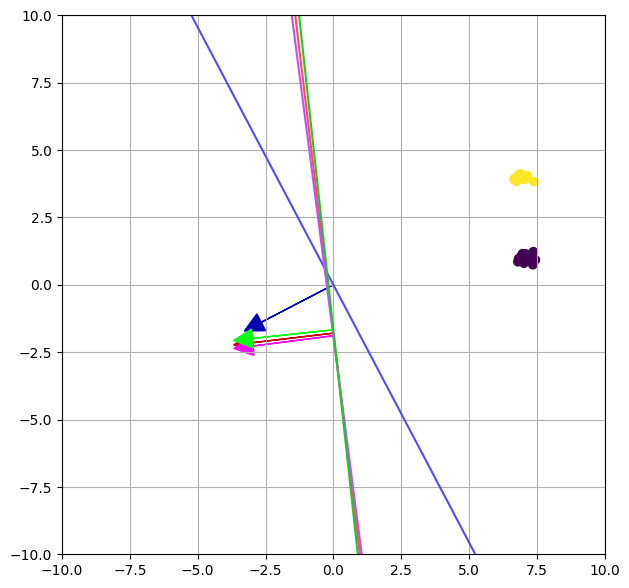

Epoch 250 | Loss 3.773077 | Acc 84.76% | Task Acc 100.00% | Acc Wc 79.48% | Task Acc Wc 100.00%
Eps 0
Final radius tensor([[0.0571, 0.0694]], grad_fn=<AddBackward0>)


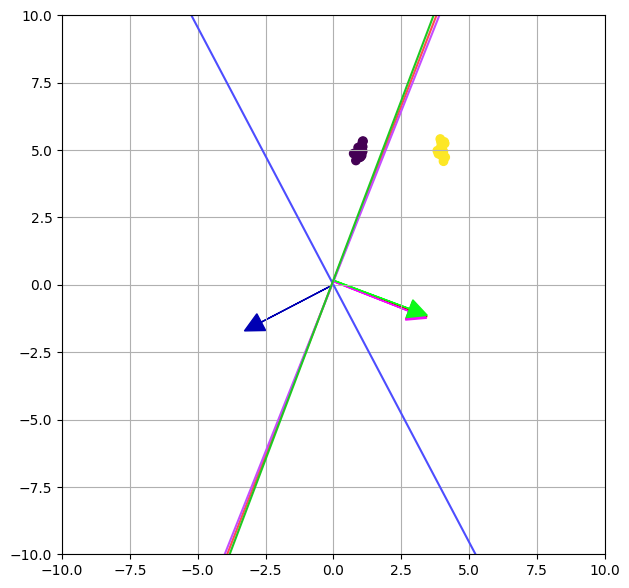

Epoch 500 | Loss 1.898525 | Acc 92.37% | Task Acc 100.00% | Acc Wc 89.72% | Task Acc Wc 100.00%
Eps 0.03000000000000001
Final radius tensor([[0.0623, 0.0704]], grad_fn=<AddBackward0>)


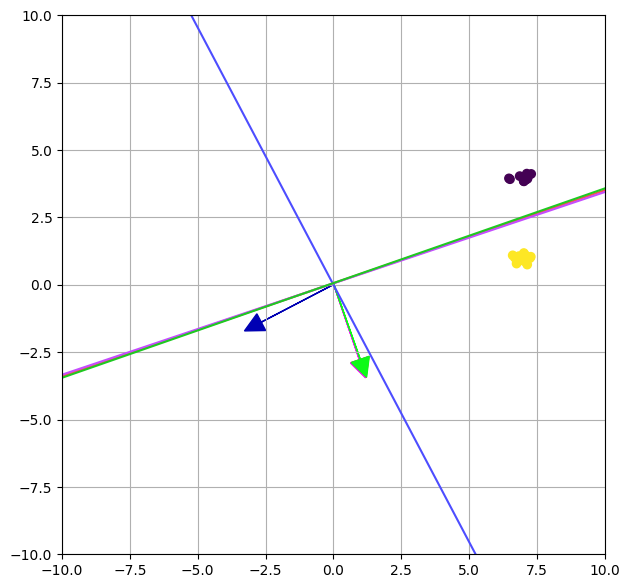

Epoch 750 | Loss 1.266581 | Acc 94.91% | Task Acc 100.00% | Acc Wc 93.14% | Task Acc Wc 100.00%
Eps 0.06750000000000003
Final radius tensor([[0.0677, 0.0731]], grad_fn=<AddBackward0>)


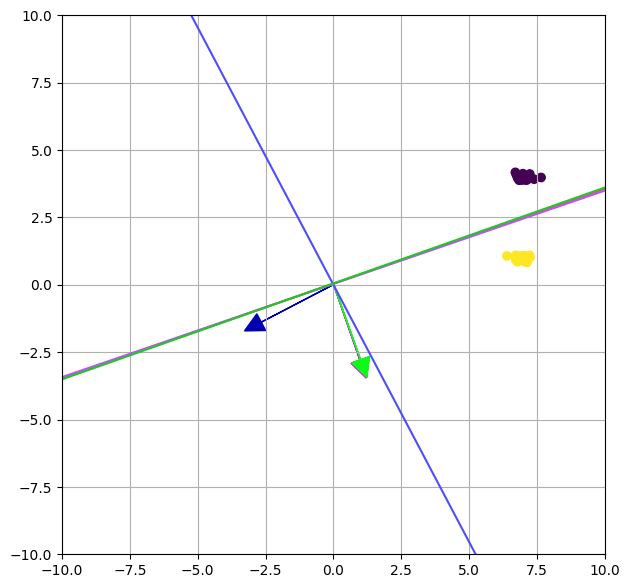

Epoch 1000 | Loss 0.950256 | Acc 96.18% | Task Acc 100.00% | Acc Wc 94.86% | Task Acc Wc 100.00%
Eps 0.10500000000000007
Final radius tensor([[0.1057, 0.1199]], grad_fn=<AddBackward0>)


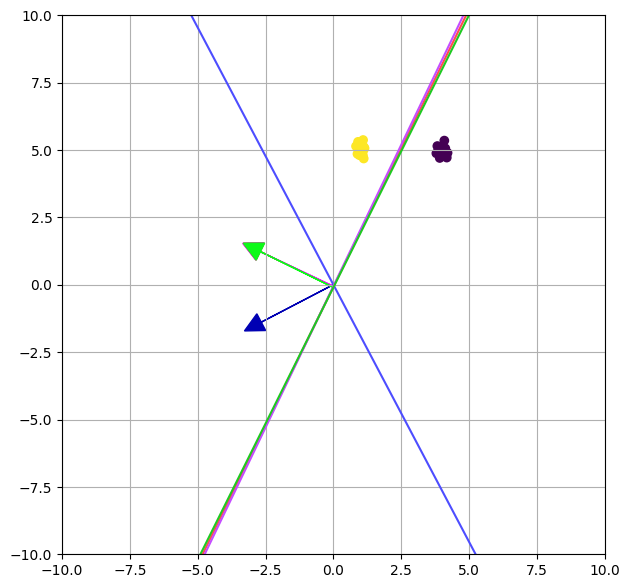

Epoch 1250 | Loss 0.760358 | Acc 96.94% | Task Acc 100.00% | Acc Wc 95.88% | Task Acc Wc 100.00%
Eps 0.1425000000000001
Final radius tensor([[0.2094, 0.1577]], grad_fn=<AddBackward0>)


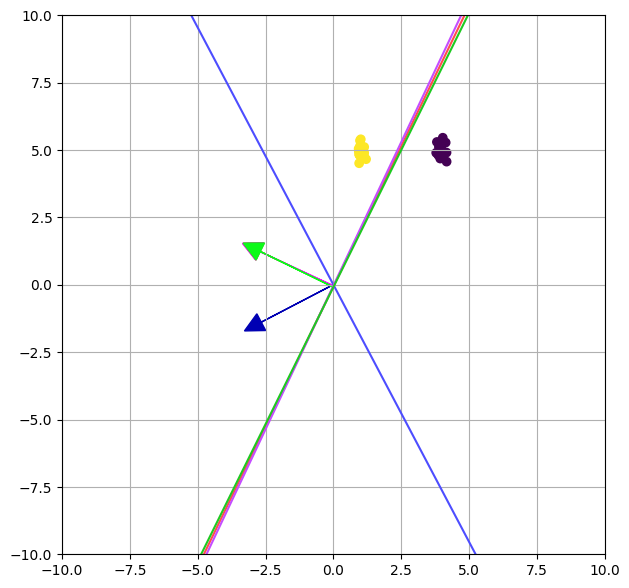

Epoch 1500 | Loss 0.633716 | Acc 97.45% | Task Acc 100.00% | Acc Wc 96.57% | Task Acc Wc 100.00%
Eps 0.18000000000000013
Final radius tensor([[0.1846, 0.1829]], grad_fn=<AddBackward0>)


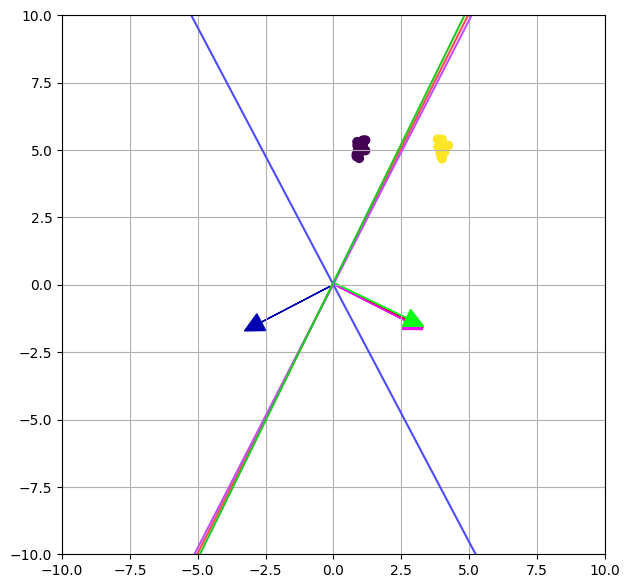

Epoch 1750 | Loss 0.543237 | Acc 97.82% | Task Acc 100.00% | Acc Wc 97.06% | Task Acc Wc 100.00%
Eps 0.21750000000000017
Final radius tensor([[0.2193, 0.2185]], grad_fn=<AddBackward0>)


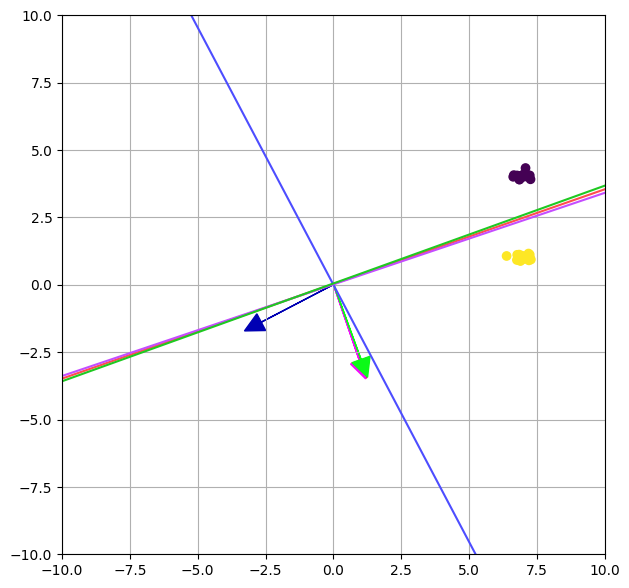

Epoch 2000 | Loss 0.475366 | Acc 98.09% | Task Acc 100.00% | Acc Wc 97.43% | Task Acc Wc 100.00%
Eps 0.25500000000000017
Final radius tensor([[0.2579, 0.2636]], grad_fn=<AddBackward0>)


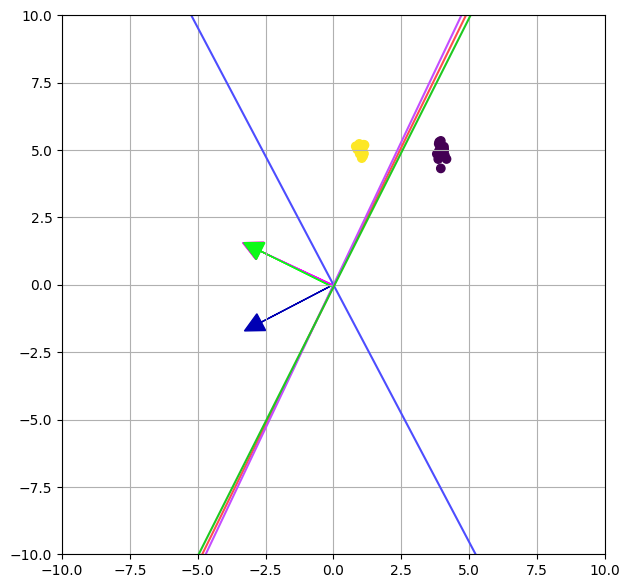

Epoch 2250 | Loss 0.422571 | Acc 98.30% | Task Acc 100.00% | Acc Wc 97.71% | Task Acc Wc 100.00%
Eps 0.2925000000000002
Final radius tensor([[0.2945, 0.2956]], grad_fn=<AddBackward0>)


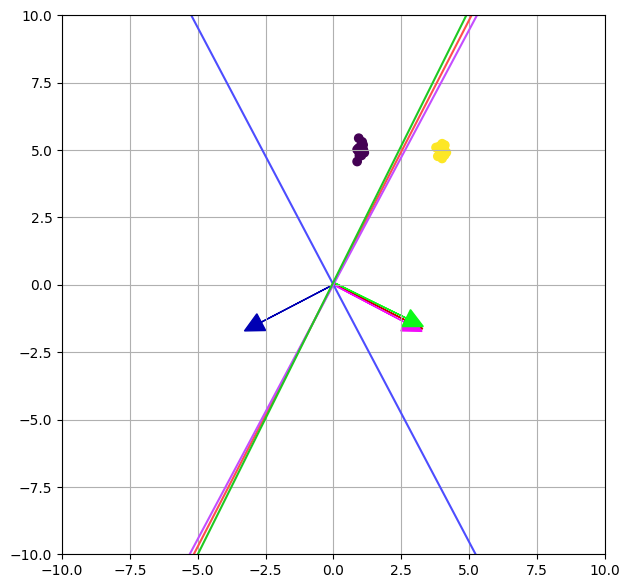

Epoch 2500 | Loss 0.380331 | Acc 98.47% | Task Acc 100.00% | Acc Wc 97.94% | Task Acc Wc 100.00%
Eps 0.33000000000000024
Final radius tensor([[0.3408, 0.3304]], grad_fn=<AddBackward0>)


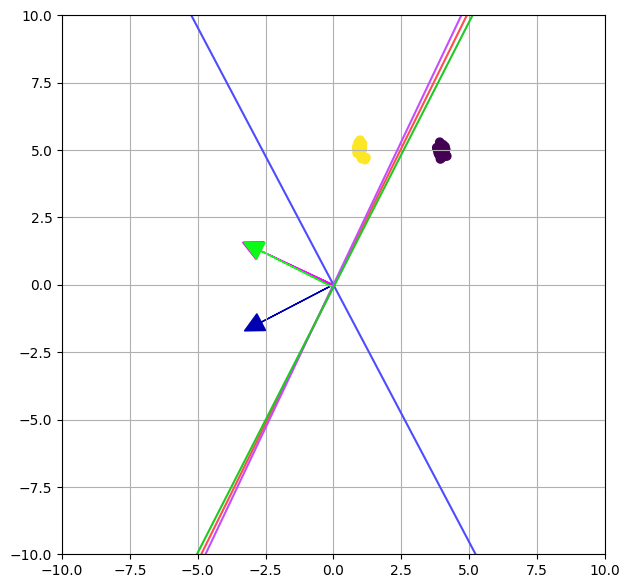

Epoch 2750 | Loss 0.345768 | Acc 98.61% | Task Acc 100.00% | Acc Wc 98.13% | Task Acc Wc 100.00%
Eps 0.36750000000000027
Final radius tensor([[0.3695, 0.3795]], grad_fn=<AddBackward0>)


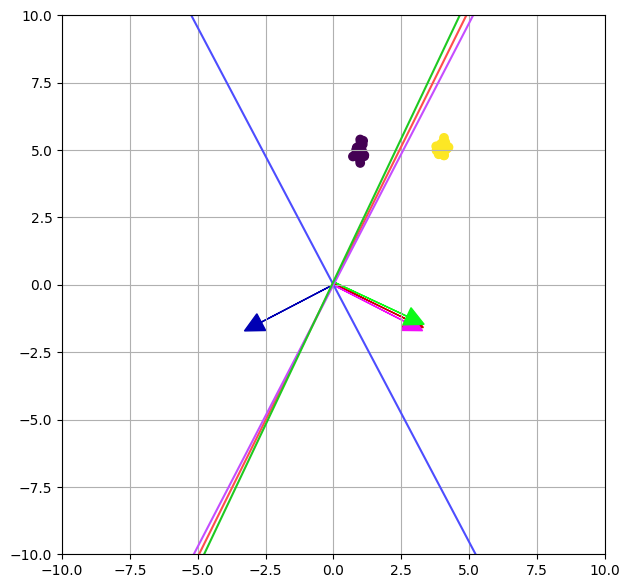

Epoch 3000 | Loss 0.316964 | Acc 98.73% | Task Acc 100.00% | Acc Wc 98.28% | Task Acc Wc 100.00%
Eps 0.4050000000000003
Final radius tensor([[0.4053, 0.4144]], grad_fn=<AddBackward0>)


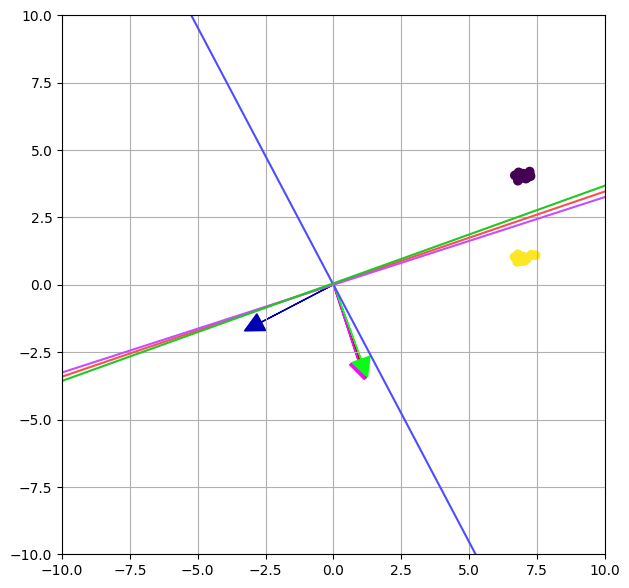

Epoch 3250 | Loss 0.292589 | Acc 98.82% | Task Acc 100.00% | Acc Wc 98.42% | Task Acc Wc 100.00%
Eps 0.44250000000000034
Final radius tensor([[0.4503, 0.4503]], grad_fn=<AddBackward0>)


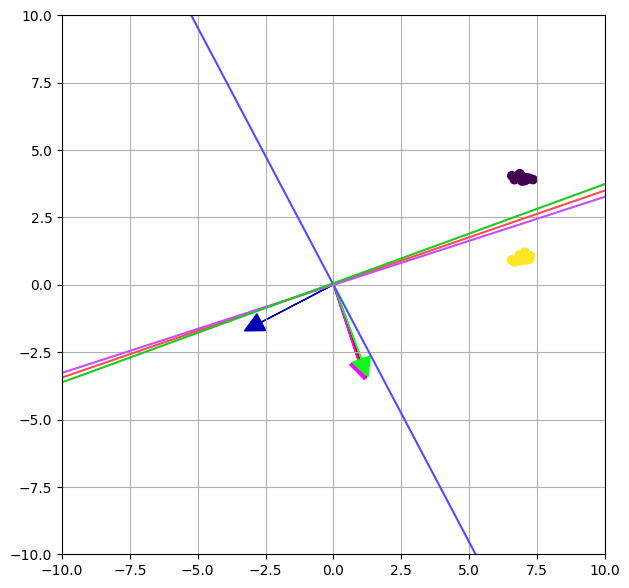

Epoch 3500 | Loss 0.271696 | Acc 98.91% | Task Acc 100.00% | Acc Wc 98.53% | Task Acc Wc 100.00%
Eps 0.48000000000000037
Final radius tensor([[0.4814, 0.4812]], grad_fn=<AddBackward0>)


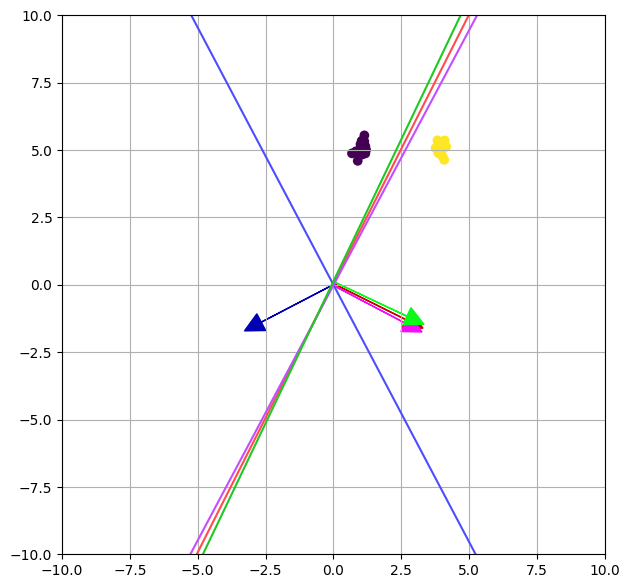

Epoch 3750 | Loss 0.253588 | Acc 98.98% | Task Acc 100.00% | Acc Wc 98.63% | Task Acc Wc 100.00%
Eps 0.5174999999999997
Final radius tensor([[0.5218, 0.5206]], grad_fn=<AddBackward0>)


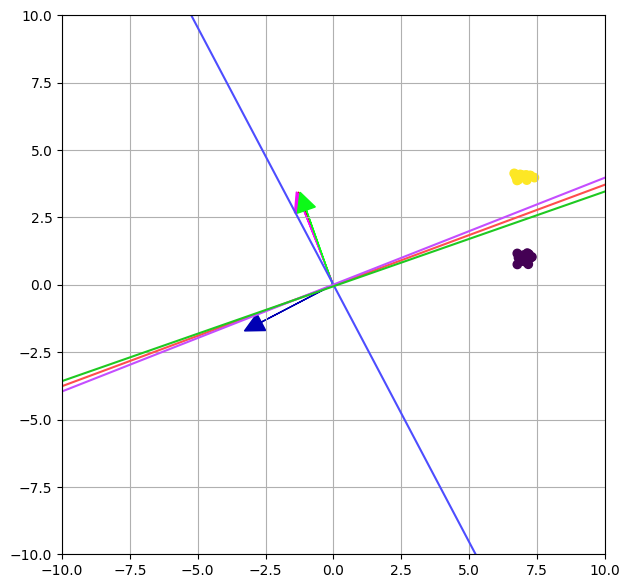

Epoch 4000 | Loss 0.237743 | Acc 99.04% | Task Acc 100.00% | Acc Wc 98.71% | Task Acc Wc 100.00%
Eps 0.5549999999999984
Final radius tensor([[0.5592, 0.5553]], grad_fn=<AddBackward0>)


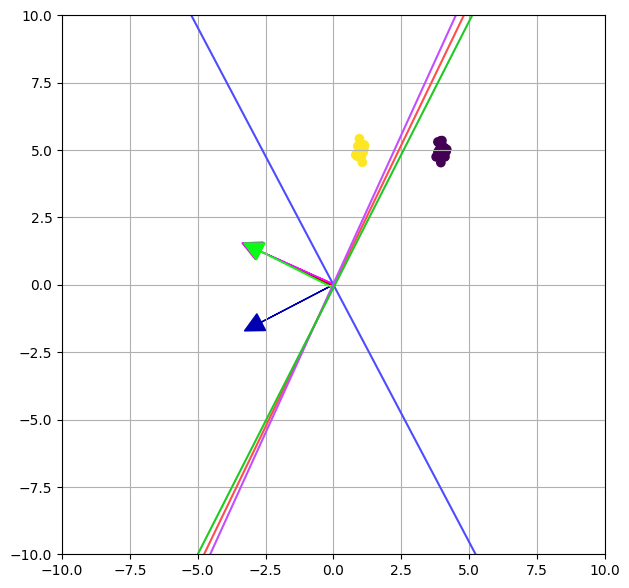

Epoch 4250 | Loss 0.223761 | Acc 99.10% | Task Acc 100.00% | Acc Wc 98.79% | Task Acc Wc 100.00%
Eps 0.592499999999997
Final radius tensor([[0.5954, 0.5960]], grad_fn=<AddBackward0>)


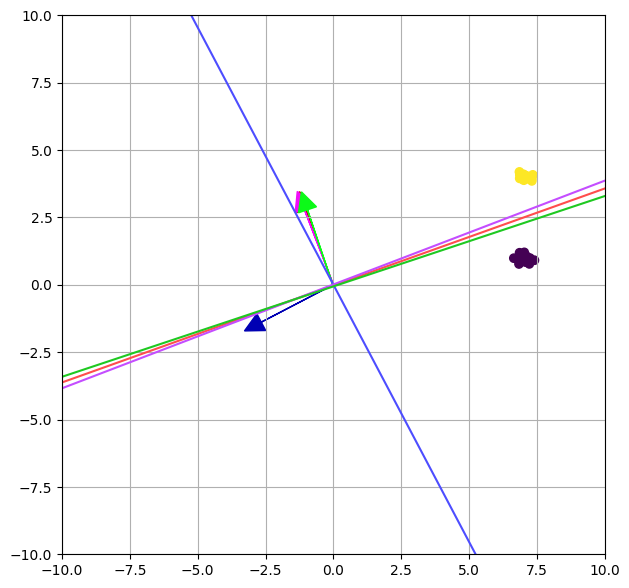

Epoch 4500 | Loss 0.211333 | Acc 99.15% | Task Acc 100.00% | Acc Wc 98.86% | Task Acc Wc 100.00%
Eps 0.6299999999999957
Final radius tensor([[0.6407, 0.6387]], grad_fn=<AddBackward0>)


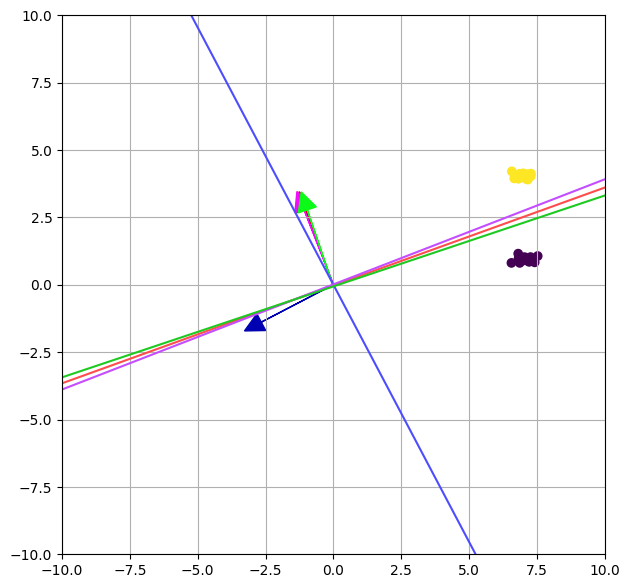

Epoch 4750 | Loss 0.200212 | Acc 99.19% | Task Acc 100.00% | Acc Wc 98.92% | Task Acc Wc 100.00%
Eps 0.6674999999999943
Final radius tensor([[0.6729, 0.6780]], grad_fn=<AddBackward0>)


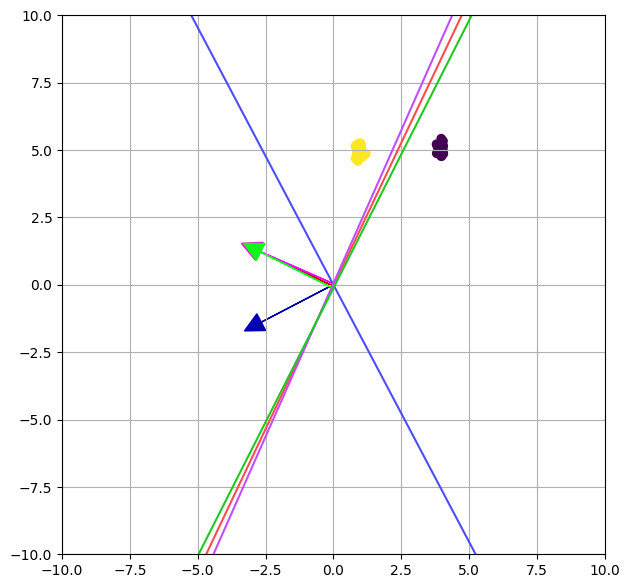

Epoch 5000 | Loss 0.190204 | Acc 99.24% | Task Acc 100.00% | Acc Wc 98.97% | Task Acc Wc 100.00%
Eps 0.704999999999993
Final radius tensor([[0.7051, 0.7163]], grad_fn=<AddBackward0>)


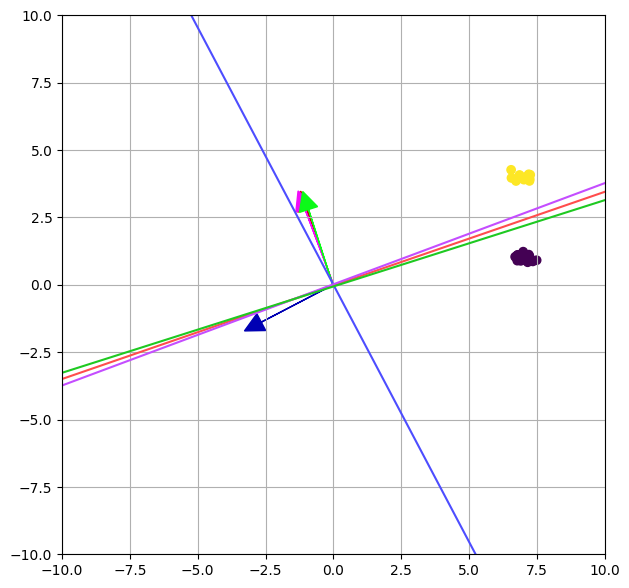

Epoch 5250 | Loss 0.181148 | Acc 99.27% | Task Acc 100.00% | Acc Wc 99.02% | Task Acc Wc 100.00%
Eps 0.7424999999999916
Final radius tensor([[0.7437, 0.7451]], grad_fn=<AddBackward0>)


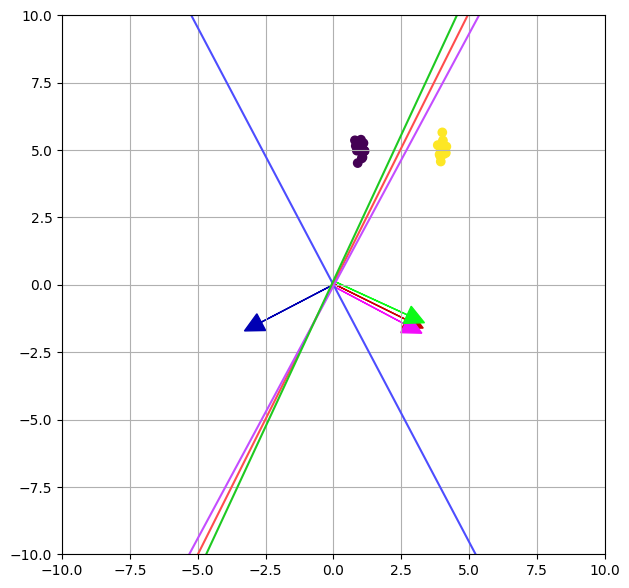

Epoch 5500 | Loss 0.172916 | Acc 99.30% | Task Acc 100.00% | Acc Wc 99.06% | Task Acc Wc 100.00%
Eps 0.7799999999999903
Final radius tensor([[0.7804, 0.7850]], grad_fn=<AddBackward0>)


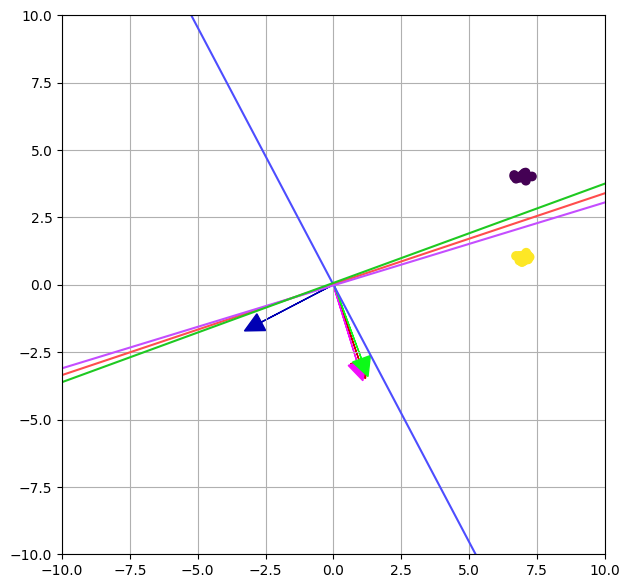

Epoch 5750 | Loss 0.165399 | Acc 99.33% | Task Acc 100.00% | Acc Wc 99.10% | Task Acc Wc 100.00%
Eps 0.8174999999999889
Final radius tensor([[0.8224, 0.8319]], grad_fn=<AddBackward0>)


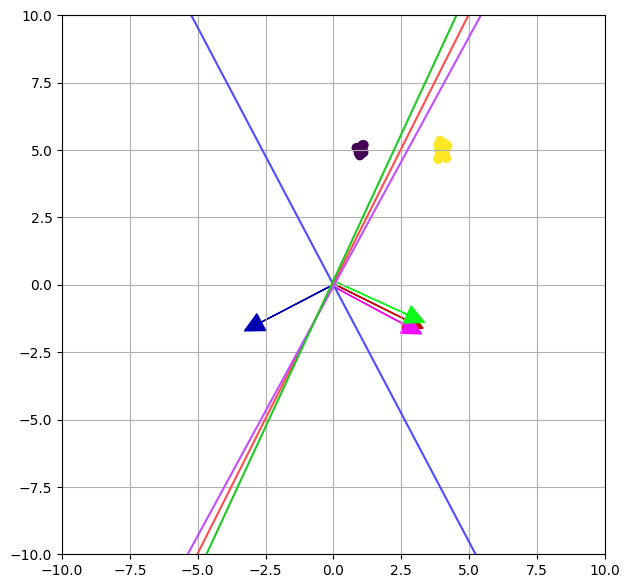

Epoch 6000 | Loss 0.158508 | Acc 99.36% | Task Acc 100.00% | Acc Wc 99.14% | Task Acc Wc 100.00%
Eps 0.8549999999999875
Final radius tensor([[0.8625, 0.8721]], grad_fn=<AddBackward0>)


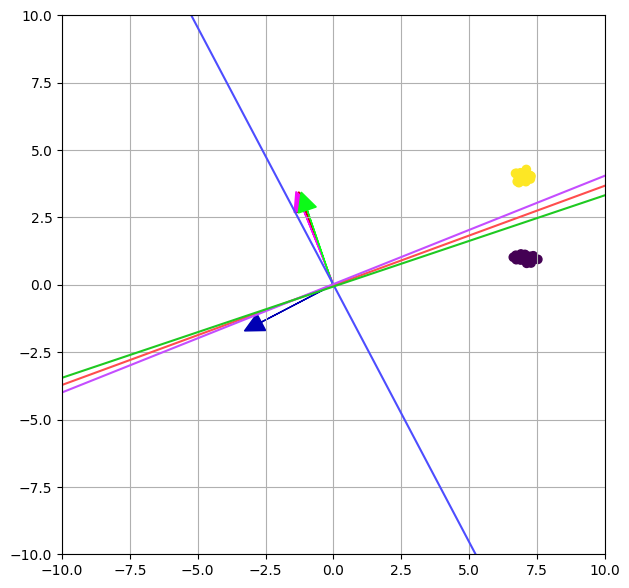

Epoch 6250 | Loss 0.152169 | Acc 99.39% | Task Acc 100.00% | Acc Wc 99.18% | Task Acc Wc 100.00%
Eps 0.8924999999999862
Final radius tensor([[0.8939, 0.8963]], grad_fn=<AddBackward0>)


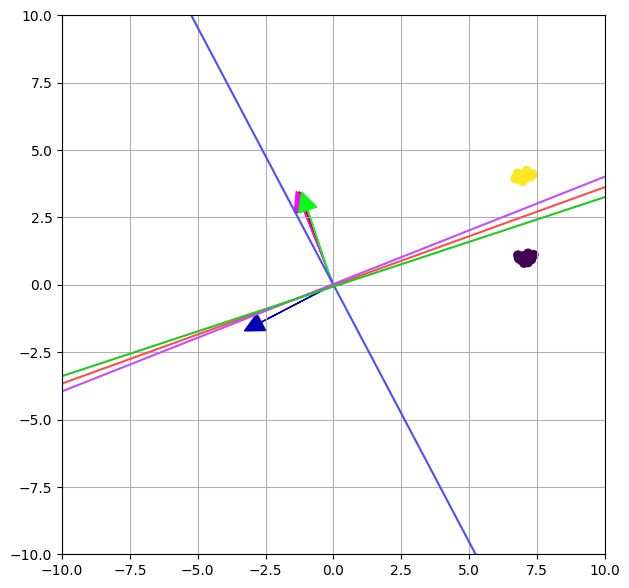

Epoch 6500 | Loss 0.146317 | Acc 99.41% | Task Acc 100.00% | Acc Wc 99.21% | Task Acc Wc 100.00%
Eps 0.9299999999999848
Final radius tensor([[0.9398, 0.9322]], grad_fn=<AddBackward0>)


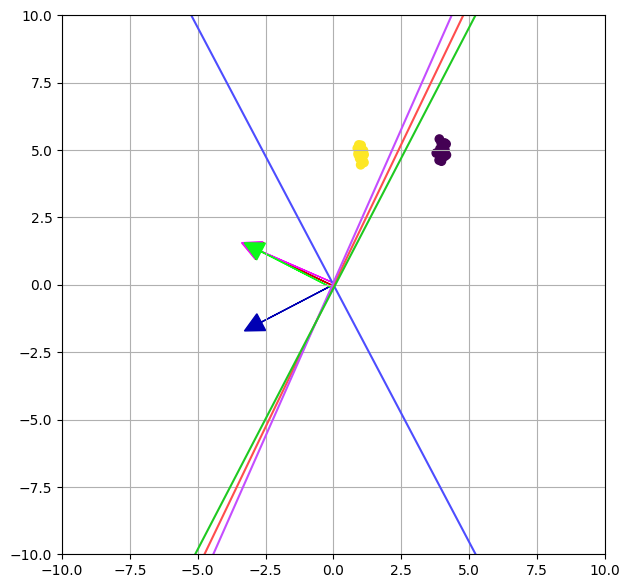

Epoch 6750 | Loss 0.140899 | Acc 99.43% | Task Acc 100.00% | Acc Wc 99.24% | Task Acc Wc 100.00%
Eps 0.9674999999999835
Final radius tensor([[0.9726, 0.9731]], grad_fn=<AddBackward0>)


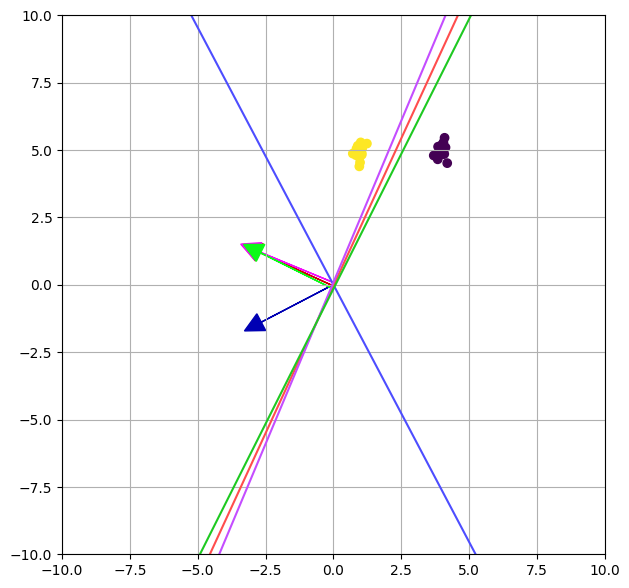

Epoch 7000 | Loss 0.135868 | Acc 99.45% | Task Acc 100.00% | Acc Wc 99.26% | Task Acc Wc 100.00%
Eps 1.0049999999999826
Final radius tensor([[1.0060, 1.0141]], grad_fn=<AddBackward0>)


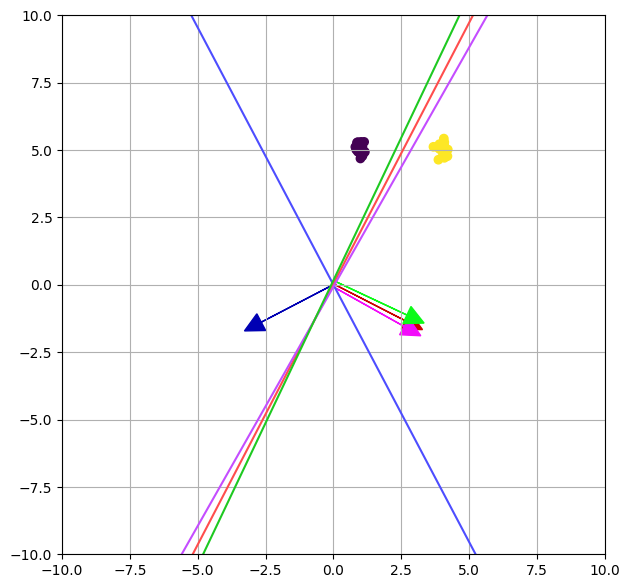

Epoch 7250 | Loss 0.131183 | Acc 99.47% | Task Acc 100.00% | Acc Wc 99.29% | Task Acc Wc 100.00%
Eps 1.042499999999984
Final radius tensor([[1.0742, 1.0802]], grad_fn=<AddBackward0>)


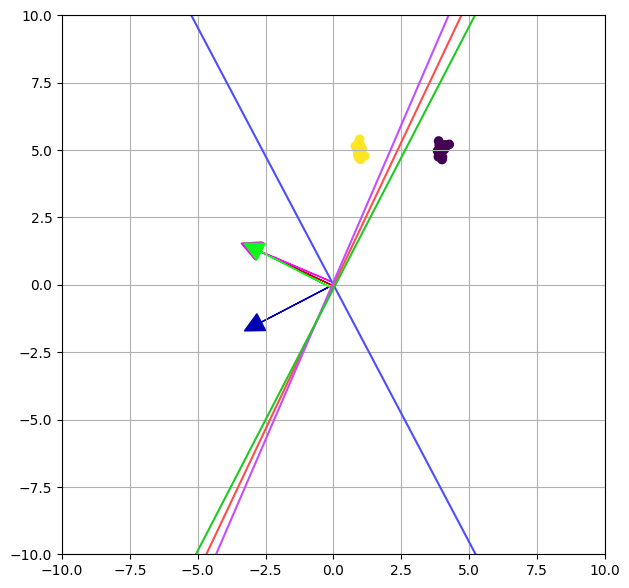

Epoch 7500 | Loss 0.126811 | Acc 99.49% | Task Acc 100.00% | Acc Wc 99.31% | Task Acc Wc 100.00%
Eps 1.0799999999999854
Final radius tensor([[1.0883, 1.1530]], grad_fn=<AddBackward0>)


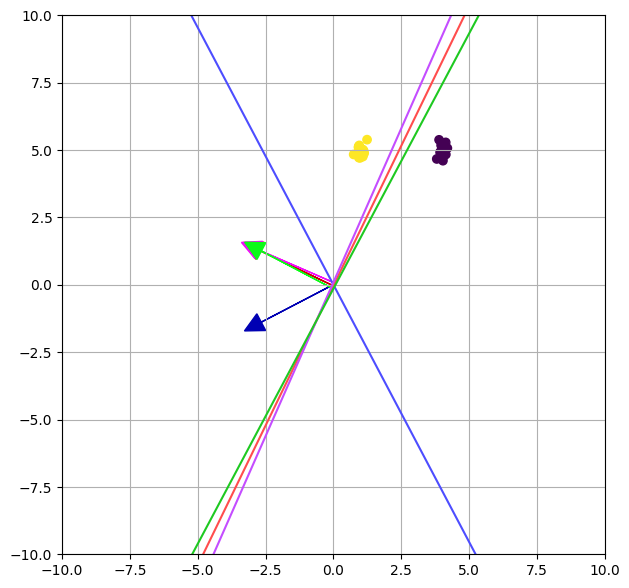

Epoch 7750 | Loss 0.122721 | Acc 99.51% | Task Acc 100.00% | Acc Wc 99.34% | Task Acc Wc 100.00%
Eps 1.1174999999999868
Final radius tensor([[1.1218, 1.1428]], grad_fn=<AddBackward0>)


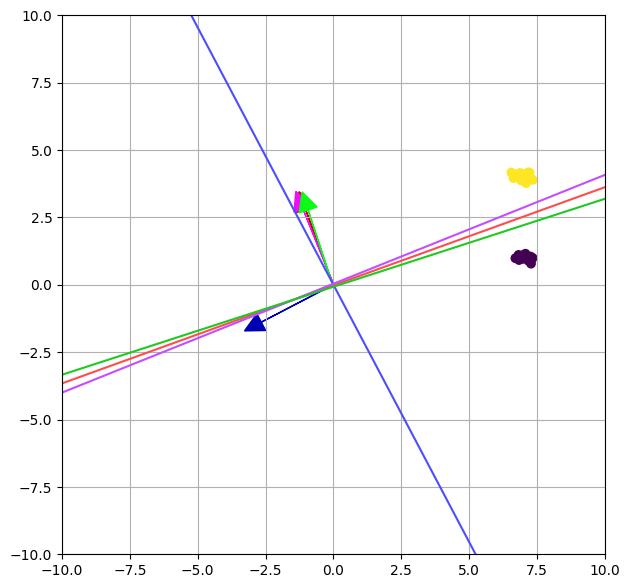

Epoch 8000 | Loss 0.118886 | Acc 99.52% | Task Acc 100.00% | Acc Wc 99.36% | Task Acc Wc 100.00%
Eps 1.1549999999999883
Final radius tensor([[1.1616, 1.1717]], grad_fn=<AddBackward0>)


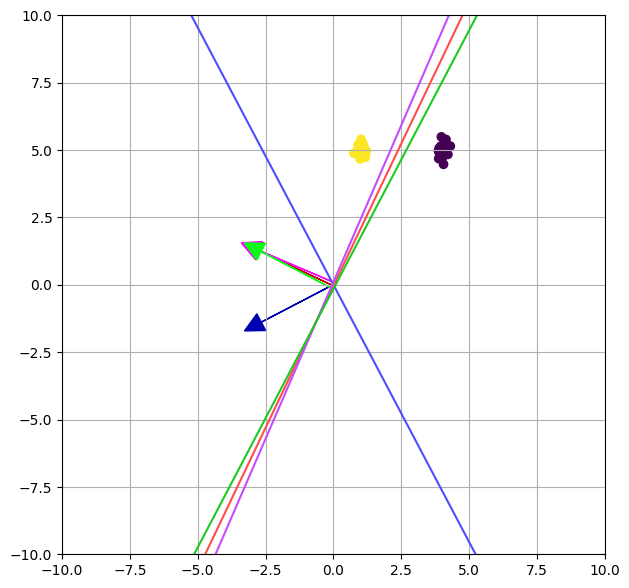

Epoch 8250 | Loss 0.115284 | Acc 99.54% | Task Acc 100.00% | Acc Wc 99.38% | Task Acc Wc 100.00%
Eps 1.1924999999999897
Final radius tensor([[1.1990, 1.1973]], grad_fn=<AddBackward0>)


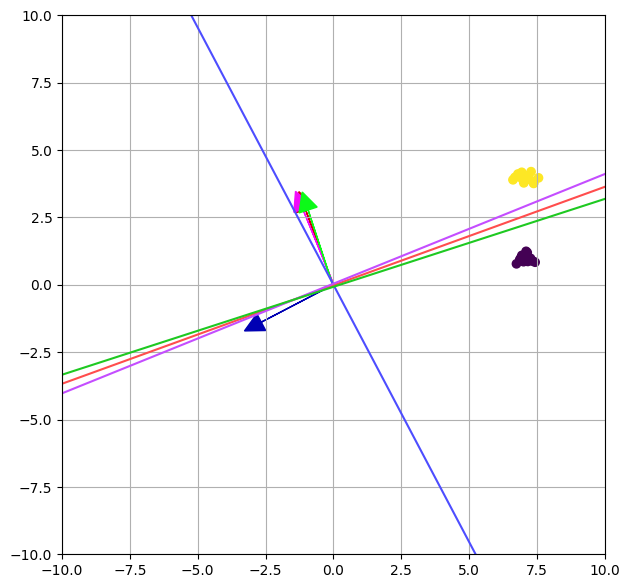

Epoch 8500 | Loss 0.111894 | Acc 99.55% | Task Acc 100.00% | Acc Wc 99.39% | Task Acc Wc 100.00%
Eps 1.229999999999991
Final radius tensor([[1.2325, 1.2332]], grad_fn=<AddBackward0>)


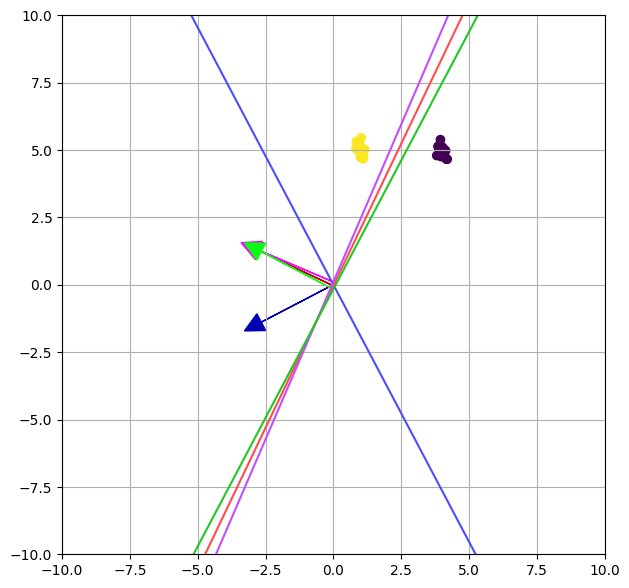

Epoch 8750 | Loss 0.108697 | Acc 99.56% | Task Acc 100.00% | Acc Wc 99.41% | Task Acc Wc 100.00%
Eps 1.2674999999999925
Final radius tensor([[1.2716, 1.2713]], grad_fn=<AddBackward0>)


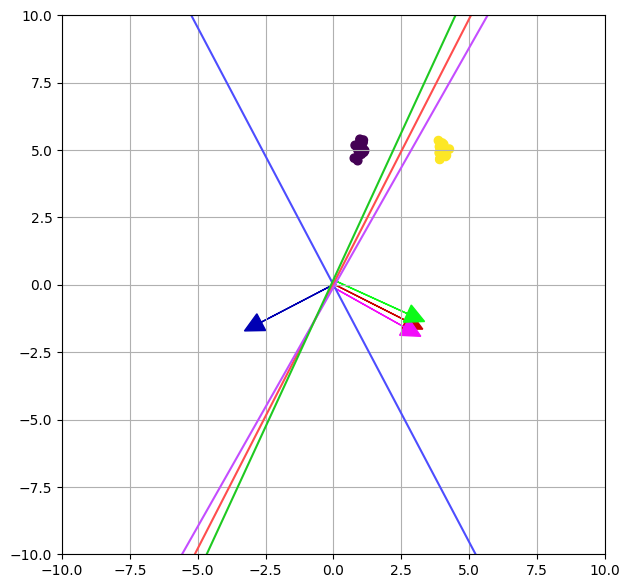

Epoch 9000 | Loss 0.105678 | Acc 99.58% | Task Acc 100.00% | Acc Wc 99.43% | Task Acc Wc 100.00%
Eps 1.304999999999994
Final radius tensor([[1.3372, 1.3252]], grad_fn=<AddBackward0>)


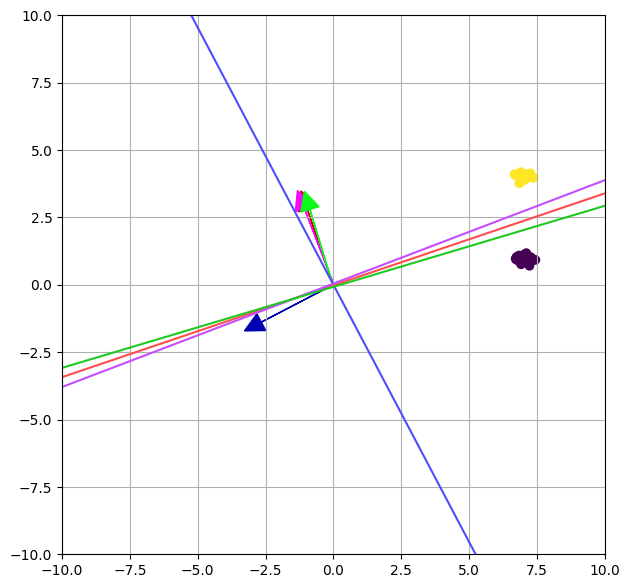

Epoch 9250 | Loss 0.102822 | Acc 99.59% | Task Acc 100.00% | Acc Wc 99.44% | Task Acc Wc 100.00%
Eps 1.3424999999999954
Final radius tensor([[1.4030, 1.3988]], grad_fn=<AddBackward0>)


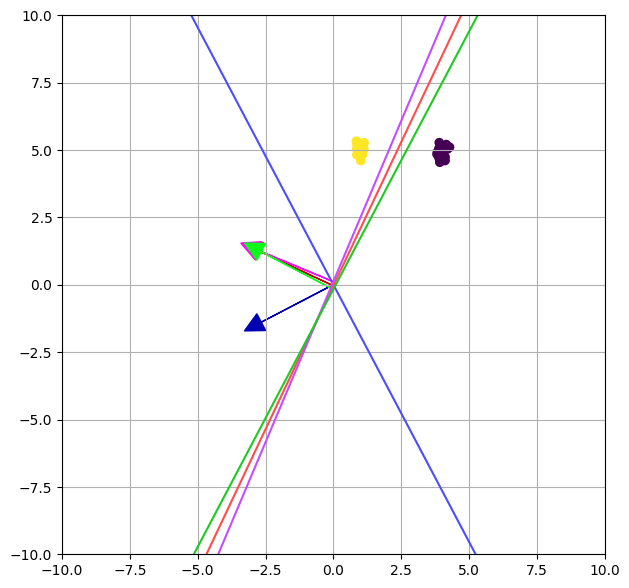

Epoch 9500 | Loss 0.100117 | Acc 99.60% | Task Acc 100.00% | Acc Wc 99.46% | Task Acc Wc 100.00%
Eps 1.3799999999999968
Final radius tensor([[1.3826, 1.3838]], grad_fn=<AddBackward0>)


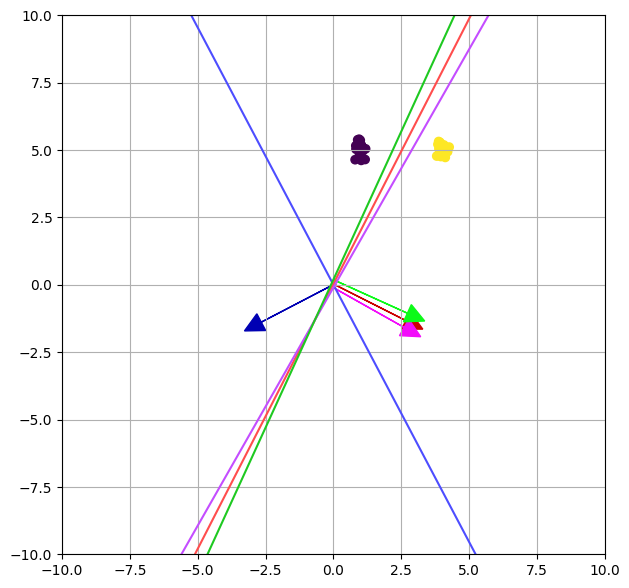

Epoch 9750 | Loss 0.097550 | Acc 99.61% | Task Acc 100.00% | Acc Wc 99.47% | Task Acc Wc 100.00%
Eps 1.4174999999999982
Final radius tensor([[1.4219, 1.4404]], grad_fn=<AddBackward0>)


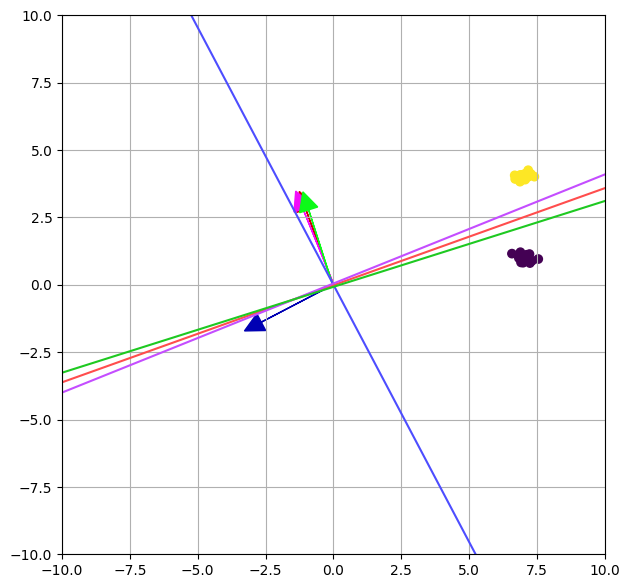

In [132]:
n_tasks = 10000

print_freq = 250
task_count = 0
avg_loss = 0
loss_all = []
acc_all = []
acc_wc_all = []
enable_plotting = True
plot_decision_boundary = True
optimizer.zero_grad()


for i in np.arange(n_tasks):
  model.current_epoch_nr = i


  X, y = make_task(n=20)

  X_support, y_support, X_query, y_query = split_support_query(X, y)

  A, B, C = get_vector(model)

  loss, task_accuracy, worst_case_task_accuracy, positions, worst_case_positions = model.set_forward_loss(X_support, y_support, X_query, y_query)

  avg_loss = avg_loss + loss.item()#.data[0]
  loss_all.append(loss)
  acc_all.append(task_accuracy)
  if worst_case_task_accuracy is not None:
      acc_wc_all.append(worst_case_task_accuracy)

  task_count += 1

  if task_count == model.n_task: #MAML update several tasks at one time
      loss_q = torch.stack(loss_all).sum(0)
      loss_q.backward()

      optimizer.step()
      task_count = 0
      loss_all = []

  optimizer.zero_grad()
  if i % print_freq==0:
      acc_all_np  = np.asarray(acc_all)
      acc_mean = np.mean(acc_all_np)
      acc_wc_all_np  = np.asarray(acc_wc_all)
      acc_wc_mean = np.mean(acc_wc_all_np)
      print('Epoch {:d} | Loss {:f} | Acc {:4.2f}% | Task Acc {:4.2f}% | Acc Wc {:4.2f}% | Task Acc Wc {:4.2f}%'.format(i, avg_loss/float(i+1), acc_mean, task_accuracy, acc_wc_mean, worst_case_task_accuracy))
      print('Eps', model.eps)
      print('Final radius', model.classifier.weight.radius)

  # to jest połączony saport z query wiec podziel na dwa tak, żeby w saport i qery było po tylesamo 0 i 1, pół na pół
  if enable_plotting and i % print_freq == 0:
    figs, axs = plt.subplots(1,1, figsize=(7, 7))
    plt.scatter(X[:,0], X[:,1], c=y)
    axs.set_xlim([-10,10])
    axs.set_ylim([-10,10])

    if plot_decision_boundary:
      A_middle_fast, B_middle_fast, C_middle_fast, A_lower_fast, B_lower_fast, C_lower_fast, A_upper_fast, B_upper_fast, C_upper_fast = get_fast_vectors_with_radius(model)

      scale = 3

      x_step = np.absolute(B) * (15 / np.sqrt((np.power(A, 2) + np.power(B, 2))))
      x_arg = np.arange(-x_step, x_step + 0.1, 0.1)

      x_middle_fast_step = np.absolute(B_middle_fast) * (15 / np.sqrt((np.power(A_middle_fast, 2) + np.power(B_middle_fast, 2))))
      x_middle_fast_arg = np.arange(-(x_middle_fast_step + 10), x_middle_fast_step + 10.1, 0.1)

      x_lower_fast_step = np.absolute(B_lower_fast) * (15 / np.sqrt((np.power(A_lower_fast, 2) + np.power(B_lower_fast, 2))))
      x_lower_fast_arg = np.arange(-(x_lower_fast_step + 10), x_lower_fast_step + 10.1, 0.1)

      x_upper_fast_step = np.absolute(B_upper_fast) * (15 / np.sqrt((np.power(A_upper_fast, 2) + np.power(B_upper_fast, 2))))
      x_upper_fast_arg = np.arange(-(x_upper_fast_step + 10), x_upper_fast_step + 10.1, 0.1)

      yx_middle_fast = (-A_middle_fast/B_middle_fast)*x_middle_fast_arg-(C_middle_fast/B_middle_fast)
      yx_lower_fast = (-A_lower_fast/B_lower_fast)*x_lower_fast_arg-(C_lower_fast/B_lower_fast)
      yx_upper_fast = (-A_upper_fast/B_upper_fast)*x_upper_fast_arg-(C_upper_fast/B_upper_fast)
      yx = (-A/B)*x_arg-(C/B)

      arr_length1 = np.sqrt(np.power(A, 2) + np.power(B, 2))
      arr_length2_middle = np.sqrt(np.power(A_middle_fast, 2) + np.power(B_middle_fast, 2))
      arr_length2_lower = np.sqrt(np.power(A_lower_fast, 2) + np.power(B_lower_fast, 2))
      arr_length2_upper = np.sqrt(np.power(A_upper_fast, 2) + np.power(B_upper_fast, 2))

      dx = scale*A/arr_length1
      dy = scale*B/arr_length1
      dx_middle_fast = scale*A_middle_fast/arr_length2_middle
      dy_middle_fast = scale*B_middle_fast/arr_length2_middle
      dx_lower_fast = scale*A_lower_fast/arr_length2_lower
      dy_lower_fast = scale*B_lower_fast/arr_length2_lower
      dx_upper_fast = scale*A_upper_fast/arr_length2_upper
      dy_upper_fast = scale*B_upper_fast/arr_length2_upper

      plt.arrow(0, -(C/B), dx, dy, head_width=0.7, head_length=0.7, fc='#0000b3', ec='#0000b3')
      plt.arrow(0, -(C_middle_fast/B_middle_fast), dx_middle_fast, dy_middle_fast, head_width=0.7, head_length=0.7, fc='#cc0000', ec='#cc0000')
      plt.arrow(0, -(C_lower_fast/B_lower_fast), dx_lower_fast, dy_lower_fast, head_width=0.7, head_length=0.7, fc='#f20cfa', ec='#f20cfa')
      plt.arrow(0, -(C_upper_fast/B_upper_fast), dx_upper_fast, dy_upper_fast, head_width=0.7, head_length=0.7, fc='#0cfa18', ec='#0cfa18')
      plt.plot(x_arg, yx, c='#4d4dff')
      plt.plot(x_middle_fast_arg, yx_middle_fast, c='#ff4d4d')
      plt.plot(x_lower_fast_arg, yx_lower_fast, c='#c44dff')
      plt.plot(x_upper_fast_arg, yx_upper_fast, c='#1ec921')

    plt.grid()
    plt.show()
